In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import time

In [2]:
판례목록_df = pd.read_html("법령검색목록.html")
판례목록_df = 판례목록_df[0]
판례목록_df = 판례목록_df[(판례목록_df["판결유형"] == "민사") | (판례목록_df["판결유형"] == "일반행정") | (판례목록_df["판결유형"] == "가사") | (판례목록_df["판결유형"] == "세무")]
판례목록_df

,순번,판례ID,제목,법원,사건유형,판결유형,선고일자
0,1,216815,가축분뇨배출시설변경허가신청불허가처분취소청구,대법원,대법원,일반행정,2021.06.30
3,4,216807,대여금,대법원,대법원,민사,2021.06.30
4,5,216803,손해배상(기),대법원,대법원,민사,2021.06.30
5,6,216801,손해배상(기),대법원,대법원,민사,2021.06.30
6,7,216811,수수료등반환청구,대법원,대법원,민사,2021.06.30
...,...,...,...,...,...,...,...
39992,39993,211021,판결경정,대법원,대법원,민사,1987.09.15
39993,39994,103554,가설건축물허가처분취소,대법원,대법원,일반행정,1987.09.08
39994,39995,103542,"가옥명도,유익비청구",대법원,대법원,민사,1987.09.08
39996,39997,103535,건물철거,대법원,대법원,민사,1987.09.08


In [3]:
판례목록_하등_df = pd.read_html("법령검색목록(1).html")
판례목록_하등_df = 판례목록_하등_df[0]
판례목록_하등_df

,순번,판례ID,제목,법원,사건유형,판결유형,선고일자
0,1,159757,유족 급여 및 장의비 부지급 처분 취소,대법원,하급심,일반행정,2011.03.14
1,2,158627,손해배상(기),대법원,하급심,민사,2011.01.27
2,3,170423,대통령긴급조치제9호 위반,대법원,하급심,형사,1980.05.13
3,4,207178,강간(인정된죄명:준강간미수·변경된죄명:준강간),고등군사법원,하급심,형사,2018.09.13
4,5,182787,상관살해·상관살해미수·살인·살인미수·군용물절도·군용물손괴·군무이탈,고등군사법원,하급심,형사,2015.08.17
...,...,...,...,...,...,...,...
24096,24097,120740,등록취소(상),특허법원,하급심,특허,1998.12.17
24097,24098,120738,권리범위확인(특),특허법원,하급심,특허,1998.11.26
24098,24099,120739,거절사정(상),특허법원,하급심,특허,1998.11.12
24099,24100,77923,직무유기(변경된죄명:위계공무집행방해)·위계공무집행방해,해군작전사령부 보통군사법원,하급심,형사,2006.01.17


In [4]:
# set(판례목록_하등_df["판결유형"])
판례목록_하등_df = 판례목록_하등_df[(판례목록_하등_df["판결유형"] == "민사") | (판례목록_하등_df["판결유형"] == "일반행정") | (판례목록_하등_df["판결유형"] == "가사") | (판례목록_하등_df["판결유형"] == "세무")]
판례목록_하등_df

,순번,판례ID,제목,법원,사건유형,판결유형,선고일자
0,1,159757,유족 급여 및 장의비 부지급 처분 취소,대법원,하급심,일반행정,2011.03.14
1,2,158627,손해배상(기),대법원,하급심,민사,2011.01.27
25,26,213639,채무부존재확인,광주고등법원,하급심,민사,2020.07.23
26,27,214669,총회결의무효확인 등,광주고등법원,하급심,민사,2020.05.13
27,28,214663,조합장지위 부존재확인 등,광주고등법원,하급심,민사,2020.01.22
...,...,...,...,...,...,...,...
23593,23594,185130,상표사용금지등,특허법원,하급심,민사,2017.04.06
23597,23598,184574,특허권등록말소,특허법원,하급심,민사,2017.02.07
23599,23600,209301,특허권침해금지청구의소,특허법원,하급심,민사,2017.01.20
23680,23681,167473,등록 취소(상),특허법원,하급심,세무,2012.05.31


In [3]:
# # 판례 XML 상세조회
# info = []
# def crawling_func(url):
#     global info
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)
#         판례내용_sop = BeautifulSoup(soup.판례내용.get_text())
#         판례내용 = 판례내용_soup.get_text()
#         info.append([ID,판례내용])
#     except:
#         print(url,"오류발생, 재귀호출 시작")
#         time.sleep(1)
#         crawling_func(url)
#     finally:
#         return

# for idx,ID in enumerate(판례목록_df["판례ID"]):    
#     #기본 url
#     url = "http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=prec&ID={}&type=XML".format(ID)
#     crawling_func(url)
#     print(idx,ID)
    
# # info

/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:177: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 194 of the file /opt/anaconda3/lib/python3.8/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  warnings.warn(self.NO_PARSER_SPECIFIED_WARNING % dict(


0 216815
1 216821
2 216819
3 216807
4 216803
5 216801
6 216811
7 216813
8 216817
9 216809
10 216839
11 216841
12 216825
13 216831
14 217047
15 216835
16 216845
17 216843
18 216823
19 216833
20 216797
21 216865
22 216847
23 216855
24 216851
25 216849
26 216857
27 216853
28 216867
29 216861
30 216859
31 216863
32 216727
33 216659
34 216657
35 216683
36 216671
37 216673
38 216667
39 216663
40 216669
41 216675
42 216661
43 216681
44 216665
45 216677
46 216679
47 216685
48 216655
49 215855
50 215411
51 215415
52 215413
53 215417
54 215419
55 215427
56 215423
57 215425
58 215421
59 216689
60 215135
61 216981
62 215159
63 215147
64 215153
65 215155
66 215137
67 215139
68 215143
69 216983
70 215161
71 216985
72 215141
73 215157
74 215145
75 215149
76 215151
77 215165
78 215133
79 216789
80 214571
81 214577
82 216997
83 214583
84 214595
85 216993
86 214579
87 214593
88 214601
89 214603
90 214573
91 216987
92 216989
93 216999
94 214587
95 214589
96 216995
97 214581
98 214585
99 214599
100 214605

755 208407
756 208414
757 208403
758 208399
759 208415
760 208402
761 208400
762 208410
763 208405
764 208807
765 208413
766 208398
767 208397
768 208406
769 208401
770 208808
771 207526
772 207539
773 207527
774 207542
775 207532
776 207528
777 207538
778 207530
779 207531
780 207529
781 207541
782 207535
783 208809
784 207533
785 207534
786 207540
787 207536
788 207537
789 207543
790 207477
791 207480
792 207484
793 207487
794 207478
795 207486
796 207485
797 207481
798 207483
799 208810
800 207479
801 207482
802 207488
803 207493
804 207490
805 207491
806 207492
807 207489
808 207139
809 207143
810 207138
811 207140
812 207142
813 207141
814 207137
815 207144
816 207145
817 207146
818 207513
819 208811
820 207147
821 207109
822 207111
823 207119
824 207106
825 207120
826 207117
827 207112
828 207116
829 208412
830 207100
831 207095
832 207115
833 207102
834 207122
835 207476
836 208812
837 207107
838 206289
839 206293
840 206290
841 206292
842 206286
843 206294
844 206287
845 206291

1459 204886
1460 199864
1461 204885
1462 199853
1463 199849
1464 204589
1465 199845
1466 199850
1467 206107
1468 199736
1469 199847
1470 204590
1471 199848
1472 199854
1473 199733
1474 199858
1475 199855
1476 199734
1477 204592
1478 199869
1479 199867
1480 206111
1481 206109
1482 199872
1483 206110
1484 206108
1485 204595
1486 204594
1487 199870
1488 204593
1489 199871
1490 199873
1491 199865
1492 199866
1493 199868
1494 199874
1495 204596
1496 198836
1497 199875
1498 198832
1499 206113
1500 198844
1501 198734
1502 204603
1503 204598
1504 204600
1505 204601
1506 198834
1507 204891
1508 198733
1509 198831
1510 198833
1511 198842
1512 206115
1513 204888
1514 198841
1515 204777
1516 198840
1517 198830
1518 198837
1519 204892
1520 206112
1521 198848
1522 198829
1523 204889
1524 198838
1525 198845
1526 198846
1527 204776
1528 199876
1529 198732
1530 198843
1531 204599
1532 198828
1533 198835
1534 204887
1535 204890
1536 204602
1537 206114
1538 206132
1539 198847
1540 198839
1541 206116
1542

2143 197933
2144 185874
2145 185883
2146 197936
2147 185881
2148 185875
2149 185885
2150 195391
2151 197935
2152 185873
2153 197932
2154 195389
2155 188005
2156 185884
2157 188004
2158 185886
2159 197937
2160 185890
2161 197930
2162 185893
2163 185892
2164 197938
2165 185887
2166 185888
2167 185891
2168 185895
2169 185889
2170 185894
2171 199898
2172 185816
2173 185795
2174 199900
2175 185810
2176 197939
2177 185753
2178 199899
2179 185809
2180 185799
2181 185805
2182 193128
2183 197940
2184 195395
2185 185820
2186 185813
2187 185814
2188 197943
2189 197946
2190 185801
2191 185797
2192 199748
2193 185756
2194 185755
2195 185796
2196 185808
2197 192757
2198 197948
2199 195393
2200 197949
2201 195396
2202 197941
2203 185822
2204 185812
2205 188002
2206 197947
2207 185751
2208 197945
2209 195394
2210 197944
2211 185754
2212 188000
2213 197942
2214 199743
2215 185815
2216 185821
2217 185802
2218 197950
2219 185804
2220 195398
2221 195399
2222 185807
2223 199902
2224 185806
2225 185818
2226

2829 184614
2830 184238
2831 184243
2832 184932
2833 184611
2834 184933
2835 184239
2836 184937
2837 184235
2838 184936
2839 184935
2840 184245
2841 184233
2842 184244
2843 184242
2844 184931
2845 184934
2846 184613
2847 184237
2848 185031
2849 184240
2850 184234
2851 184232
2852 192733
2853 184246
2854 184615
2855 184092
2856 215857
2857 184093
2858 184099
2859 184113
2860 184102
2861 184106
2862 184116
2863 184839
2864 202151
2865 184107
2866 209189
2867 184112
2868 184838
2869 184837
2870 184100
2871 184096
2872 184103
2873 184115
2874 184094
2875 184105
2876 184098
2877 184097
2878 184111
2879 184108
2880 184104
2881 184110
2882 184109
2883 184095
2884 184785
2885 183965
2886 184780
2887 183955
2888 187953
2889 183951
2890 183952
2891 187951
2892 183964
2893 184540
2894 183963
2895 183960
2896 184776
2897 183959
2898 184543
2899 183957
2900 184778
2901 187955
2902 183961
2903 184539
2904 184541
2905 183953
2906 184544
2907 184538
2908 184542
2909 184786
2910 184777
2911 184783
2912

3515 183307
3516 180374
3517 182862
3518 182867
3519 182074
3520 182874
3521 194875
3522 182869
3523 184074
3524 182348
3525 182868
3526 182873
3527 182072
3528 182347
3529 182865
3530 182430
3531 182863
3532 182864
3533 182071
3534 182875
3535 182073
3536 182429
3537 182870
3538 182872
3539 187770
3540 209181
3541 209225
3542 180328
3543 181221
3544 181217
3545 180330
3546 181216
3547 187766
3548 180322
3549 181224
3550 180319
3551 180318
3552 180316
3553 180329
3554 187767
3555 181218
3556 180317
3557 180333
3558 182075
3559 182431
3560 180331
3561 181223
3562 187765
3563 180312
3564 181222
3565 180321
3566 182077
3567 182432
3568 180323
3569 180320
3570 180315
3571 180332
3572 180325
3573 180324
3574 184398
3575 182076
3576 187764
3577 180311
3578 180239
3579 181215
3580 180247
3581 180238
3582 182434
3583 180252
3584 181213
3585 181212
3586 180240
3587 187762
3588 180245
3589 180253
3590 182411
3591 182436
3592 182435
3593 180242
3594 182081
3595 180250
3596 182415
3597 187758
3598

4199 178128
4200 178135
4201 178138
4202 180179
4203 180181
4204 179080
4205 178141
4206 180182
4207 178112
4208 179097
4209 180043
4210 180041
4211 178113
4212 178129
4213 178140
4214 179096
4215 180183
4216 178118
4217 179081
4218 179094
4219 178114
4220 179091
4221 179078
4222 179095
4223 178126
4224 178123
4225 178137
4226 179991
4227 179083
4228 179098
4229 178132
4230 178125
4231 179077
4232 180180
4233 178119
4234 180175
4235 178117
4236 178131
4237 178121
4238 178116
4239 178136
4240 180178
4241 178079
4242 178080
4243 187661
4244 179093
4245 180038
4246 179076
4247 178074
4248 180177
4249 178081
4250 179092
4251 178071
4252 178073
4253 178075
4254 178072
4255 180040
4256 179070
4257 178078
4258 187664
4259 178076
4260 209141
4261 178077
4262 180039
4263 180174
4264 179069
4265 178016
4266 178013
4267 179073
4268 187660
4269 179060
4270 178024
4271 180173
4272 180222
4273 178022
4274 192555
4275 180217
4276 178014
4277 178026
4278 179061
4279 178020
4280 178018
4281 178021
4282

4883 175407
4884 175410
4885 178717
4886 177431
4887 177451
4888 177440
4889 175417
4890 177432
4891 175408
4892 187493
4893 177410
4894 177429
4895 175413
4896 175406
4897 175392
4898 175393
4899 177442
4900 175391
4901 175394
4902 175439
4903 177441
4904 175399
4905 177436
4906 177439
4907 177452
4908 175436
4909 175411
4910 175395
4911 187494
4912 175457
4913 175438
4914 175409
4915 175403
4916 175402
4917 177435
4918 178695
4919 175405
4920 175396
4921 175414
4922 187495
4923 175431
4924 178718
4925 177434
4926 177454
4927 175432
4928 177430
4929 176519
4930 175416
4931 175418
4932 177437
4933 175398
4934 178720
4935 175433
4936 178697
4937 177453
4938 175435
4939 177421
4940 175324
4941 175342
4942 193192
4943 175340
4944 178696
4945 175341
4946 175361
4947 175338
4948 175352
4949 178694
4950 178715
4951 175336
4952 175351
4953 177457
4954 177446
4955 175371
4956 175330
4957 177445
4958 178719
4959 175350
4960 175325
4961 177448
4962 177450
4963 175337
4964 175322
4965 177472
4966

5569 177479
5570 177464
5571 177486
5572 177482
5573 187456
5574 172713
5575 193188
5576 177333
5577 172715
5578 172731
5579 172732
5580 172742
5581 177488
5582 172722
5583 177331
5584 172733
5585 172740
5586 172800
5587 172734
5588 177325
5589 172738
5590 172739
5591 177460
5592 177320
5593 172711
5594 177323
5595 172714
5596 177462
5597 177463
5598 177324
5599 177318
5600 172750
5601 187457
5602 177321
5603 177317
5604 177316
5605 177475
5606 172723
5607 177322
5608 193187
5609 172746
5610 172741
5611 172724
5612 172720
5613 177489
5614 172716
5615 172754
5616 172753
5617 177465
5618 205603
5619 177466
5620 205584
5621 172685
5622 193185
5623 205598
5624 174846
5625 205582
5626 205580
5627 205581
5628 172704
5629 174847
5630 172679
5631 172680
5632 176218
5633 176228
5634 205578
5635 205588
5636 215167
5637 172682
5638 174845
5639 176255
5640 205579
5641 205595
5642 174842
5643 174841
5644 205589
5645 176220
5646 205591
5647 205585
5648 176227
5649 176226
5650 176253
5651 176254
5652

6252 172371
6253 172500
6254 192208
6255 170956
6256 170953
6257 172498
6258 172497
6259 171139
6260 171143
6261 172415
6262 171930
6263 171934
6264 192189
6265 170964
6266 171933
6267 170962
6268 171144
6269 170963
6270 192186
6271 170951
6272 170965
6273 171929
6274 171931
6275 171142
6276 171932
6277 172416
6278 171141
6279 170961
6280 170959
6281 171151
6282 192185
6283 172411
6284 172412
6285 172414
6286 170960
6287 172413
6288 171138
6289 172501
6290 170900
6291 170901
6292 172417
6293 170874
6294 170881
6295 170884
6296 171936
6297 172502
6298 172418
6299 192164
6300 172429
6301 172424
6302 172004
6303 172422
6304 172423
6305 171937
6306 172592
6307 170879
6308 170897
6309 172003
6310 171939
6311 172421
6312 170882
6313 172001
6314 172006
6315 170898
6316 172005
6317 171940
6318 170876
6319 171938
6320 171941
6321 172002
6322 170875
6323 170899
6324 170906
6325 170885
6326 172425
6327 170886
6328 172420
6329 170883
6330 170887
6331 192137
6332 172428
6333 172419
6334 172426
6335

6937 193171
6938 167494
6939 170715
6940 170698
6941 170705
6942 167436
6943 170696
6944 167439
6945 170712
6946 170700
6947 170699
6948 167479
6949 170701
6950 170695
6951 170697
6952 167438
6953 212107
6954 170702
6955 170711
6956 170708
6957 170731
6958 170714
6959 170704
6960 167472
6961 167478
6962 167491
6963 170707
6964 167477
6965 167434
6966 167578
6967 167492
6968 192833
6969 170405
6970 192834
6971 170389
6972 170406
6973 166986
6974 192805
6975 170414
6976 166978
6977 170399
6978 170349
6979 166932
6980 166941
6981 170398
6982 170415
6983 170376
6984 166983
6985 166982
6986 170400
6987 170370
6988 166934
6989 170413
6990 170390
6991 166977
6992 170387
6993 170403
6994 202167
6995 170687
6996 166976
6997 166985
6998 170388
6999 192836
7000 170412
7001 170386
7002 167891
7003 166980
7004 166990
7005 166988
7006 166981
7007 166984
7008 170375
7009 170397
7010 166987
7011 170369
7012 167192
7013 166931
7014 192837
7015 170367
7016 170366
7017 170368
7018 166979
7019 168153
7020

7621 163871
7622 167266
7623 167270
7624 163895
7625 163896
7626 163912
7627 163877
7628 163906
7629 186647
7630 166775
7631 164311
7632 166773
7633 163730
7634 163736
7635 163732
7636 166769
7637 186651
7638 163734
7639 166770
7640 166746
7641 163726
7642 163727
7643 186643
7644 166801
7645 163735
7646 186645
7647 166799
7648 166872
7649 166796
7650 186646
7651 166797
7652 166798
7653 163740
7654 163739
7655 166780
7656 186644
7657 163733
7658 163737
7659 166774
7660 166771
7661 186650
7662 163729
7663 186649
7664 166800
7665 166777
7666 163738
7667 186648
7668 166776
7669 166772
7670 186642
7671 166779
7672 166733
7673 163731
7674 163562
7675 166778
7676 163557
7677 163499
7678 163560
7679 167081
7680 167076
7681 163563
7682 163495
7683 167073
7684 163518
7685 167074
7686 167072
7687 163522
7688 167071
7689 193754
7690 163569
7691 167079
7692 167055
7693 163549
7694 167080
7695 167051
7696 163548
7697 167053
7698 163537
7699 165008
7700 163530
7701 163534
7702 163572
7703 167078
7704

8305 161071
8306 162245
8307 158067
8308 162480
8309 158082
8310 158092
8311 162419
8312 158096
8313 158066
8314 162283
8315 158084
8316 162448
8317 158093
8318 162528
8319 158078
8320 158068
8321 193745
8322 158081
8323 162303
8324 162415
8325 162309
8326 158085
8327 162557
8328 158076
8329 162288
8330 162243
8331 157709
8332 157811
8333 157698
8334 161728
8335 157668
8336 161737
8337 157678
8338 161676
8339 157679
8340 157681
8341 157707
8342 157676
8343 157657
8344 157688
8345 157685
8346 157687
8347 157669
8348 157696
8349 157666
8350 161519
8351 193744
8352 157672
8353 157684
8354 161732
8355 161517
8356 192354
8357 161717
8358 161677
8359 161678
8360 157647
8361 157643
8362 157670
8363 157648
8364 157691
8365 161734
8366 157675
8367 157649
8368 161725
8369 157677
8370 157680
8371 157831
8372 161735
8373 157697
8374 157642
8375 161736
8376 165054
8377 157695
8378 157686
8379 161679
8380 161727
8381 161726
8382 157694
8383 157644
8384 161738
8385 161739
8386 157710
8387 157650
8388

8988 149182
8989 157296
8990 148846
8991 157313
8992 148844
8993 148843
8994 148878
8995 148881
8996 148839
8997 148845
8998 157314
8999 148882
9000 148886
9001 157223
9002 157311
9003 157290
9004 148841
9005 157250
9006 157294
9007 148880
9008 148879
9009 193725
9010 148877
9011 148884
9012 157222
9013 157289
9014 157249
9015 157251
9016 148855
9017 148842
9018 157617
9019 148840
9020 157293
9021 157265
9022 148141
9023 157237
9024 148157
9025 148162
9026 148166
9027 157266
9028 148156
9029 148164
9030 157213
9031 148143
9032 158156
9033 148160
9034 148142
9035 157232
9036 157310
9037 157276
9038 148159
9039 148138
9040 148158
9041 157239
9042 157277
9043 148139
9044 157231
9045 157234
9046 157233
9047 157211
9048 148165
9049 157267
9050 157212
9051 148154
9052 157278
9053 157235
9054 148155
9055 148168
9056 157236
9057 157268
9058 157279
9059 148161
9060 148163
9061 157624
9062 157598
9063 148225
9064 157288
9065 157238
9066 148232
9067 157214
9068 157292
9069 157221
9070 157216
9071

9672 144858
9673 146236
9674 144859
9675 146238
9676 145250
9677 144865
9678 146230
9679 144854
9680 144862
9681 146228
9682 144855
9683 145267
9684 146991
9685 146235
9686 146245
9687 144850
9688 144868
9689 144867
9690 144853
9691 146243
9692 146242
9693 144857
9694 146241
9695 146231
9696 146232
9697 146233
9698 144846
9699 147008
9700 144698
9701 146254
9702 146255
9703 145251
9704 146258
9705 144703
9706 146246
9707 146260
9708 144708
9709 144713
9710 144714
9711 144716
9712 146262
9713 144710
9714 146250
9715 146212
9716 144693
9717 144712
9718 144697
9719 144692
9720 146249
9721 144702
9722 144691
9723 144694
9724 146261
9725 144704
9726 144685
9727 144686
9728 144707
9729 146211
9730 146256
9731 146248
9732 144715
9733 146252
9734 146253
9735 144706
9736 144695
9737 146263
9738 147078
9739 144711
9740 146251
9741 144709
9742 144687
9743 144701
9744 144690
9745 144700
9746 144688
9747 144696
9748 146213
9749 146259
9750 144699
9751 146244
9752 145729
9753 144444
9754 144542
9755

10330 192312
10331 144530
10332 215453
10333 144511
10334 144531
10335 215529
10336 144507
10337 215545
10338 215533
10339 143636
10340 193690
10341 143623
10342 143622
10343 143644
10344 143628
10345 215539
10346 215573
10347 143630
10348 142080
10349 215613
10350 215595
10351 162218
10352 143625
10353 143634
10354 143637
10355 215535
10356 143631
10357 215537
10358 166765
10359 143649
10360 143639
10361 143647
10362 143632
10363 143643
10364 142085
10365 142086
10366 215621
10367 143633
10368 143617
10369 215605
10370 143635
10371 215641
10372 215583
10373 215543
10374 193691
10375 143641
10376 215549
10377 143645
10378 143642
10379 143638
10380 215541
10381 143629
10382 160932
10383 215547
10384 143626
10385 143627
10386 215569
10387 215531
10388 149631
10389 143618
10390 143624
10391 143704
10392 215651
10393 193686
10394 143660
10395 143662
10396 143663
10397 143661
10398 143659
10399 143673
10400 143668
10401 215751
10402 215745
10403 143675
10404 215591
10405 215643
10406 143676

10961 141725
10962 141733
10963 141736
10964 138672
10965 142109
10966 142105
10967 138638
10968 141734
10969 142098
10970 141741
10971 141739
10972 141750
10973 138636
10974 142110
10975 142112
10976 138435
10977 138483
10978 146456
10979 138128
10980 138137
10981 141729
10982 138151
10983 141755
10984 138134
10985 141707
10986 141709
10987 141730
10988 141759
10989 141723
10990 141720
10991 141761
10992 141722
10993 138143
10994 138132
10995 138133
10996 141721
10997 138155
10998 140047
10999 140067
11000 140048
11001 138389
11002 141758
11003 138144
11004 138145
11005 141719
11006 141715
11007 138135
11008 141404
11009 138138
11010 138425
11011 138391
11012 138146
11013 138424
11014 138126
11015 141708
11016 138390
11017 138149
11018 138150
11019 138130
11020 192689
11021 138127
11022 138427
11023 141727
11024 138140
11025 141717
11026 141762
11027 138426
11028 138148
11029 141718
11030 141716
11031 138139
11032 138136
11033 138157
11034 138124
11035 138152
11036 141763
11037 141728

11594 142127
11595 127787
11596 192036
11597 140464
11598 127774
11599 134180
11600 134183
11601 134279
11602 125866
11603 134182
11604 134204
11605 125877
11606 134211
11607 134280
11608 129612
11609 126028
11610 125996
11611 134207
11612 164492
11613 134203
11614 140185
11615 134209
11616 138543
11617 125868
11618 125899
11619 134208
11620 134181
11621 134186
11622 134205
11623 150191
11624 192728
11625 125997
11626 134261
11627 126036
11628 125991
11629 134184
11630 134210
11631 134281
11632 125992
11633 134262
11634 134260
11635 125905
11636 125994
11637 134263
11638 134212
11639 134185
11640 125995
11641 126060
11642 134206
11643 125864
11644 125910
11645 136361
11646 136379
11647 125309
11648 133433
11649 133434
11650 133471
11651 133466
11652 193675
11653 133437
11654 133468
11655 125317
11656 125322
11657 125326
11658 125323
11659 125328
11660 145284
11661 133463
11662 125327
11663 133462
11664 133440
11665 133438
11666 125302
11667 125320
11668 125312
11669 133460
11670 125307

12241 64797
12242 191991
12243 64961
12244 64954
12245 64944
12246 85793
12247 64946
12248 85791
12249 136121
12250 64953
12251 85797
12252 64934
12253 64955
12254 64956
12255 64957
12256 64959
12257 64958
12258 64932
12259 64942
12260 85802
12261 65075
12262 85800
12263 64781
12264 85801
12265 64963
12266 64933
12267 64962
12268 64949
12269 64950
12270 64951
12271 64941
12272 151611
12273 64947
12274 85792
12275 85795
12276 64943
12277 64945
12278 85794
12279 64964
12280 85799
12281 64936
12282 136120
12283 64948
12284 161111
12285 64960
12286 85805
12287 64966
12288 64952
12289 85804
12290 125182
12291 85808
12292 85807
12293 64914
12294 85771
12295 64791
12296 85803
12297 64637
12298 64790
12299 64789
12300 85789
12301 193668
12302 64920
12303 64922
12304 85778
12305 85772
12306 64921
12307 85777
12308 85769
12309 64924
12310 85784
12311 85780
12312 85783
12313 64917
12314 64919
12315 85776
12316 64908
12317 64916
12318 85774
12319 85773
12320 64900
12321 64923
12322 85788
12323 649

12919 69256
12920 69257
12921 69247
12922 85554
12923 85534
12924 85551
12925 69235
12926 85538
12927 69248
12928 85552
12929 85548
12930 69262
12931 69251
12932 85547
12933 69259
12934 69233
12935 69363
12936 69222
12937 126150
12938 85522
12939 69229
12940 69232
12941 85525
12942 85518
12943 85531
12944 69214
12945 85516
12946 69213
12947 69209
12948 69211
12949 85514
12950 69210
12951 69218
12952 69221
12953 69216
12954 126087
12955 85530
12956 69212
12957 69231
12958 69217
12959 85524
12960 69215
12961 192025
12962 85515
12963 69230
12964 69315
12965 69208
12966 69228
12967 193650
12968 69207
12969 85527
12970 69205
12971 69206
12972 192008
12973 69219
12974 85523
12975 85511
12976 69224
12977 85529
12978 85528
12979 85521
12980 85526
12981 69225
12982 69226
12983 69204
12984 69227
12985 69203
12986 85533
12987 85520
12988 69223
12989 85517
12990 69190
12991 69195
12992 85502
12993 85495
12994 85496
12995 85509
12996 69202
12997 69200
12998 69198
12999 69194
13000 85497
13001 69201

13596 68883
13597 85251
13598 85250
13599 148851
13600 68865
13601 85237
13602 68859
13603 68871
13604 68875
13605 68872
13606 68857
13607 216333
13608 68860
13609 194143
13610 68874
13611 85239
13612 85246
13613 68868
13614 216321
13615 68867
13616 68877
13617 216339
13618 216329
13619 85242
13620 85245
13621 216335
13622 85244
13623 85231
13624 216337
13625 68878
13626 85243
13627 68858
13628 216327
13629 85227
13630 216331
13631 216323
13632 216325
13633 68856
13634 68861
13635 68855
13636 85241
13637 68869
13638 194142
13639 85240
13640 216341
13641 68864
13642 68866
13643 68873
13644 68876
13645 68870
13646 68886
13647 216343
13648 68854
13649 68831
13650 68853
13651 216355
13652 68844
13653 216351
13654 68845
13655 68840
13656 85211
13657 194140
13658 216353
13659 68830
13660 68833
13661 68832
13662 68837
13663 68846
13664 68843
13665 68842
13666 68852
13667 68835
13668 68839
13669 145348
13670 68823
13671 166186
13672 68836
13673 210371
13674 68829
13675 68827
13676 68838
13677 

14274 194119
14275 84938
14276 68436
14277 84934
14278 84939
14279 68446
14280 68445
14281 84925
14282 68433
14283 68439
14284 68438
14285 84936
14286 68428
14287 68442
14288 84930
14289 194120
14290 84931
14291 68444
14292 68434
14293 84935
14294 84923
14295 68424
14296 68427
14297 84927
14298 68432
14299 68426
14300 68425
14301 68447
14302 194122
14303 84932
14304 194121
14305 68435
14306 84937
14307 68443
14308 126705
14309 68441
14310 68422
14311 159675
14312 68421
14313 194118
14314 68403
14315 84909
14316 68423
14317 84908
14318 68408
14319 194116
14320 68420
14321 68402
14322 68419
14323 68418
14324 84921
14325 68398
14326 84920
14327 68413
14328 194112
14329 84919
14330 84916
14331 68414
14332 68412
14333 194113
14334 84911
14335 68397
14336 84905
14337 68410
14338 68411
14339 84918
14340 191966
14341 68401
14342 68417
14343 84917
14344 68405
14345 68400
14346 68395
14347 68394
14348 84902
14349 84904
14350 68393
14351 84900
14352 68404
14353 68406
14354 194117
14355 68399
1435

14942 68059
14943 68061
14944 84595
14945 68077
14946 193996
14947 84573
14948 68060
14949 84594
14950 68071
14951 84593
14952 84592
14953 68074
14954 84572
14955 166936
14956 68076
14957 84584
14958 68073
14959 84585
14960 68075
14961 68057
14962 68064
14963 194001
14964 68072
14965 177831
14966 127160
14967 126207
14968 84562
14969 193995
14970 68055
14971 68054
14972 84561
14973 84559
14974 84566
14975 68045
14976 84560
14977 68053
14978 68046
14979 68037
14980 145661
14981 68048
14982 84558
14983 68050
14984 193994
14985 68052
14986 84570
14987 84555
14988 68044
14989 84557
14990 84568
14991 68047
14992 84571
14993 209196
14994 84553
14995 84556
14996 84569
14997 68051
14998 84540
14999 68035
15000 193993
15001 68041
15002 84542
15003 68040
15004 84552
15005 84550
15006 68039
15007 68036
15008 68043
15009 84551
15010 68034
15011 68033
15012 84534
15013 84538
15014 193992
15015 68038
15016 145311
15017 68042
15018 193991
15019 215905
15020 202164
15021 68030
15022 215907
15023 68015

15612 84103
15613 84119
15614 84104
15615 67764
15616 193887
15617 84105
15618 193888
15619 84130
15620 193895
15621 193882
15622 84096
15623 67743
15624 67744
15625 67750
15626 84090
15627 84098
15628 67758
15629 84099
15630 67760
15631 84100
15632 67745
15633 67759
15634 67747
15635 84097
15636 84095
15637 67755
15638 67741
15639 67742
15640 193880
15641 126731
15642 193881
15643 67754
15644 67756
15645 67739
15646 67757
15647 67738
15648 84087
15649 67749
15650 67737
15651 67736
15652 67740
15653 84089
15654 84080
15655 193885
15656 193884
15657 67733
15658 84078
15659 84088
15660 67735
15661 67752
15662 67748
15663 67734
15664 193878
15665 193879
15666 193877
15667 67746
15668 67751
15669 193883
15670 84094
15671 84093
15672 67753
15673 67772
15674 67726
15675 67708
15676 67714
15677 84060
15678 67728
15679 67716
15680 84072
15681 67725
15682 67730
15683 193872
15684 193870
15685 84054
15686 67722
15687 67729
15688 84059
15689 84076
15690 193876
15691 84074
15692 67713
15693 67723


16283 83703
16284 83716
16285 83701
16286 83711
16287 67487
16288 67489
16289 67488
16290 67484
16291 83710
16292 67490
16293 83715
16294 83709
16295 127129
16296 83693
16297 67483
16298 67474
16299 83683
16300 67473
16301 83776
16302 67500
16303 67472
16304 191934
16305 67478
16306 67479
16307 83694
16308 67480
16309 83680
16310 67471
16311 83685
16312 83687
16313 83692
16314 83691
16315 83684
16316 67482
16317 83688
16318 83670
16319 83664
16320 83662
16321 83661
16322 83660
16323 67477
16324 67468
16325 83667
16326 83663
16327 83668
16328 127243
16329 67493
16330 67492
16331 67475
16332 67476
16333 83665
16334 83654
16335 67467
16336 83656
16337 83651
16338 83653
16339 67469
16340 83666
16341 83655
16342 67470
16343 83652
16344 83644
16345 83642
16346 83646
16347 67466
16348 83643
16349 148271
16350 152231
16351 153011
16352 147312
16353 83627
16354 67459
16355 83629
16356 83628
16357 83641
16358 83632
16359 67461
16360 67462
16361 67463
16362 83633
16363 67460
16364 83640
16365 836

16963 83218
16964 67402
16965 83220
16966 83219
16967 67418
16968 83229
16969 67413
16970 67419
16971 83215
16972 67412
16973 209169
16974 83227
16975 83225
16976 83230
16977 67414
16978 67396
16979 67407
16980 126651
16981 83212
16982 127021
16983 67409
16984 67411
16985 67408
16986 67417
16987 83213
16988 67410
16989 83237
16990 83228
16991 83217
16992 83214
16993 67406
16994 83235
16995 83234
16996 83209
16997 67395
16998 83211
16999 67404
17000 83210
17001 133579
17002 83233
17003 67405
17004 67415
17005 83208
17006 67416
17007 126172
17008 127086
17009 190062
17010 83206
17011 83189
17012 67242
17013 83188
17014 83207
17015 209791
17016 83192
17017 83191
17018 83259
17019 83238
17020 209855
17021 209875
17022 67239
17023 209753
17024 67236
17025 83196
17026 83197
17027 83187
17028 83201
17029 83193
17030 83184
17031 83186
17032 83183
17033 209711
17034 83185
17035 83190
17036 83195
17037 83205
17038 67241
17039 67235
17040 67240
17041 67234
17042 83204
17043 83194
17044 83203
1704

17631 82740
17632 82739
17633 194488
17634 194491
17635 194489
17636 194493
17637 82729
17638 82741
17639 194494
17640 126537
17641 126519
17642 194487
17643 82735
17644 194490
17645 67112
17646 194495
17647 82724
17648 82715
17649 82721
17650 209737
17651 194344
17652 194498
17653 194499
17654 194502
17655 194501
17656 209739
17657 82704
17658 82713
17659 209869
17660 67108
17661 126518
17662 82723
17663 194497
17664 82722
17665 209813
17666 194500
17667 194503
17668 194343
17669 194496
17670 126495
17671 194507
17672 194504
17673 194506
17674 82709
17675 194508
17676 82697
17677 194505
17678 82719
17679 82693
17680 194510
17681 82692
17682 209839
17683 82681
17684 194345
17685 82691
17686 209821
17687 194515
17688 209861
17689 194511
17690 82688
17691 82678
17692 194512
17693 194346
17694 126559
17695 82677
17696 194509
17697 209819
17698 194514
17699 82675
17700 82690
17701 82689
17702 191882
17703 194513
17704 82718
17705 194516
17706 194518
17707 82687
17708 126486
17709 82682
177

18283 82175
18284 194419
18285 82178
18286 82100
18287 194370
18288 82121
18289 194752
18290 82125
18291 194399
18292 82108
18293 82110
18294 126312
18295 194751
18296 194750
18297 194422
18298 194755
18299 194749
18300 194754
18301 82124
18302 194753
18303 126282
18304 82120
18305 82114
18306 82101
18307 194759
18308 194767
18309 82119
18310 82113
18311 82116
18312 194770
18313 82106
18314 194766
18315 194758
18316 194375
18317 194763
18318 194760
18319 194765
18320 82157
18321 194411
18322 194768
18323 194764
18324 194757
18325 194771
18326 82082
18327 82104
18328 194756
18329 82091
18330 194761
18331 194762
18332 82118
18333 82117
18334 194769
18335 194772
18336 194773
18337 82080
18338 194781
18339 82059
18340 194775
18341 82055
18342 82079
18343 82062
18344 194416
18345 194423
18346 194776
18347 194424
18348 82064
18349 82065
18350 68269
18351 82046
18352 82031
18353 82034
18354 194786
18355 82057
18356 194372
18357 194371
18358 82063
18359 82078
18360 194777
18361 82049
18362 194

18957 81459
18958 81483
18959 81492
18960 191865
18961 81457
18962 81482
18963 145663
18964 81458
18965 81475
18966 81651
18967 81456
18968 81424
18969 81429
18970 81452
18971 81449
18972 81427
18973 81438
18974 81411
18975 81413
18976 191863
18977 81441
18978 191864
18979 81415
18980 81450
18981 130680
18982 81440
18983 81418
18984 81453
18985 81426
18986 81434
18987 81421
18988 81437
18989 81414
18990 81410
18991 81409
18992 81417
18993 81436
18994 81435
18995 81447
18996 81419
18997 81422
18998 81451
18999 81431
19000 81416
19001 81448
19002 81439
19003 81423
19004 81432
19005 81425
19006 81430
19007 81491
19008 81444
19009 81428
19010 81406
19011 81408
19012 145334
19013 81445
19014 81433
19015 81407
19016 81446
19017 141664
19018 81405
19019 81372
19020 81379
19021 81378
19022 81385
19023 81384
19024 81381
19025 81389
19026 81396
19027 81375
19028 81403
19029 81382
19030 81383
19031 81373
19032 145341
19033 81380
19034 191862
19035 81392
19036 81388
19037 81386
19038 81391
19039 8

19618 191606
19619 200575
19620 141687
19621 191593
19622 191586
19623 191577
19624 191584
19625 191580
19626 80833
19627 191600
19628 191682
19629 191583
19630 191578
19631 191581
19632 191587
19633 80837
19634 191582
19635 191585
19636 191579
19637 80836
19638 80817
19639 80803
19640 191594
19641 80835
19642 191610
19643 191565
19644 191573
19645 191563
19646 191566
19647 191576
19648 191575
19649 80797
19650 191570
19651 191574
19652 191569
19653 80770
19654 191561
19655 191557
19656 191558
19657 191568
19658 80798
19659 80766
19660 191556
19661 80774
19662 80773
19663 191560
19664 191564
19665 191562
19666 80783
19667 80796
19668 191567
19669 191559
19670 191554
19671 80784
19672 191571
19673 80795
19674 191555
19675 191552
19676 191572
19677 80793
19678 80760
19679 80761
19680 191553
19681 191550
19682 191551
19683 80794
19684 191609
19685 191540
19686 80756
19687 80743
19688 191536
19689 191547
19690 191546
19691 191533
19692 191534
19693 80749
19694 191542
19695 191543
19696 807

20266 80195
20267 191129
20268 191142
20269 191127
20270 80216
20271 191140
20272 80258
20273 80192
20274 80191
20275 191110
20276 191111
20277 191112
20278 191121
20279 191122
20280 80189
20281 191108
20282 191109
20283 80190
20284 80187
20285 191119
20286 80159
20287 80169
20288 80160
20289 191106
20290 191118
20291 191123
20292 191124
20293 80186
20294 191104
20295 191116
20296 191101
20297 191103
20298 191105
20299 80166
20300 80163
20301 191107
20302 191113
20303 191120
20304 191102
20305 191117
20306 145327
20307 80188
20308 191099
20309 80157
20310 191084
20311 191083
20312 80138
20313 191089
20314 191090
20315 191096
20316 191085
20317 80175
20318 191087
20319 191086
20320 191098
20321 80156
20322 191078
20323 191073
20324 191071
20325 191074
20326 191081
20327 191080
20328 80132
20329 80123
20330 191072
20331 80125
20332 191070
20333 191069
20334 191097
20335 191091
20336 191076
20337 80154
20338 191075
20339 191095
20340 191094
20341 191082
20342 80155
20343 191088
20344 8013

20914 190669
20915 79561
20916 79574
20917 190667
20918 190684
20919 79571
20920 190665
20921 79570
20922 79552
20923 190682
20924 190664
20925 190668
20926 190694
20927 190663
20928 79573
20929 79533
20930 190666
20931 190690
20932 79572
20933 79525
20934 190662
20935 190661
20936 190653
20937 190648
20938 190650
20939 190651
20940 190652
20941 79505
20942 190645
20943 79523
20944 79499
20945 190649
20946 190647
20947 190639
20948 190658
20949 190654
20950 79522
20951 79495
20952 190636
20953 79500
20954 190641
20955 190637
20956 79494
20957 190644
20958 190659
20959 190643
20960 190638
20961 190660
20962 190656
20963 190642
20964 190640
20965 190646
20966 79521
20967 145595
20968 79524
20969 79551
20970 190635
20971 79486
20972 190605
20973 190607
20974 190608
20975 190606
20976 190609
20977 79515
20978 79520
20979 190596
20980 190592
20981 190604
20982 190578
20983 190577
20984 79445
20985 79448
20986 79476
20987 190579
20988 190576
20989 79475
20990 159572
20991 79478
20992 79441
2

21559 192243
21560 192242
21561 192235
21562 192223
21563 118115
21564 192244
21565 192247
21566 118099
21567 192224
21568 192234
21569 192225
21570 118080
21571 118085
21572 192217
21573 192222
21574 192220
21575 192245
21576 192239
21577 118086
21578 192221
21579 118098
21580 192226
21581 192246
21582 118116
21583 118118
21584 118119
21585 192238
21586 192218
21587 118117
21588 192216
21589 192190
21590 192187
21591 118114
21592 192183
21593 192204
21594 118063
21595 118064
21596 192178
21597 192181
21598 192179
21599 192180
21600 118039
21601 192188
21602 192182
21603 192205
21604 118065
21605 192215
21606 192194
21607 192193
21608 192176
21609 118059
21610 192175
21611 118061
21612 192170
21613 192172
21614 118013
21615 192163
21616 192166
21617 192168
21618 118048
21619 192197
21620 192196
21621 192202
21622 192200
21623 118044
21624 192192
21625 118022
21626 192173
21627 118012
21628 118032
21629 192174
21630 118019
21631 118014
21632 192165
21633 118025
21634 118018
21635 192169

22190 195170
22191 117476
22192 117472
22193 117493
22194 117467
22195 195169
22196 211239
22197 195172
22198 117465
22199 195171
22200 211093
22201 117578
22202 195180
22203 117492
22204 117491
22205 211269
22206 211095
22207 195176
22208 194944
22209 211193
22210 211199
22211 194943
22212 117460
22213 117480
22214 195174
22215 117477
22216 211211
22217 117455
22218 211157
22219 195177
22220 195173
22221 195179
22222 195175
22223 195178
22224 211233
22225 117459
22226 211259
22227 117487
22228 117484
22229 211097
22230 117474
22231 195182
22232 195183
22233 211179
22234 195181
22235 117454
22236 195184
22237 192081
22238 195187
22239 195186
22240 195185
22241 117448
22242 117441
22243 195189
22244 117440
22245 117427
22246 211099
22247 117447
22248 195191
22249 195193
22250 211169
22251 192080
22252 117424
22253 194945
22254 195192
22255 117422
22256 195188
22257 117434
22258 117439
22259 211101
22260 117433
22261 195190
22262 194985
22263 117421
22264 211161
22265 117414
22266 117432

22823 196177
22824 196197
22825 116876
22826 196175
22827 196182
22828 116862
22829 196184
22830 116854
22831 116851
22832 196180
22833 196179
22834 116859
22835 196181
22836 116883
22837 196200
22838 196202
22839 196198
22840 196194
22841 116917
22842 144346
22843 196201
22844 196199
22845 196196
22846 116884
22847 116858
22848 196203
22849 196195
22850 196178
22851 116900
22852 116899
22853 196190
22854 196192
22855 116897
22856 196204
22857 196218
22858 196216
22859 116833
22860 116828
22861 196215
22862 196219
22863 196217
22864 116834
22865 142123
22866 116823
22867 196212
22868 116849
22869 196214
22870 196210
22871 196206
22872 196208
22873 196213
22874 116818
22875 196211
22876 196209
22877 116837
22878 196207
22879 116820
22880 196205
22881 202228
22882 116842
22883 196220
22884 116847
22885 196226
22886 196227
22887 196221
22888 116846
22889 192045
22890 196223
22891 196222
22892 196225
22893 116809
22894 116830
22895 116845
22896 196228
22897 196224
22898 116844
22899 116805

23455 196038
23456 196037
23457 116253
23458 116289
23459 196113
23460 116258
23461 196039
23462 196066
23463 196094
23464 116288
23465 196068
23466 196058
23467 196054
23468 149251
23469 116251
23470 196041
23471 196064
23472 196108
23473 116237
23474 196044
23475 196079
23476 196122
23477 116220
23478 196115
23479 116239
23480 116210
23481 211231
23482 196045
23483 196093
23484 116229
23485 196047
23486 116223
23487 196100
23488 196107
23489 196042
23490 116232
23491 116242
23492 116204
23493 211139
23494 196101
23495 196040
23496 196124
23497 196119
23498 196082
23499 116233
23500 211135
23501 196069
23502 196106
23503 196114
23504 211137
23505 196043
23506 116225
23507 196048
23508 196111
23509 196123
23510 196117
23511 196120
23512 196099
23513 116206
23514 116236
23515 116207
23516 116205
23517 211241
23518 116249
23519 196104
23520 196076
23521 196078
23522 196046
23523 192038
23524 211245
23525 116219
23526 196051
23527 196052
23528 116184
23529 196091
23530 116214
23531 196050

24088 115597
24089 196923
24090 115595
24091 115596
24092 196925
24093 196935
24094 196934
24095 115655
24096 196922
24097 196932
24098 134371
24099 196936
24100 115653
24101 196931
24102 196930
24103 115621
24104 196929
24105 196937
24106 196938
24107 115738
24108 196949
24109 196942
24110 196939
24111 196947
24112 115636
24113 115649
24114 115650
24115 115638
24116 196946
24117 115652
24118 196945
24119 196948
24120 196943
24121 196954
24122 196953
24123 196944
24124 196950
24125 115651
24126 196952
24127 196951
24128 196940
24129 196941
24130 196970
24131 115616
24132 115615
24133 196965
24134 196960
24135 115647
24136 196959
24137 196958
24138 115648
24139 115634
24140 115646
24141 196956
24142 202221
24143 196961
24144 196962
24145 196957
24146 196964
24147 196963
24148 115578
24149 196969
24150 115645
24151 115582
24152 115606
24153 196967
24154 196966
24155 115644
24156 196968
24157 115632
24158 196955
24159 84816
24160 196528
24161 125423
24162 196988
24163 115549
24164 115548


24720 115040
24721 115027
24722 115031
24723 115030
24724 115049
24725 115042
24726 115043
24727 115037
24728 115053
24729 115048
24730 115054
24731 115021
24732 114996
24733 114989
24734 115045
24735 114990
24736 114995
24737 114997
24738 115044
24739 115035
24740 114994
24741 115026
24742 115000
24743 114999
24744 114993
24745 114988
24746 115036
24747 115046
24748 115032
24749 115033
24750 115034
24751 115024
24752 114998
24753 115023
24754 115025
24755 114992
24756 114991
24757 115055
24758 114984
24759 114983
24760 127939
24761 114955
24762 114953
24763 114954
24764 114976
24765 114943
24766 114938
24767 114940
24768 114978
24769 114974
24770 114931
24771 114959
24772 114937
24773 114939
24774 114979
24775 114981
24776 114945
24777 114942
24778 114933
24779 114935
24780 114946
24781 114941
24782 114969
24783 114973
24784 114980
24785 114960
24786 114961
24787 114949
24788 114930
24789 114963
24790 114970
24791 114968
24792 114972
24793 114971
24794 114958
24795 114964
24796 114936

25352 197218
25353 197223
25354 114419
25355 114422
25356 114395
25357 114396
25358 114406
25359 114385
25360 197222
25361 114420
25362 114421
25363 197235
25364 197236
25365 197233
25366 114373
25367 197237
25368 197224
25369 197234
25370 114417
25371 114410
25372 114416
25373 197225
25374 114402
25375 197232
25376 197229
25377 197227
25378 197240
25379 197228
25380 197238
25381 197241
25382 197239
25383 197226
25384 197231
25385 197230
25386 114418
25387 114358
25388 114331
25389 197259
25390 197258
25391 197250
25392 114357
25393 114359
25394 197254
25395 197252
25396 114354
25397 114355
25398 114362
25399 197243
25400 114360
25401 186634
25402 197247
25403 197242
25404 197255
25405 197251
25406 114315
25407 197246
25408 114322
25409 114361
25410 197257
25411 197245
25412 197265
25413 197266
25414 197261
25415 197263
25416 114338
25417 197244
25418 197253
25419 197260
25420 114312
25421 197249
25422 114341
25423 197264
25424 197256
25425 197262
25426 114325
25427 197248
25428 114324

25985 113766
25986 197087
25987 197130
25988 113820
25989 113801
25990 197553
25991 197128
25992 197094
25993 113834
25994 197095
25995 113833
25996 113828
25997 197132
25998 197091
25999 113763
26000 197133
26001 197152
26002 197109
26003 113762
26004 197084
26005 113768
26006 197143
26007 197092
26008 197110
26009 113830
26010 197099
26011 197071
26012 113826
26013 113827
26014 197072
26015 145325
26016 197093
26017 113751
26018 113729
26019 191960
26020 113712
26021 197153
26022 113723
26023 197096
26024 113755
26025 113749
26026 113728
26027 113753
26028 113750
26029 197136
26030 197140
26031 197073
26032 113720
26033 197074
26034 197113
26035 113713
26036 113754
26037 197147
26038 197115
26039 197122
26040 197104
26041 197079
26042 113738
26043 113748
26044 197088
26045 197077
26046 113740
26047 113746
26048 113745
26049 113744
26050 113710
26051 113731
26052 113702
26053 197117
26054 197123
26055 197089
26056 113707
26057 197111
26058 113726
26059 158251
26060 113701
26061 197075

26617 198334
26618 113116
26619 113149
26620 198344
26621 113140
26622 198335
26623 198337
26624 113134
26625 113115
26626 202211
26627 198342
26628 198333
26629 113120
26630 198341
26631 198322
26632 198350
26633 198331
26634 113153
26635 198352
26636 198321
26637 113126
26638 198328
26639 113165
26640 113168
26641 198320
26642 113171
26643 113164
26644 113174
26645 113170
26646 113163
26647 198339
26648 198329
26649 198332
26650 198330
26651 198324
26652 202212
26653 198327
26654 198318
26655 198336
26656 198338
26657 113122
26658 113135
26659 198349
26660 140817
26661 113169
26662 113173
26663 113151
26664 113166
26665 113150
26666 198340
26667 113144
26668 198348
26669 198347
26670 198319
26671 113175
26672 198325
26673 113155
26674 198351
26675 198345
26676 198343
26677 113131
26678 198323
26679 198346
26680 113172
26681 113139
26682 198326
26683 113145
26684 113148
26685 113092
26686 113104
26687 113103
26688 198360
26689 198355
26690 113095
26691 198363
26692 113098
26693 198354

27250 198960
27251 198957
27252 198803
27253 112608
27254 112601
27255 112603
27256 112604
27257 112609
27258 142117
27259 112562
27260 112599
27261 112577
27262 198966
27263 198976
27264 198983
27265 198795
27266 112527
27267 112524
27268 198984
27269 112517
27270 198989
27271 112544
27272 198979
27273 198980
27274 198972
27275 112523
27276 198974
27277 198987
27278 112542
27279 198988
27280 198973
27281 190045
27282 112513
27283 198981
27284 198978
27285 112511
27286 198982
27287 198985
27288 112532
27289 112545
27290 112530
27291 198977
27292 112539
27293 198986
27294 112541
27295 112538
27296 112537
27297 112536
27298 112543
27299 198786
27300 198975
27301 112531
27302 198990
27303 112464
27304 198993
27305 199012
27306 199024
27307 112446
27308 198997
27309 112439
27310 199003
27311 199007
27312 199016
27313 199021
27314 199032
27315 112483
27316 112485
27317 112492
27318 199017
27319 112468
27320 199030
27321 112478
27322 199010
27323 112497
27324 112500
27325 112465
27326 199022

27884 111934
27885 111912
27886 111877
27887 199335
27888 111886
27889 111922
27890 198824
27891 199332
27892 190036
27893 111924
27894 199333
27895 111880
27896 199330
27897 199327
27898 199334
27899 199328
27900 199329
27901 199331
27902 111923
27903 198825
27904 199336
27905 111927
27906 111926
27907 111875
27908 199337
27909 199338
27910 198773
27911 199353
27912 111871
27913 199341
27914 111831
27915 199342
27916 199339
27917 199344
27918 111856
27919 199343
27920 199352
27921 199345
27922 199349
27923 199348
27924 198777
27925 199350
27926 111838
27927 199351
27928 199347
27929 202202
27930 198820
27931 111843
27932 199340
27933 111872
27934 199346
27935 111829
27936 199361
27937 111087
27938 198816
27939 199354
27940 199360
27941 199355
27942 199362
27943 199357
27944 111854
27945 199356
27946 198736
27947 199358
27948 111824
27949 199363
27950 111819
27951 111847
27952 111870
27953 199359
27954 198737
27955 111873
27956 111868
27957 111869
27958 199364
27959 199371
27960 199367

28515 141097
28516 111338
28517 111347
28518 111348
28519 111351
28520 111352
28521 199649
28522 111270
28523 199652
28524 111276
28525 199643
28526 111265
28527 199641
28528 111261
28529 199650
28530 199655
28531 111339
28532 111349
28533 111350
28534 199651
28535 199653
28536 199654
28537 199646
28538 199648
28539 111353
28540 111263
28541 111318
28542 209140
28543 111346
28544 111260
28545 199657
28546 199658
28547 199666
28548 111226
28549 199663
28550 111254
28551 111210
28552 199664
28553 111234
28554 198806
28555 199660
28556 199659
28557 111235
28558 111216
28559 111209
28560 199661
28561 111204
28562 198776
28563 111220
28564 199665
28565 199662
28566 111205
28567 111255
28568 111214
28569 111208
28570 199667
28571 111186
28572 111224
28573 111225
28574 199674
28575 111253
28576 199682
28577 199669
28578 199670
28579 199680
28580 199686
28581 199668
28582 199673
28583 111195
28584 199672
28585 199687
28586 199671
28587 199684
28588 199685
28589 199678
28590 111198
28591 111140

29148 110650
29149 110639
29150 199999
29151 200004
29152 200002
29153 200007
29154 200001
29155 200012
29156 148083
29157 110670
29158 200008
29159 199752
29160 199788
29161 200006
29162 200015
29163 199816
29164 110702
29165 110693
29166 110701
29167 208498
29168 130667
29169 110691
29170 110700
29171 110695
29172 200019
29173 200020
29174 199786
29175 110584
29176 200021
29177 200022
29178 200023
29179 200024
29180 110587
29181 110586
29182 110621
29183 110625
29184 110567
29185 200034
29186 110594
29187 110611
29188 110623
29189 200044
29190 200037
29191 110610
29192 110573
29193 200041
29194 110601
29195 199765
29196 200029
29197 190023
29198 200032
29199 200036
29200 200039
29201 200026
29202 200033
29203 200040
29204 200028
29205 110624
29206 200035
29207 200038
29208 199789
29209 110576
29210 200048
29211 200047
29212 199753
29213 200030
29214 200042
29215 200046
29216 200045
29217 200043
29218 200027
29219 200031
29220 200025
29221 110572
29222 110561
29223 200049
29224 110618

29780 110009
29781 200327
29782 200325
29783 200331
29784 110038
29785 199821
29786 200326
29787 199822
29788 200324
29789 200322
29790 110003
29791 110044
29792 110020
29793 110021
29794 200347
29795 202183
29796 200334
29797 109989
29798 200344
29799 200340
29800 200355
29801 200336
29802 200339
29803 200354
29804 200338
29805 199796
29806 202184
29807 110032
29808 200353
29809 110046
29810 110048
29811 110047
29812 199782
29813 109990
29814 200335
29815 109998
29816 109995
29817 199771
29818 200356
29819 200333
29820 200343
29821 200349
29822 110049
29823 200357
29824 200341
29825 200345
29826 200348
29827 200342
29828 200351
29829 200352
29830 200346
29831 200350
29832 200337
29833 110045
29834 109992
29835 110895
29836 190028
29837 109986
29838 109959
29839 109946
29840 109984
29841 200363
29842 109942
29843 200365
29844 200359
29845 200360
29846 109951
29847 200364
29848 200367
29849 109955
29850 109948
29851 199760
29852 200362
29853 109941
29854 109947
29855 109963
29856 109961

30411 200869
30412 109475
30413 109445
30414 200883
30415 200868
30416 109434
30417 200860
30418 201425
30419 201416
30420 123871
30421 123902
30422 189988
30423 201413
30424 201423
30425 123903
30426 201417
30427 123896
30428 201427
30429 123866
30430 201412
30431 201421
30432 201424
30433 201419
30434 201422
30435 123877
30436 201426
30437 201410
30438 201409
30439 209191
30440 201414
30441 201420
30442 123901
30443 201418
30444 201415
30445 201411
30446 123882
30447 123867
30448 201435
30449 123899
30450 201429
30451 123897
30452 123860
30453 201428
30454 201434
30455 201433
30456 123889
30457 201432
30458 123893
30459 123900
30460 201431
30461 201430
30462 123898
30463 123859
30464 201436
30465 123855
30466 123857
30467 201465
30468 201460
30469 201458
30470 201443
30471 123803
30472 123856
30473 201457
30474 201459
30475 201453
30476 123819
30477 201445
30478 123858
30479 123851
30480 123850
30481 201451
30482 123799
30483 201439
30484 201442
30485 201455
30486 201446
30487 201448

31042 201803
31043 201801
31044 201813
31045 201810
31046 201830
31047 201831
31048 202179
31049 201828
31050 123269
31051 201823
31052 123312
31053 201822
31054 201829
31055 201820
31056 201821
31057 201826
31058 123327
31059 201827
31060 201832
31061 201825
31062 123314
31063 201824
31064 123296
31065 123288
31066 201837
31067 201833
31068 123322
31069 123318
31070 123324
31071 123325
31072 123320
31073 123326
31074 201846
31075 123295
31076 201841
31077 201845
31078 123287
31079 201836
31080 201835
31081 201834
31082 201838
31083 201839
31084 201843
31085 201844
31086 123321
31087 201842
31088 201840
31089 123323
31090 123319
31091 123292
31092 209913
31093 201848
31094 123221
31095 123220
31096 201860
31097 123219
31098 123234
31099 123236
31100 201857
31101 123203
31102 201851
31103 201854
31104 201852
31105 123201
31106 201855
31107 201853
31108 201862
31109 201859
31110 123206
31111 123205
31112 201856
31113 201861
31114 201858
31115 202177
31116 123235
31117 201850
31118 201849

31673 189863
31674 189869
31675 189867
31676 201031
31677 201034
31678 189862
31679 201040
31680 124392
31681 201045
31682 201048
31683 201047
31684 201057
31685 201055
31686 124406
31687 201052
31688 201044
31689 201043
31690 201042
31691 201041
31692 124417
31693 201046
31694 124373
31695 201051
31696 201054
31697 201053
31698 201049
31699 124403
31700 124409
31701 201050
31702 201056
31703 186750
31704 124394
31705 201058
31706 124356
31707 201077
31708 124377
31709 124375
31710 124415
31711 124414
31712 201068
31713 110616
31714 145319
31715 201075
31716 124378
31717 201064
31718 201079
31719 201065
31720 201078
31721 201070
31722 201062
31723 201071
31724 124376
31725 201072
31726 201063
31727 124348
31728 201061
31729 201066
31730 201069
31731 201073
31732 201081
31733 201083
31734 201080
31735 201082
31736 124386
31737 201067
31738 201076
31739 201074
31740 201059
31741 201060
31742 145318
31743 124350
31744 189861
31745 201090
31746 124336
31747 201092
31748 189857
31749 124317

32307 202713
32308 202709
32309 202725
32310 122748
32311 202724
32312 122777
32313 122754
32314 202705
32315 202726
32316 122784
32317 202716
32318 202723
32319 189787
32320 122793
32321 202708
32322 202707
32323 202718
32324 202729
32325 189782
32326 189786
32327 202722
32328 189811
32329 122768
32330 202748
32331 202735
32332 202741
32333 202742
32334 189780
32335 189776
32336 202737
32337 202743
32338 122785
32339 189774
32340 202744
32341 202740
32342 202746
32343 202747
32344 202734
32345 202733
32346 202745
32347 202731
32348 122743
32349 189772
32350 202749
32351 202732
32352 122774
32353 202739
32354 189760
32355 202738
32356 189779
32357 202736
32358 122746
32359 202730
32360 202750
32361 122691
32362 189716
32363 202764
32364 202752
32365 202757
32366 202766
32367 189730
32368 202763
32369 202767
32370 202769
32371 202759
32372 202751
32373 202756
32374 122679
32375 202754
32376 189727
32377 202760
32378 189728
32379 202762
32380 202758
32381 202753
32382 202768
32383 202765

32938 203196
32939 203192
32940 203197
32941 203199
32942 122215
32943 203186
32944 203183
32945 203187
32946 203194
32947 122223
32948 203191
32949 203178
32950 122176
32951 122206
32952 189641
32953 122288
32954 203200
32955 189639
32956 122133
32957 203220
32958 122124
32959 203214
32960 203223
32961 189634
32962 189640
32963 203221
32964 122146
32965 203216
32966 203204
32967 203213
32968 203227
32969 164718
32970 203228
32971 203212
32972 189636
32973 203210
32974 203209
32975 203203
32976 122110
32977 203201
32978 203208
32979 203206
32980 203217
32981 203205
32982 203226
32983 189637
32984 189608
32985 189638
32986 189607
32987 203222
32988 122157
32989 203219
32990 203218
32991 203202
32992 203211
32993 203224
32994 203207
32995 189635
32996 203215
32997 203225
32998 122131
32999 203232
33000 122099
33001 203235
33002 203247
33003 203236
33004 203245
33005 189632
33006 203252
33007 203241
33008 189631
33009 203240
33010 189610
33011 203246
33012 189609
33013 203253
33014 203244

33571 121605
33572 203612
33573 203604
33574 121576
33575 121611
33576 203606
33577 203611
33578 203600
33579 203581
33580 203590
33581 203598
33582 203586
33583 121546
33584 203589
33585 121545
33586 121550
33587 203592
33588 203583
33589 203593
33590 203597
33591 203591
33592 203605
33593 203607
33594 203599
33595 203609
33596 203602
33597 203601
33598 203584
33599 203608
33600 203610
33601 203603
33602 203595
33603 203588
33604 203613
33605 121604
33606 121540
33607 121530
33608 203615
33609 121702
33610 203617
33611 203616
33612 121701
33613 203618
33614 203619
33615 192916
33616 121496
33617 121492
33618 121495
33619 192908
33620 192910
33621 192917
33622 203641
33623 203649
33624 192902
33625 203626
33626 192914
33627 121509
33628 121512
33629 203646
33630 203622
33631 192907
33632 203645
33633 203632
33634 203630
33635 192904
33636 121493
33637 203633
33638 203624
33639 167571
33640 203638
33641 203635
33642 203634
33643 121476
33644 203631
33645 203621
33646 203627
33647 203637

34205 204999
34206 205004
34207 205010
34208 109279
34209 205011
34210 205006
34211 204993
34212 164706
34213 205009
34214 204996
34215 205005
34216 109317
34217 109284
34218 109340
34219 109338
34220 205007
34221 109286
34222 205012
34223 109331
34224 109333
34225 109300
34226 204863
34227 205029
34228 205013
34229 109277
34230 205023
34231 205014
34232 205021
34233 109330
34234 205020
34235 109272
34236 205032
34237 109332
34238 204844
34239 204806
34240 205022
34241 109274
34242 128058
34243 109296
34244 204828
34245 205017
34246 205019
34247 205026
34248 205015
34249 109273
34250 205031
34251 109334
34252 205027
34253 205030
34254 204786
34255 205024
34256 109326
34257 205028
34258 204785
34259 205025
34260 205016
34261 109335
34262 109312
34263 205018
34264 205043
34265 204864
34266 204857
34267 205042
34268 109229
34269 109235
34270 205051
34271 205054
34272 204858
34273 205045
34274 109217
34275 204838
34276 205039
34277 204849
34278 109256
34279 153071
34280 109255
34281 109252

34836 205314
34837 205302
34838 205284
34839 108751
34840 108752
34841 108695
34842 205276
34843 204799
34844 205292
34845 205279
34846 108732
34847 205304
34848 108701
34849 108671
34850 205291
34851 205296
34852 205308
34853 205293
34854 204840
34855 108713
34856 108739
34857 108747
34858 108665
34859 108699
34860 108691
34861 159306
34862 108738
34863 108700
34864 205305
34865 108735
34866 108716
34867 205319
34868 108660
34869 108661
34870 205318
34871 205320
34872 108659
34873 205315
34874 205317
34875 205316
34876 189950
34877 108736
34878 108758
34879 205321
34880 205323
34881 205322
34882 108622
34883 205336
34884 108597
34885 205331
34886 108598
34887 108649
34888 108655
34889 205344
34890 205339
34891 205329
34892 205341
34893 108650
34894 204852
34895 108594
34896 108641
34897 205326
34898 205333
34899 205328
34900 108593
34901 108616
34902 108651
34903 108653
34904 205338
34905 205340
34906 205335
34907 205325
34908 205324
34909 205327
34910 205332
34911 108595
34912 108596

35469 108058
35470 108055
35471 165311
35472 108061
35473 108059
35474 108094
35475 108092
35476 108091
35477 108095
35478 108081
35479 108087
35480 108093
35481 108110
35482 108109
35483 204206
35484 108086
35485 108082
35486 108119
35487 108120
35488 108118
35489 108003
35490 108011
35491 108016
35492 108028
35493 108000
35494 108048
35495 108050
35496 107997
35497 144728
35498 108043
35499 108005
35500 108035
35501 108026
35502 107996
35503 108052
35504 108047
35505 108053
35506 108037
35507 108007
35508 107998
35509 108001
35510 108004
35511 108008
35512 108017
35513 108015
35514 108039
35515 108036
35516 108013
35517 108010
35518 108027
35519 108021
35520 108002
35521 108009
35522 108034
35523 108038
35524 108024
35525 108023
35526 108022
35527 108025
35528 107999
35529 108046
35530 108051
35531 108045
35532 108006
35533 107983
35534 108019
35535 107991
35536 108041
35537 107984
35538 107987
35539 108018
35540 108031
35541 107995
35542 107988
35543 107986
35544 107981
35545 108014

36102 107451
36103 107419
36104 107420
36105 107418
36106 107417
36107 107414
36108 107421
36109 107447
36110 107371
36111 107398
36112 107415
36113 107397
36114 107399
36115 107370
36116 107396
36117 107454
36118 107456
36119 107455
36120 107448
36121 107445
36122 107453
36123 107416
36124 107444
36125 107441
36126 107368
36127 189263
36128 107429
36129 107365
36130 107438
36131 107433
36132 107437
36133 107395
36134 107428
36135 107431
36136 107409
36137 107432
36138 107410
36139 107394
36140 107388
36141 107366
36142 107364
36143 107367
36144 107411
36145 107408
36146 107412
36147 107373
36148 107391
36149 107392
36150 107435
36151 107389
36152 203952
36153 107434
36154 107430
36155 107393
36156 107436
36157 148078
36158 107402
36159 107426
36160 107376
36161 107427
36162 142126
36163 107424
36164 107381
36165 107400
36166 107382
36167 135600
36168 107405
36169 107387
36170 107404
36171 107401
36172 107407
36173 107406
36174 107362
36175 107380
36176 107386
36177 107383
36178 107384

36733 106809
36734 106806
36735 106803
36736 147733
36737 106847
36738 106848
36739 106813
36740 106831
36741 106858
36742 106837
36743 106838
36744 106801
36745 106798
36746 106836
36747 106860
36748 106849
36749 106811
36750 106843
36751 106844
36752 106810
36753 106832
36754 106797
36755 106846
36756 106833
36757 106861
36758 171851
36759 106793
36760 106751
36761 106752
36762 106765
36763 106741
36764 106792
36765 106791
36766 106776
36767 106766
36768 106778
36769 138888
36770 106746
36771 106779
36772 106742
36773 106764
36774 106753
36775 106750
36776 106743
36777 106733
36778 106777
36779 106767
36780 106747
36781 106763
36782 106762
36783 106768
36784 141205
36785 106786
36786 106748
36787 106756
36788 106790
36789 106784
36790 106788
36791 106736
36792 106730
36793 106749
36794 106761
36795 106781
36796 106789
36797 106738
36798 106740
36799 106732
36800 106728
36801 106729
36802 106783
36803 106771
36804 106769
36805 106774
36806 106787
36807 139253
36808 106755
36809 106772

37364 106175
37365 164496
37366 106204
37367 106220
37368 106208
37369 106202
37370 106227
37371 106219
37372 106206
37373 106187
37374 106228
37375 106217
37376 106222
37377 125434
37378 106173
37379 106174
37380 106218
37381 106159
37382 106154
37383 106160
37384 165274
37385 106203
37386 106171
37387 106191
37388 106207
37389 106190
37390 106189
37391 106185
37392 106230
37393 106221
37394 106231
37395 106232
37396 106225
37397 106224
37398 106152
37399 106153
37400 106135
37401 106151
37402 106145
37403 106137
37404 106132
37405 106130
37406 106131
37407 164413
37408 106138
37409 106143
37410 106147
37411 106149
37412 106148
37413 106136
37414 106142
37415 106146
37416 106492
37417 106144
37418 106134
37419 106491
37420 106129
37421 106100
37422 106048
37423 106150
37424 106066
37425 106065
37426 106083
37427 165231
37428 106056
37429 189227
37430 106112
37431 106064
37432 106059
37433 159189
37434 165894
37435 106098
37436 106081
37437 141096
37438 106055
37439 106088
37440 106082

37997 105567
37998 105556
37999 105532
38000 105607
38001 105559
38002 125430
38003 105585
38004 105602
38005 105653
38006 105580
38007 105581
38008 105551
38009 139265
38010 105554
38011 105599
38012 165474
38013 105595
38014 105603
38015 105591
38016 105588
38017 105577
38018 105571
38019 105572
38020 105531
38021 105617
38022 105601
38023 105575
38024 105527
38025 105582
38026 105566
38027 105542
38028 105576
38029 105594
38030 105579
38031 105569
38032 105536
38033 105618
38034 105616
38035 105611
38036 105535
38037 105562
38038 105596
38039 105552
38040 105614
38041 106116
38042 106114
38043 106115
38044 105482
38045 105486
38046 105484
38047 105479
38048 105469
38049 105477
38050 105485
38051 105511
38052 105507
38053 105470
38054 105495
38055 105496
38056 139714
38057 105492
38058 105464
38059 105509
38060 105502
38061 105503
38062 105465
38063 105481
38064 105487
38065 105483
38066 105474
38067 105473
38068 105476
38069 105471
38070 105472
38071 105466
38072 105490
38073 105480

38629 104891
38630 104885
38631 104928
38632 104901
38633 104888
38634 104924
38635 104985
38636 104932
38637 104933
38638 104908
38639 104937
38640 104903
38641 104920
38642 104915
38643 104909
38644 104906
38645 104912
38646 104921
38647 104892
38648 163996
38649 104923
38650 104902
38651 104894
38652 104890
38653 104896
38654 104900
38655 189216
38656 104889
38657 104897
38658 104882
38659 104883
38660 104938
38661 104917
38662 104905
38663 104911
38664 104907
38665 104887
38666 104931
38667 104925
38668 104881
38669 104884
38670 203922
38671 104914
38672 104899
38673 104929
38674 104910
38675 104916
38676 139252
38677 104918
38678 104893
38679 104935
38680 104936
38681 104926
38682 104934
38683 104898
38684 104930
38685 104913
38686 104841
38687 104904
38688 104842
38689 104851
38690 104847
38691 104876
38692 104857
38693 104855
38694 104856
38695 104862
38696 104850
38697 104872
38698 104859
38699 104878
38700 104839
38701 104865
38702 104869
38703 104844
38704 104877
38705 104874

39262 104324
39263 104325
39264 104333
39265 104285
39266 104298
39267 104307
39268 104301
39269 104292
39270 104295
39271 104286
39272 104283
39273 104282
39274 104284
39275 104289
39276 104296
39277 104304
39278 104305
39279 104291
39280 104290
39281 104308
39282 104299
39283 104294
39284 104297
39285 104287
39286 104302
39287 104300
39288 104306
39289 104288
39290 104259
39291 104257
39292 104280
39293 104258
39294 104256
39295 104274
39296 104254
39297 104255
39298 104273
39299 145548
39300 104272
39301 104281
39302 104250
39303 104249
39304 104276
39305 104266
39306 104265
39307 104278
39308 104270
39309 104243
39310 104263
39311 104251
39312 135640
39313 104247
39314 145314
39315 104253
39316 104248
39317 104252
39318 104275
39319 104260
39320 104261
39321 104277
39322 189199
39323 104268
39324 135779
39325 216791
39326 104269
39327 166393
39328 104271
39329 189202
39330 104246
39331 104241
39332 104238
39333 104239
39334 104220
39335 104202
39336 104207
39337 104213
39338 104206

39895 103683
39896 103648
39897 103646
39898 103649
39899 103651
39900 103647
39901 103656
39902 103654
39903 103657
39904 103643
39905 103645
39906 103650
39907 103668
39908 133457
39909 103679
39910 103676
39911 103662
39912 103642
39913 103687
39914 103684
39915 103674
39916 103665
39917 103670
39918 103644
39919 103671
39920 103677
39921 103673
39922 103678
39923 103659
39924 103653
39925 103688
39926 103680
39927 103685
39928 103686
39929 103605
39930 103607
39931 103597
39932 103625
39933 103596
39934 103595
39935 103594
39936 103624
39937 189189
39938 103601
39939 103640
39940 103635
39941 103602
39942 103633
39943 103713
39944 103628
39945 103629
39946 103610
39947 158332
39948 103609
39949 103616
39950 103617
39951 103626
39952 103615
39953 103611
39954 124687
39955 103586
39956 103618
39957 103630
39958 103627
39959 103638
39960 103632
39961 103636
39962 103603
39963 103604
39964 201262
39965 103582
39966 103583
39967 103587
39968 163973
39969 103591
39970 103588
39971 103593

In [5]:
# # 판례 XML 상세조회
# info = []
# def crawling_func(url):
#     global info
#     global text
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)
#         판시사항_soup = BeautifulSoup(soup.판시사항.get_text(),'lxml')
# #         info.append(판시사항_soup.get_text())
#         text+=판시사항_soup.get_text()
#         판결요지_soup = BeautifulSoup(soup.판결요지.get_text(),'lxml')
# #         info.append(판결요지_soup.get_text())
#         text+=판결요지_soup.get_text()
#         참조조문_soup = BeautifulSoup(soup.참조조문.get_text(),'lxml')
#         for i in 참조조문_soup:
#             try:
#                 text+=i.get_text()
#             except:
#                 pass
#         참조판례_soup = BeautifulSoup(soup.참조판례.get_text(),'lxml')
#         text+=참조판례_soup.get_text()
#         info.append([ID,text])
#     except:
#         print(url,"오류발생, 재귀호출 시작")
#         time.sleep(1)
#         crawling_func(url)
#     finally:
#         return

# for idx,ID in enumerate(판례목록_df["판례ID"]):   
#     text=""
#     #기본 url
#     url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(ID)
#     crawling_func(url)
#     print(idx,ID)

# # info

0 216815
1 216807
2 216803
3 216801
4 216811
5 216813
6 216809
7 216825
8 216831
9 217047
10 216835
11 216845
12 216843
13 216823
14 216833
15 216797
16 216847
17 216855
18 216851
19 216849
20 216857
21 216853
22 216867
23 216859
24 216659
25 216657
26 216683
27 216671
28 216673
29 216667
30 216663
31 216669
32 216675
33 216661
34 216665
35 216677
36 216679
37 216655
38 215411
39 215415
40 215413
41 215419
42 215423
43 215425
44 215421
45 216689
46 215135
47 215159
48 215147
49 215155
50 215137
51 215139
52 215143
53 215161
54 215141
55 215157
56 215145
57 215165
58 215133
59 216789
60 214577
61 214583
62 214579
63 214601
64 214603
65 214573
66 216987
67 216989
68 214587
69 214589
70 214581
71 214585
72 214599
73 214605
74 214207
75 214211
76 214215
77 214233
78 217001
79 214229
80 214227
81 217003
82 214213
83 214241
84 214217
85 214209
86 214235
87 213713
88 213719
89 213729
90 213723
91 213727
92 213721
93 214261
94 214265
95 213083
96 213087
97 214249
98 214255
99 214267
100 213633

756 204226
757 207594
758 204230
759 204225
760 207592
761 204233
762 207586
763 207588
764 204329
765 204227
766 204231
767 207587
768 207593
769 206099
770 204236
771 209583
772 204250
773 204244
774 204248
775 204253
776 204241
777 204252
778 209581
779 204247
780 204246
781 206102
782 204251
783 204237
784 204245
785 206101
786 204243
787 204249
788 204242
789 207595
790 204255
791 205704
792 206323
793 204273
794 206319
795 204260
796 205706
797 206321
798 206329
799 204268
800 206324
801 204272
802 205705
803 204254
804 206326
805 204285
806 204266
807 206328
808 204263
809 204256
810 206332
811 204271
812 204275
813 204259
814 206320
815 206327
816 206325
817 206331
818 206330
819 204274
820 204262
821 206322
822 205702
823 204265
824 205701
825 204267
826 205703
827 204276
828 204270
829 204261
830 204264
831 204257
832 204258
833 204269
834 206318
835 204286
836 206333
837 204287
838 207511
839 204298
840 206335
841 204299
842 204292
843 204296
844 206271
845 204295
846 204297

1461 186234
1462 186232
1463 186230
1464 186226
1465 186221
1466 186227
1467 186223
1468 199888
1469 195417
1470 186224
1471 186231
1472 195416
1473 186222
1474 186219
1475 186220
1476 186103
1477 199890
1478 186093
1479 186094
1480 199889
1481 186091
1482 186095
1483 186092
1484 199746
1485 195423
1486 195422
1487 199896
1488 195424
1489 199894
1490 186112
1491 195421
1492 186105
1493 186108
1494 186104
1495 186107
1496 199747
1497 186113
1498 195420
1499 195418
1500 199891
1501 195419
1502 199895
1503 199893
1504 199892
1505 186106
1506 186115
1507 195390
1508 185877
1509 197934
1510 185882
1511 185880
1512 195392
1513 188003
1514 185876
1515 197933
1516 185874
1517 185883
1518 197936
1519 185881
1520 185875
1521 185885
1522 195391
1523 197935
1524 185873
1525 197932
1526 195389
1527 185884
1528 188004
1529 197937
1530 185890
1531 197930
1532 185892
1533 197938
1534 185887
1535 185888
1536 185891
1537 185895
1538 185889
1539 185795
1540 197939
1541 185753
1542 185799
1543 197940
1544

2146 184431
2147 183607
2148 183610
2149 183982
2150 183592
2151 183613
2152 183586
2153 183615
2154 183593
2155 183617
2156 183590
2157 187879
2158 183616
2159 183609
2160 183587
2161 183595
2162 183983
2163 184423
2164 183614
2165 183612
2166 183611
2167 183588
2168 183584
2169 183604
2170 187880
2171 183583
2172 184426
2173 183606
2174 183594
2175 183985
2176 184428
2177 183603
2178 183984
2179 183591
2180 183651
2181 209184
2182 209231
2183 183988
2184 183990
2185 183668
2186 183655
2187 184247
2188 183652
2189 183669
2190 183987
2191 187877
2192 183667
2193 183989
2194 184249
2195 184254
2196 183665
2197 184248
2198 183986
2199 183446
2200 183465
2201 183448
2202 183991
2203 183447
2204 184255
2205 183463
2206 183994
2207 183996
2208 187852
2209 183456
2210 183450
2211 184259
2212 187851
2213 187850
2214 183993
2215 184258
2216 183457
2217 183992
2218 183995
2219 183998
2220 183461
2221 183460
2222 183459
2223 183997
2224 183458
2225 183452
2226 209238
2227 183999
2228 183402
2229

2831 180207
2832 179194
2833 179210
2834 179721
2835 179218
2836 179720
2837 179355
2838 179698
2839 179195
2840 179699
2841 179718
2842 179719
2843 179192
2844 179209
2845 179204
2846 179219
2847 179233
2848 179717
2849 179216
2850 179203
2851 179207
2852 179206
2853 179231
2854 179212
2855 179211
2856 179205
2857 179208
2858 179714
2859 179701
2860 179153
2861 179159
2862 179152
2863 179157
2864 193208
2865 179169
2866 179166
2867 179697
2868 179715
2869 187679
2870 179696
2871 179695
2872 179713
2873 179161
2874 179163
2875 179160
2876 179168
2877 180203
2878 179151
2879 179167
2880 179162
2881 179154
2882 179711
2883 179716
2884 180202
2885 179155
2886 209159
2887 179110
2888 180006
2889 179131
2890 179109
2891 179712
2892 179694
2893 187678
2894 187677
2895 179113
2896 179090
2897 179112
2898 178848
2899 178809
2900 179794
2901 178827
2902 178810
2903 178862
2904 180047
2905 178858
2906 187675
2907 178826
2908 179795
2909 178807
2910 215863
2911 187674
2912 179692
2913 179693
2914

3515 175434
3516 175440
3517 177433
3518 175412
3519 175397
3520 175437
3521 177438
3522 175407
3523 175410
3524 177431
3525 177451
3526 177440
3527 175417
3528 177432
3529 175408
3530 187493
3531 175406
3532 175392
3533 175393
3534 177442
3535 175391
3536 175394
3537 175439
3538 177441
3539 177436
3540 177439
3541 177452
3542 175436
3543 175411
3544 175395
3545 187494
3546 175457
3547 175438
3548 175409
3549 175403
3550 175402
3551 177435
3552 175396
3553 175414
3554 187495
3555 175431
3556 177434
3557 177454
3558 175432
3559 177430
3560 176519
3561 175416
3562 175418
3563 177437
3564 175433
3565 177453
3566 175435
3567 177421
3568 175324
3569 175342
3570 193192
3571 175340
3572 175341
3573 175338
3574 175352
3575 175336
3576 175351
3577 177457
3578 177446
3579 175330
3580 177445
3581 175325
3582 177448
3583 177450
3584 175337
3585 175322
3586 177472
3587 177449
3588 177471
3589 177456
3590 175326
3591 175353
3592 177447
3593 187491
3594 175356
3595 175345
3596 175346
3597 175328
3598

4200 193184
4201 173923
4202 173949
4203 173947
4204 172222
4205 173925
4206 172223
4207 187437
4208 172234
4209 209199
4210 173800
4211 174127
4212 172082
4213 187435
4214 174125
4215 172083
4216 172061
4217 172072
4218 172085
4219 172077
4220 173926
4221 174122
4222 172071
4223 173799
4224 172075
4225 174118
4226 174126
4227 172084
4228 173833
4229 173834
4230 174119
4231 174123
4232 174084
4233 172051
4234 174112
4235 174085
4236 173954
4237 174121
4238 172073
4239 172074
4240 172076
4241 174128
4242 173835
4243 173832
4244 172053
4245 172052
4246 174124
4247 187205
4248 171804
4249 180411
4250 171768
4251 171806
4252 180412
4253 180415
4254 180404
4255 187433
4256 171813
4257 180399
4258 180408
4259 171764
4260 171794
4261 171833
4262 180394
4263 187431
4264 180407
4265 180406
4266 180398
4267 171801
4268 187151
4269 171803
4270 171814
4271 180413
4272 180401
4273 171802
4274 180414
4275 180409
4276 180410
4277 171816
4278 171812
4279 171796
4280 180396
4281 171766
4282 171795
4283

4886 168597
4887 168603
4888 168604
4889 168615
4890 168599
4891 168611
4892 168601
4893 168575
4894 168600
4895 168610
4896 190361
4897 168609
4898 171069
4899 190291
4900 168602
4901 190383
4902 190299
4903 171064
4904 168580
4905 171773
4906 190919
4907 193175
4908 168613
4909 190298
4910 168579
4911 168574
4912 171993
4913 172332
4914 171784
4915 168445
4916 168433
4917 168435
4918 170992
4919 168444
4920 170970
4921 190913
4922 192828
4923 193174
4924 168443
4925 170998
4926 170996
4927 170999
4928 170972
4929 170993
4930 170997
4931 168434
4932 171000
4933 168432
4934 168440
4935 170994
4936 170991
4937 168447
4938 168438
4939 170973
4940 168106
4941 168077
4942 171056
4943 168092
4944 168105
4945 168103
4946 168107
4947 171008
4948 171057
4949 171032
4950 171007
4951 168075
4952 171995
4953 171012
4954 168104
4955 171052
4956 171010
4957 171031
4958 168093
4959 168094
4960 168091
4961 168097
4962 171011
4963 168078
4964 171055
4965 192812
4966 168102
4967 193173
4968 193172
4969

5572 167078
5573 163564
5574 163529
5575 167052
5576 165072
5577 167054
5578 163532
5579 163550
5580 163519
5581 163558
5582 167077
5583 166782
5584 163546
5585 166734
5586 166781
5587 165616
5588 162527
5589 165594
5590 165596
5591 162644
5592 165632
5593 163571
5594 165615
5595 165599
5596 165609
5597 165606
5598 162591
5599 165597
5600 165631
5601 162510
5602 162639
5603 162635
5604 165621
5605 165607
5606 162641
5607 165598
5608 162582
5609 162592
5610 162640
5611 165614
5612 165595
5613 192402
5614 162483
5615 166783
5616 162642
5617 165610
5618 162562
5619 165613
5620 165633
5621 162492
5622 165622
5623 162498
5624 165592
5625 165605
5626 162646
5627 162643
5628 165608
5629 165611
5630 162632
5631 165612
5632 162638
5633 165562
5634 161638
5635 161629
5636 161636
5637 165585
5638 161665
5639 165581
5640 165565
5641 161658
5642 161640
5643 165584
5644 161655
5645 165568
5646 161661
5647 165586
5648 161634
5649 161637
5650 165557
5651 165553
5652 165577
5653 165558
5654 161508
5655

6256 160308
6257 150883
6258 150941
6259 160435
6260 150939
6261 150885
6262 160443
6263 150971
6264 150938
6265 160337
6266 160446
6267 160440
6268 160445
6269 150863
6270 160320
6271 160427
6272 160314
6273 160444
6274 160439
6275 150936
6276 160434
6277 160305
6278 159912
6279 150005
6280 159899
6281 159911
6282 149893
6283 159915
6284 159920
6285 159923
6286 149897
6287 149877
6288 160432
6289 150251
6290 149900
6291 159831
6292 159832
6293 159887
6294 149896
6295 159883
6296 159850
6297 159897
6298 159922
6299 159833
6300 150009
6301 149894
6302 149892
6303 149899
6304 159898
6305 150004
6306 149988
6307 159929
6308 159924
6309 149898
6310 149987
6311 192350
6312 159836
6313 149895
6314 150010
6315 160430
6316 160429
6317 150003
6318 158456
6319 158473
6320 158454
6321 158489
6322 149726
6323 158488
6324 149720
6325 149737
6326 158486
6327 158465
6328 149727
6329 158464
6330 149715
6331 158485
6332 149719
6333 149744
6334 158490
6335 149724
6336 158487
6337 158891
6338 158491
6339

6941 144712
6942 144697
6943 144692
6944 144691
6945 144694
6946 146261
6947 144704
6948 144685
6949 144686
6950 144707
6951 146211
6952 146256
6953 144706
6954 144695
6955 146263
6956 147078
6957 144711
6958 144709
6959 144687
6960 144690
6961 144688
6962 144696
6963 146213
6964 146259
6965 146244
6966 144542
6967 145731
6968 144535
6969 144540
6970 144525
6971 145732
6972 145735
6973 145734
6974 145733
6975 144523
6976 144522
6977 144539
6978 144524
6979 144529
6980 144538
6981 144527
6982 144537
6983 144526
6984 146247
6985 144216
6986 145653
6987 144233
6988 144220
6989 144225
6990 144219
6991 144223
6992 193700
6993 145655
6994 145657
6995 149812
6996 145651
6997 144218
6998 144226
6999 144232
7000 184711
7001 145750
7002 144228
7003 145656
7004 145652
7005 144230
7006 144217
7007 145684
7008 144222
7009 145658
7010 144235
7011 144234
7012 149632
7013 144221
7014 144227
7015 144231
7016 144213
7017 144224
7018 144215
7019 144236
7020 144229
7021 145654
7022 144211
7023 144214
7024

7624 140077
7625 140072
7626 140076
7627 142828
7628 140071
7629 140079
7630 142823
7631 142827
7632 140052
7633 140056
7634 142829
7635 142832
7636 140085
7637 140055
7638 142824
7639 140062
7640 142831
7641 142819
7642 140103
7643 140083
7644 142830
7645 140058
7646 140057
7647 140053
7648 142825
7649 140051
7650 140081
7651 140186
7652 140828
7653 142573
7654 139621
7655 140069
7656 139638
7657 139646
7658 139637
7659 142572
7660 142574
7661 142569
7662 140049
7663 139640
7664 142571
7665 142576
7666 142568
7667 142577
7668 142628
7669 142564
7670 139639
7671 139643
7672 139642
7673 142566
7674 142570
7675 139622
7676 139636
7677 139620
7678 139619
7679 139635
7680 139663
7681 142567
7682 139641
7683 139647
7684 140469
7685 139618
7686 142575
7687 143215
7688 139443
7689 139743
7690 143217
7691 142500
7692 139176
7693 139185
7694 139186
7695 142494
7696 142495
7697 142512
7698 139175
7699 140068
7700 142491
7701 142511
7702 139168
7703 139171
7704 139166
7705 142492
7706 139180
7707

8307 133428
8308 124873
8309 124870
8310 124867
8311 124872
8312 124869
8313 133429
8314 124853
8315 124852
8316 128009
8317 124854
8318 128006
8319 124849
8320 128002
8321 124850
8322 127985
8323 127980
8324 124857
8325 124858
8326 124856
8327 202624
8328 128005
8329 124846
8330 128007
8331 128001
8332 124845
8333 127999
8334 124848
8335 127981
8336 128003
8337 124844
8338 128008
8339 127982
8340 128000
8341 127983
8342 128004
8343 124855
8344 124851
8345 128010
8346 124847
8347 127984
8348 134322
8349 134323
8350 141984
8351 128062
8352 124843
8353 124842
8354 140184
8355 125013
8356 125008
8357 124914
8358 125009
8359 128037
8360 127996
8361 127997
8362 125007
8363 128041
8364 128047
8365 128048
8366 125017
8367 125019
8368 125016
8369 131269
8370 128042
8371 128040
8372 125010
8373 125006
8374 128038
8375 149611
8376 128035
8377 128036
8378 128044
8379 128046
8380 127994
8381 125018
8382 125011
8383 128045
8384 128039
8385 127995
8386 128043
8387 124981
8388 125849
8389 125870
8390

9030 85563
9031 85565
9032 85599
9033 85560
9034 85564
9035 85566
9036 85600
9037 69271
9038 69270
9039 85561
9040 85598
9041 69264
9042 85559
9043 69269
9044 69267
9045 146357
9046 85558
9047 140506
9048 69265
9049 69268
9050 69266
9051 69243
9052 69242
9053 85545
9054 69249
9055 69245
9056 69246
9057 85542
9058 69244
9059 193652
9060 69250
9061 85543
9062 85549
9063 69253
9064 85546
9065 69240
9066 85536
9067 193651
9068 85597
9069 69241
9070 69252
9071 85535
9072 69254
9073 69237
9074 69238
9075 69239
9076 85539
9077 85596
9078 85537
9079 69236
9080 69234
9081 126137
9082 69247
9083 85534
9084 69235
9085 85538
9086 69248
9087 85548
9088 69251
9089 85547
9090 69233
9091 69363
9092 69222
9093 126150
9094 85522
9095 85525
9096 85518
9097 69214
9098 85516
9099 69213
9100 69209
9101 69211
9102 85514
9103 69210
9104 69218
9105 69221
9106 69216
9107 126087
9108 69212
9109 69217
9110 85524
9111 69215
9112 192025
9113 85515
9114 69315
9115 69208
9116 193650
9117 69207
9118 69205
9119 69206
9

9767 85024
9768 68588
9769 68590
9770 68585
9771 85026
9772 68595
9773 68593
9774 68586
9775 68594
9776 68587
9777 85031
9778 68578
9779 126184
9780 68577
9781 85030
9782 68817
9783 85034
9784 85033
9785 68574
9786 68580
9787 85019
9788 85020
9789 68576
9790 68573
9791 68575
9792 85023
9793 68572
9794 85017
9795 68584
9796 68582
9797 85032
9798 85029
9799 68579
9800 68591
9801 68583
9802 85022
9803 68581
9804 68571
9805 85036
9806 85021
9807 85035
9808 68693
9809 85005
9810 68542
9811 68597
9812 85000
9813 85006
9814 68544
9815 68548
9816 145662
9817 68540
9818 85001
9819 68541
9820 84999
9821 68543
9822 68692
9823 68545
9824 84998
9825 68547
9826 84994
9827 68534
9828 194135
9829 126182
9830 85004
9831 85003
9832 68539
9833 68538
9834 68535
9835 68536
9836 84997
9837 68691
9838 68546
9839 85028
9840 84996
9841 84995
9842 194134
9843 126210
9844 68514
9845 68512
9846 68511
9847 84982
9848 84978
9849 194131
9850 84984
9851 84979
9852 68537
9853 68513
9854 68570
9855 194132
9856 191968
9

10453 193980
10454 67955
10455 84454
10456 84450
10457 193978
10458 84447
10459 84463
10460 67963
10461 67951
10462 84444
10463 84446
10464 84449
10465 126723
10466 84448
10467 84445
10468 67953
10469 84457
10470 67966
10471 67952
10472 127135
10473 126700
10474 84442
10475 84429
10476 126733
10477 84427
10478 67937
10479 84428
10480 67940
10481 84425
10482 84431
10483 67938
10484 67939
10485 67962
10486 67941
10487 84440
10488 193977
10489 84426
10490 84421
10491 67933
10492 67934
10493 84420
10494 67935
10495 84422
10496 67932
10497 84424
10498 84423
10499 84432
10500 67936
10501 67990
10502 67931
10503 193976
10504 84418
10505 67930
10506 84399
10507 67914
10508 68266
10509 67913
10510 84400
10511 84398
10512 126722
10513 67918
10514 84403
10515 67912
10516 193975
10517 126678
10518 84401
10519 67911
10520 84397
10521 67917
10522 67910
10523 84396
10524 67916
10525 67915
10526 193974
10527 84404
10528 193967
10529 84395
10530 67905
10531 67904
10532 67898
10533 67901
10534 67903
105

11119 83812
11120 83810
11121 83820
11122 67539
11123 83823
11124 83807
11125 67547
11126 83808
11127 67540
11128 193763
11129 67546
11130 193762
11131 83804
11132 83818
11133 67536
11134 83805
11135 67538
11136 67537
11137 145343
11138 193765
11139 67544
11140 127249
11141 193768
11142 83781
11143 67523
11144 83790
11145 83791
11146 67522
11147 83784
11148 83792
11149 67519
11150 67520
11151 68296
11152 83785
11153 141143
11154 83782
11155 83789
11156 67524
11157 83786
11158 83783
11159 67521
11160 83788
11161 83780
11162 67517
11163 67518
11164 67516
11165 83778
11166 83779
11167 67525
11168 193767
11169 67515
11170 83761
11171 83758
11172 125466
11173 83763
11174 83759
11175 83755
11176 67508
11177 83760
11178 67506
11179 67509
11180 83766
11181 83762
11182 83765
11183 83757
11184 67507
11185 169471
11186 67505
11187 83753
11188 83764
11189 83754
11190 83752
11191 83751
11192 83767
11193 127247
11194 83735
11195 83734
11196 83732
11197 83739
11198 83743
11199 83740
11200 83742
11201

11797 83170
11798 127014
11799 83180
11800 83132
11801 202161
11802 83134
11803 127085
11804 83139
11805 83128
11806 127012
11807 83129
11808 141092
11809 83143
11810 67200
11811 209831
11812 67203
11813 67204
11814 83131
11815 209815
11816 67201
11817 209793
11818 83141
11819 83140
11820 83142
11821 209719
11822 209893
11823 83113
11824 83106
11825 83112
11826 209851
11827 83105
11828 83100
11829 83109
11830 68281
11831 83099
11832 83116
11833 83104
11834 83127
11835 202160
11836 83102
11837 83107
11838 83103
11839 209833
11840 67194
11841 83115
11842 209817
11843 83108
11844 83110
11845 83114
11846 83111
11847 209859
11848 67192
11849 83126
11850 67182
11851 209721
11852 209723
11853 83080
11854 83087
11855 83077
11856 209827
11857 209745
11858 83089
11859 83086
11860 83085
11861 67183
11862 83088
11863 67188
11864 209809
11865 83098
11866 83125
11867 83078
11868 83079
11869 127010
11870 83084
11871 209881
11872 83081
11873 67181
11874 127102
11875 83074
11876 83075
11877 83083
11878

12456 194388
12457 126205
12458 194361
12459 82377
12460 194629
12461 194633
12462 82366
12463 194631
12464 82365
12465 194634
12466 194362
12467 194636
12468 194640
12469 194643
12470 194650
12471 194638
12472 82358
12473 194637
12474 82357
12475 194648
12476 194642
12477 82350
12478 194647
12479 194649
12480 194646
12481 194651
12482 194644
12483 194641
12484 194645
12485 194407
12486 194635
12487 194393
12488 82450
12489 82334
12490 194655
12491 194660
12492 82335
12493 194658
12494 82336
12495 194654
12496 194656
12497 194652
12498 82329
12499 194663
12500 194363
12501 82328
12502 82327
12503 194657
12504 194653
12505 194662
12506 194383
12507 82321
12508 194659
12509 194661
12510 82340
12511 82294
12512 126340
12513 82290
12514 194674
12515 194664
12516 194669
12517 82306
12518 194677
12519 194365
12520 194394
12521 82300
12522 82288
12523 82296
12524 194673
12525 82289
12526 194666
12527 194406
12528 194665
12529 194675
12530 194671
12531 194667
12532 194668
12533 202156
12534 19

13123 81470
13124 81465
13125 81479
13126 81485
13127 81464
13128 81466
13129 81473
13130 81463
13131 81467
13132 81480
13133 81461
13134 81478
13135 81476
13136 81481
13137 81487
13138 81477
13139 81462
13140 81472
13141 81486
13142 81484
13143 81471
13144 81469
13145 81474
13146 81460
13147 81459
13148 81483
13149 81457
13150 81482
13151 145663
13152 81458
13153 81475
13154 81651
13155 81456
13156 81424
13157 81429
13158 81427
13159 81438
13160 81411
13161 81413
13162 191863
13163 191864
13164 81415
13165 81418
13166 81426
13167 81434
13168 81421
13169 81437
13170 81414
13171 81410
13172 81409
13173 81417
13174 81436
13175 81435
13176 81419
13177 81422
13178 81431
13179 81416
13180 81439
13181 81423
13182 81432
13183 81425
13184 81430
13185 81428
13186 81406
13187 81408
13188 145334
13189 81433
13190 81407
13191 81405
13192 81372
13193 81379
13194 81378
13195 81385
13196 81384
13197 81381
13198 81389
13199 81396
13200 81375
13201 81382
13202 81383
13203 81373
13204 145341
13205 81380

13779 80600
13780 191440
13781 191443
13782 143196
13783 191441
13784 191438
13785 191437
13786 191439
13787 191436
13788 191442
13789 191428
13790 80592
13791 80589
13792 191423
13793 191447
13794 80610
13795 191430
13796 191427
13797 191432
13798 80605
13799 191434
13800 191433
13801 191426
13802 191424
13803 191425
13804 80581
13805 191429
13806 80593
13807 191435
13808 191446
13809 80606
13810 191448
13811 191431
13812 191483
13813 80559
13814 80564
13815 192551
13816 192549
13817 192558
13818 192559
13819 192560
13820 80553
13821 80558
13822 192556
13823 192570
13824 192565
13825 191403
13826 191407
13827 80542
13828 191406
13829 80536
13830 192561
13831 192534
13832 192526
13833 191408
13834 80547
13835 192568
13836 80545
13837 191405
13838 191409
13839 80549
13840 165874
13841 80540
13842 191404
13843 80539
13844 191402
13845 192528
13846 192532
13847 192525
13848 192524
13849 192527
13850 191482
13851 191376
13852 191381
13853 80504
13854 191377
13855 191383
13856 191380
13857 

14421 190842
14422 190841
14423 190840
14424 190838
14425 190846
14426 79801
14427 190847
14428 190843
14429 79798
14430 190839
14431 160056
14432 190845
14433 190837
14434 190836
14435 190835
14436 190823
14437 190821
14438 190833
14439 190827
14440 79775
14441 190831
14442 190832
14443 190824
14444 79776
14445 190822
14446 190825
14447 190817
14448 79768
14449 190819
14450 190820
14451 190818
14452 190830
14453 190828
14454 190829
14455 190826
14456 190816
14457 79791
14458 190815
14459 190811
14460 190809
14461 190808
14462 190812
14463 190813
14464 190810
14465 79754
14466 163123
14467 79803
14468 190807
14469 190789
14470 190788
14471 190797
14472 190798
14473 190795
14474 190796
14475 190790
14476 190791
14477 79722
14478 190805
14479 190787
14480 79725
14481 190794
14482 190780
14483 190785
14484 79731
14485 190784
14486 190793
14487 190781
14488 190783
14489 190804
14490 190777
14491 190792
14492 190779
14493 190778
14494 79716
14495 190786
14496 79724
14497 190803
14498 190763

15058 118080
15059 118085
15060 192217
15061 192222
15062 192220
15063 192245
15064 192239
15065 118086
15066 192221
15067 118098
15068 192226
15069 192246
15070 192238
15071 192218
15072 192216
15073 192190
15074 192187
15075 192183
15076 192204
15077 192178
15078 192181
15079 192179
15080 192180
15081 118039
15082 192188
15083 192182
15084 192205
15085 192215
15086 192176
15087 192175
15088 192170
15089 192172
15090 118013
15091 192163
15092 192166
15093 192168
15094 118048
15095 192197
15096 192196
15097 192202
15098 192200
15099 118022
15100 192173
15101 118012
15102 118032
15103 192174
15104 118019
15105 118014
15106 192165
15107 118025
15108 118018
15109 192169
15110 192203
15111 192201
15112 192177
15113 192171
15114 192199
15115 118051
15116 192198
15117 192167
15118 192214
15119 118072
15120 192213
15121 192212
15122 192156
15123 117997
15124 117989
15125 117988
15126 118093
15127 192159
15128 192147
15129 117991
15130 192161
15131 192145
15132 192148
15133 117996
15134 192150

15690 195245
15691 195247
15692 117274
15693 195248
15694 117247
15695 117275
15696 195012
15697 195246
15698 195252
15699 195249
15700 117268
15701 195255
15702 117259
15703 117270
15704 117272
15705 117254
15706 117243
15707 195250
15708 195253
15709 117253
15710 117242
15711 117264
15712 195254
15713 194955
15714 117265
15715 195007
15716 195251
15717 117263
15718 195257
15719 194954
15720 195258
15721 195256
15722 117240
15723 117261
15724 117222
15725 195265
15726 195269
15727 117214
15728 195266
15729 195267
15730 194987
15731 117226
15732 195261
15733 195262
15734 195268
15735 195270
15736 117216
15737 117219
15738 195259
15739 194956
15740 117232
15741 117230
15742 117231
15743 195264
15744 117225
15745 117206
15746 195273
15747 195274
15748 117207
15749 195272
15750 194997
15751 195271
15752 117205
15753 195275
15754 117183
15755 195279
15756 195276
15757 195277
15758 195278
15759 195280
15760 195281
15761 195009
15762 117185
15763 117196
15764 195283
15765 195282
15766 195288

16321 116515
16322 202226
16323 196402
16324 196398
16325 116496
16326 196397
16327 196399
16328 116521
16329 196400
16330 196403
16331 196405
16332 196406
16333 196394
16334 128054
16335 116490
16336 196413
16337 196411
16338 116485
16339 116512
16340 196412
16341 196414
16342 196408
16343 196410
16344 196409
16345 196415
16346 196416
16347 196417
16348 116486
16349 116482
16350 196418
16351 196440
16352 196435
16353 196443
16354 116441
16355 196419
16356 196431
16357 196423
16358 196439
16359 116439
16360 196429
16361 116442
16362 116466
16363 116436
16364 116468
16365 196434
16366 196425
16367 196430
16368 196433
16369 196428
16370 196427
16371 116432
16372 196422
16373 196432
16374 196437
16375 196436
16376 196444
16377 196441
16378 196438
16379 196426
16380 116427
16381 196420
16382 196442
16383 196445
16384 116435
16385 196421
16386 196424
16387 202225
16388 196446
16389 196447
16390 196450
16391 196457
16392 116453
16393 196459
16394 116424
16395 196448
16396 196461
16397 196453

16955 196840
16956 115752
16957 196857
16958 115780
16959 115765
16960 115784
16961 115792
16962 196860
16963 115797
16964 115799
16965 196854
16966 202222
16967 196849
16968 196839
16969 196859
16970 196863
16971 196862
16972 196874
16973 115734
16974 196865
16975 115723
16976 196876
16977 196871
16978 196867
16979 196869
16980 115687
16981 196864
16982 115691
16983 196870
16984 115696
16985 115692
16986 115736
16987 196879
16988 196877
16989 196878
16990 196866
16991 115719
16992 196880
16993 196873
16994 196875
16995 196868
16996 196889
16997 115716
16998 196891
16999 196882
17000 196895
17001 196884
17002 196888
17003 196883
17004 115678
17005 196899
17006 196902
17007 196900
17008 115712
17009 196892
17010 196885
17011 115684
17012 115681
17013 196886
17014 196893
17015 196903
17016 196898
17017 196901
17018 115728
17019 196890
17020 115676
17021 196881
17022 196897
17023 196896
17024 196887
17025 196909
17026 196915
17027 115666
17028 196906
17029 115708
17030 196916
17031 196908

17586 114969
17587 114973
17588 114960
17589 114961
17590 114949
17591 114930
17592 114963
17593 114970
17594 114968
17595 114972
17596 114971
17597 114958
17598 114964
17599 114936
17600 114962
17601 114944
17602 114934
17603 114932
17604 114965
17605 114922
17606 114966
17607 114927
17608 114923
17609 114929
17610 114926
17611 114920
17612 114928
17613 114925
17614 114956
17615 114957
17616 114967
17617 114921
17618 114924
17619 114948
17620 114838
17621 191983
17622 114919
17623 114885
17624 114877
17625 114900
17626 114905
17627 114887
17628 114897
17629 114880
17630 114899
17631 114888
17632 114886
17633 114881
17634 114898
17635 114904
17636 114883
17637 114882
17638 114879
17639 114878
17640 114889
17641 114875
17642 114902
17643 191993
17644 114890
17645 114908
17646 114884
17647 114901
17648 191984
17649 114874
17650 114903
17651 114906
17652 114872
17653 114869
17654 114871
17655 114870
17656 114873
17657 114863
17658 114862
17659 114896
17660 114866
17661 114907
17662 114868

18219 197374
18220 197363
18221 114161
18222 197371
18223 197359
18224 197384
18225 202216
18226 197387
18227 197394
18228 202215
18229 197395
18230 197381
18231 197392
18232 197391
18233 197386
18234 197390
18235 197389
18236 114128
18237 114117
18238 114123
18239 197382
18240 197380
18241 114146
18242 197385
18243 114148
18244 114160
18245 197383
18246 197388
18247 114121
18248 197396
18249 114065
18250 114052
18251 197417
18252 145361
18253 114055
18254 197405
18255 197400
18256 114086
18257 197416
18258 197418
18259 197422
18260 114081
18261 114059
18262 114060
18263 114080
18264 197413
18265 197421
18266 197404
18267 197401
18268 197406
18269 114069
18270 197398
18271 114054
18272 197402
18273 114068
18274 197407
18275 114048
18276 197419
18277 197420
18278 114057
18279 197397
18280 197414
18281 197403
18282 114053
18283 197408
18284 197423
18285 114093
18286 197426
18287 114066
18288 197425
18289 114100
18290 197427
18291 197424
18292 197399
18293 197415
18294 114085
18295 197428

18852 198222
18853 198227
18854 198218
18855 198223
18856 198221
18857 113284
18858 198216
18859 113315
18860 198220
18861 198235
18862 198229
18863 113313
18864 198233
18865 113312
18866 198250
18867 198244
18868 198238
18869 113264
18870 198240
18871 198246
18872 198252
18873 113260
18874 198251
18875 113322
18876 198264
18877 198237
18878 198257
18879 198254
18880 198245
18881 198242
18882 198259
18883 198239
18884 113305
18885 198248
18886 198241
18887 113283
18888 198243
18889 113275
18890 198249
18891 113281
18892 113266
18893 113307
18894 198253
18895 198262
18896 113273
18897 198260
18898 198265
18899 198263
18900 198258
18901 113302
18902 198261
18903 198266
18904 198256
18905 198247
18906 198268
18907 113138
18908 198267
18909 113212
18910 198269
18911 198273
18912 198281
18913 198278
18914 198277
18915 198283
18916 198270
18917 113243
18918 198274
18919 198275
18920 198271
18921 198276
18922 198272
18923 113202
18924 198285
18925 198284
18926 198282
18927 198309
18928 113223

19483 112530
19484 198977
19485 112539
19486 198986
19487 112541
19488 112538
19489 112537
19490 112536
19491 198786
19492 198975
19493 112531
19494 198990
19495 112464
19496 198993
19497 199012
19498 199024
19499 112439
19500 199003
19501 199007
19502 199016
19503 199021
19504 199032
19505 112483
19506 112485
19507 199017
19508 112468
19509 199030
19510 112478
19511 199010
19512 112465
19513 199022
19514 199019
19515 199006
19516 198760
19517 199009
19518 198995
19519 199002
19520 199015
19521 199031
19522 112434
19523 199026
19524 199000
19525 199005
19526 198991
19527 198996
19528 199027
19529 202208
19530 199033
19531 198999
19532 199014
19533 198778
19534 199013
19535 112473
19536 112457
19537 199025
19538 199011
19539 199008
19540 199018
19541 199020
19542 199029
19543 198994
19544 199023
19545 199004
19546 199028
19547 198998
19548 112467
19549 199001
19550 112505
19551 199035
19552 199034
19553 112503
19554 199045
19555 112413
19556 199039
19557 199047
19558 199050
19559 112475

20116 199424
20117 199429
20118 111715
20119 199422
20120 202201
20121 199423
20122 111692
20123 111684
20124 199435
20125 199437
20126 199436
20127 199433
20128 111681
20129 111680
20130 199430
20131 199432
20132 111713
20133 199434
20134 111647
20135 199439
20136 199438
20137 202200
20138 199442
20139 199441
20140 199443
20141 111648
20142 198818
20143 199450
20144 199444
20145 199440
20146 199449
20147 199446
20148 199447
20149 199448
20150 199445
20151 199451
20152 111606
20153 199466
20154 199453
20155 198751
20156 111617
20157 199465
20158 199463
20159 199461
20160 202197
20161 199459
20162 111643
20163 199469
20164 190033
20165 199456
20166 199464
20167 199470
20168 199457
20169 199460
20170 199455
20171 111614
20172 202198
20173 111616
20174 199452
20175 198826
20176 199462
20177 199467
20178 111658
20179 111659
20180 198750
20181 199454
20182 199458
20183 202199
20184 111615
20185 111609
20186 111677
20187 199474
20188 199479
20189 198752
20190 111604
20191 199476
20192 111639

20749 110970
20750 110905
20751 110907
20752 110900
20753 198770
20754 110902
20755 110906
20756 110899
20757 110901
20758 110898
20759 110962
20760 110832
20761 110829
20762 190026
20763 110835
20764 110846
20765 110834
20766 110862
20767 110863
20768 110871
20769 110838
20770 110872
20771 110831
20772 110839
20773 110842
20774 110840
20775 110845
20776 110836
20777 190027
20778 110841
20779 110843
20780 110830
20781 110875
20782 110859
20783 110861
20784 110870
20785 110874
20786 110833
20787 110860
20788 110844
20789 110816
20790 110826
20791 110827
20792 198762
20793 110824
20794 110828
20795 110858
20796 110817
20797 110821
20798 110822
20799 110825
20800 110820
20801 110869
20802 198789
20803 110823
20804 110818
20805 110959
20806 110868
20807 110958
20808 110847
20809 110814
20810 110856
20811 110815
20812 110812
20813 110811
20814 199926
20815 110809
20816 110813
20817 198827
20818 110897
20819 110810
20820 199925
20821 110865
20822 110866
20823 110864
20824 199942
20825 199932

21382 199758
21383 202186
21384 200283
21385 200278
21386 200290
21387 110127
21388 200295
21389 200294
21390 200296
21391 110081
21392 200291
21393 200292
21394 200297
21395 199759
21396 110075
21397 110080
21398 110084
21399 200293
21400 199792
21401 110114
21402 200307
21403 110113
21404 110115
21405 200298
21406 110120
21407 199768
21408 200308
21409 110063
21410 200318
21411 200300
21412 110117
21413 110073
21414 200312
21415 110062
21416 200305
21417 202185
21418 200313
21419 200311
21420 200299
21421 110051
21422 200304
21423 200310
21424 200314
21425 200316
21426 200301
21427 110058
21428 200309
21429 200317
21430 199813
21431 200303
21432 199807
21433 110162
21434 200302
21435 110121
21436 200306
21437 110052
21438 200315
21439 110074
21440 110053
21441 200320
21442 110030
21443 110008
21444 110006
21445 200329
21446 200321
21447 110042
21448 200323
21449 168651
21450 200328
21451 110009
21452 200327
21453 200325
21454 200331
21455 110038
21456 199821
21457 200326
21458 199822

22013 201443
22014 123803
22015 201457
22016 201459
22017 201453
22018 201445
22019 201451
22020 123799
22021 201439
22022 201442
22023 201455
22024 201446
22025 201448
22026 201452
22027 201440
22028 201447
22029 123796
22030 201467
22031 123838
22032 201464
22033 201461
22034 201438
22035 123798
22036 201441
22037 123827
22038 201437
22039 201466
22040 201463
22041 201454
22042 201456
22043 201462
22044 201444
22045 201449
22046 123836
22047 201450
22048 201469
22049 201483
22050 201481
22051 201472
22052 123789
22053 162223
22054 201484
22055 201468
22056 123791
22057 201474
22058 123820
22059 123840
22060 201471
22061 123787
22062 201475
22063 201482
22064 123786
22065 201470
22066 123842
22067 201485
22068 201476
22069 123783
22070 201477
22071 201486
22072 201473
22073 201480
22074 201479
22075 123841
22076 123794
22077 145357
22078 201505
22079 201513
22080 201516
22081 123733
22082 201508
22083 201494
22084 201500
22085 201506
22086 201510
22087 201501
22088 123750
22089 201499

22644 201917
22645 201929
22646 201914
22647 201919
22648 201936
22649 201934
22650 201938
22651 201931
22652 123091
22653 201908
22654 123124
22655 201911
22656 201910
22657 201935
22658 123096
22659 201915
22660 201930
22661 201928
22662 201927
22663 201922
22664 123090
22665 201925
22666 124624
22667 146715
22668 123040
22669 123073
22670 123061
22671 123039
22672 123030
22673 201944
22674 201389
22675 123036
22676 201943
22677 123029
22678 123038
22679 123028
22680 123031
22681 201945
22682 123069
22683 123071
22684 123032
22685 123033
22686 201941
22687 123035
22688 123037
22689 201942
22690 143728
22691 123051
22692 201968
22693 201956
22694 201963
22695 123016
22696 201958
22697 125355
22698 201948
22699 123047
22700 201951
22701 201962
22702 123015
22703 201955
22704 123050
22705 123027
22706 201960
22707 201971
22708 201961
22709 201965
22710 123021
22711 201970
22712 123008
22713 201949
22714 201952
22715 201954
22716 201953
22717 201947
22718 201359
22719 201969
22720 123058

23275 124116
23276 124091
23277 200669
23278 201238
23279 124004
23280 200601
23281 200620
23282 200627
23283 200619
23284 200584
23285 202169
23286 200607
23287 123991
23288 201239
23289 200585
23290 200603
23291 200656
23292 123997
23293 123994
23294 123990
23295 200640
23296 200613
23297 200634
23298 200629
23299 200639
23300 124020
23301 200646
23302 124021
23303 124022
23304 200583
23305 200588
23306 123976
23307 200674
23308 200609
23309 200658
23310 200672
23311 200608
23312 123982
23313 200605
23314 200586
23315 200647
23316 200659
23317 201386
23318 200648
23319 200645
23320 123962
23321 124010
23322 200589
23323 200661
23324 123961
23325 200651
23326 200642
23327 200606
23328 123964
23329 200675
23330 200662
23331 123970
23332 200649
23333 200587
23334 200671
23335 200637
23336 124018
23337 124017
23338 200598
23339 200665
23340 201385
23341 200663
23342 200657
23343 200625
23344 123984
23345 123963
23346 123927
23347 189812
23348 200644
23349 123926
23350 123946
23351 123930

23909 203123
23910 122355
23911 122361
23912 203121
23913 203125
23914 203113
23915 203112
23916 203117
23917 203109
23918 203124
23919 203122
23920 122383
23921 203126
23922 122308
23923 203115
23924 122356
23925 203110
23926 203119
23927 122382
23928 203128
23929 203127
23930 203133
23931 122257
23932 122279
23933 122260
23934 203134
23935 203135
23936 203136
23937 122255
23938 203131
23939 122280
23940 203132
23941 122278
23942 122256
23943 122276
23944 203130
23945 203137
23946 203161
23947 203163
23948 203153
23949 203139
23950 122283
23951 203148
23952 122281
23953 122282
23954 122274
23955 203140
23956 122250
23957 203151
23958 203141
23959 203158
23960 203147
23961 203144
23962 203150
23963 203157
23964 203155
23965 203159
23966 203162
23967 122251
23968 203160
23969 203154
23970 203152
23971 122236
23972 203143
23973 122232
23974 122240
23975 122271
23976 122285
23977 203142
23978 122272
23979 203145
23980 122244
23981 203156
23982 147080
23983 122228
23984 203146
23985 122284

24540 203607
24541 203599
24542 203609
24543 203602
24544 203601
24545 203584
24546 203608
24547 203610
24548 203603
24549 203595
24550 203588
24551 203613
24552 121540
24553 121530
24554 203615
24555 121702
24556 203617
24557 203616
24558 121701
24559 203618
24560 203619
24561 203649
24562 203626
24563 121509
24564 121512
24565 203646
24566 203622
24567 203645
24568 203632
24569 203630
24570 203633
24571 203624
24572 167571
24573 203638
24574 203635
24575 203634
24576 121476
24577 203631
24578 203621
24579 203627
24580 203637
24581 203629
24582 203640
24583 203636
24584 203639
24585 121502
24586 203642
24587 121511
24588 203648
24589 203651
24590 203647
24591 192896
24592 203628
24593 121465
24594 203620
24595 203652
24596 203650
24597 121470
24598 203625
24599 203623
24600 203644
24601 203643
24602 192894
24603 203653
24604 203664
24605 203661
24606 121464
24607 203656
24608 203655
24609 203654
24610 203663
24611 121500
24612 121498
24613 203660
24614 203662
24615 121696
24616 203665

25174 205128
25175 204811
25176 205136
25177 204812
25178 205122
25179 205132
25180 109055
25181 205129
25182 205140
25183 109073
25184 109035
25185 109295
25186 205146
25187 205141
25188 205145
25189 205144
25190 204845
25191 204807
25192 205143
25193 109024
25194 205142
25195 204803
25196 109069
25197 109012
25198 205150
25199 164704
25200 109004
25201 205148
25202 205152
25203 205155
25204 205157
25205 204790
25206 205153
25207 205151
25208 205149
25209 205156
25210 108995
25211 205147
25212 204805
25213 204791
25214 109010
25215 205154
25216 108992
25217 108966
25218 205159
25219 204822
25220 108999
25221 205161
25222 205164
25223 205163
25224 109005
25225 109007
25226 164716
25227 205166
25228 108972
25229 205170
25230 205167
25231 205171
25232 204855
25233 108962
25234 204792
25235 205158
25236 205173
25237 205175
25238 108979
25239 205174
25240 108998
25241 205172
25242 205168
25243 204866
25244 205169
25245 205160
25246 205162
25247 205165
25248 109002
25249 108997
25250 108924

25807 108209
25808 108211
25809 108203
25810 108197
25811 108204
25812 108196
25813 108200
25814 108232
25815 108216
25816 108225
25817 108224
25818 108208
25819 108236
25820 108237
25821 108238
25822 108234
25823 108239
25824 108210
25825 108202
25826 108205
25827 108220
25828 108182
25829 108194
25830 108229
25831 108227
25832 108221
25833 108193
25834 108185
25835 108191
25836 108183
25837 108189
25838 108184
25839 108187
25840 108188
25841 108186
25842 108190
25843 108181
25844 108180
25845 108179
25846 108222
25847 108228
25848 108230
25849 108231
25850 204205
25851 108257
25852 108141
25853 108158
25854 108159
25855 108164
25856 108162
25857 108132
25858 108146
25859 108144
25860 108147
25861 108137
25862 108138
25863 108136
25864 108140
25865 108143
25866 108135
25867 108139
25868 108134
25869 108155
25870 108154
25871 108153
25872 108165
25873 108161
25874 145045
25875 108145
25876 108156
25877 108152
25878 108142
25879 108160
25880 108157
25881 108256
25882 108125
25883 108126

26440 107408
26441 107412
26442 107373
26443 107391
26444 107392
26445 107389
26446 203952
26447 107393
26448 148078
26449 107402
26450 107381
26451 107400
26452 107382
26453 107405
26454 107387
26455 107404
26456 107401
26457 107407
26458 107406
26459 107362
26460 107380
26461 107386
26462 107383
26463 107384
26464 107403
26465 107379
26466 107320
26467 107321
26468 107324
26469 107303
26470 107318
26471 107326
26472 107323
26473 107319
26474 107325
26475 107322
26476 107301
26477 107302
26478 209174
26479 189309
26480 107296
26481 107292
26482 107290
26483 107294
26484 107315
26485 107385
26486 107314
26487 107293
26488 107310
26489 107316
26490 107317
26491 107308
26492 107311
26493 107306
26494 107313
26495 107312
26496 107299
26497 107273
26498 107309
26499 107307
26500 107305
26501 107304
26502 107272
26503 107297
26504 107298
26505 107291
26506 107295
26507 107289
26508 107870
26509 107253
26510 107254
26511 107251
26512 107252
26513 107259
26514 107250
26515 107257
26516 107258

27074 106428
27075 106429
27076 106434
27077 106432
27078 164594
27079 106467
27080 106466
27081 106464
27082 106465
27083 106448
27084 106427
27085 106593
27086 106711
27087 106377
27088 106355
27089 106381
27090 106358
27091 106400
27092 106353
27093 106350
27094 106340
27095 106349
27096 106387
27097 106391
27098 106392
27099 106401
27100 106393
27101 106402
27102 106394
27103 106380
27104 106382
27105 106341
27106 106343
27107 106397
27108 106399
27109 106378
27110 106348
27111 106359
27112 106339
27113 147296
27114 106357
27115 106346
27116 158831
27117 106496
27118 106352
27119 106360
27120 106342
27121 106356
27122 106345
27123 106424
27124 106396
27125 106398
27126 106354
27127 166991
27128 106495
27129 106389
27130 106395
27131 106388
27132 106344
27133 106379
27134 106390
27135 106376
27136 106337
27137 106371
27138 106338
27139 106334
27140 106333
27141 106385
27142 106335
27143 163124
27144 106336
27145 106383
27146 106384
27147 106370
27148 106386
27149 106373
27150 106374

27705 105556
27706 105559
27707 125430
27708 105585
27709 105602
27710 105653
27711 105580
27712 105581
27713 105551
27714 139265
27715 105554
27716 105599
27717 105595
27718 105603
27719 105591
27720 105588
27721 105577
27722 105571
27723 105572
27724 105531
27725 105601
27726 105575
27727 105527
27728 105582
27729 105566
27730 105542
27731 105576
27732 105594
27733 105579
27734 105569
27735 105596
27736 105552
27737 106116
27738 106114
27739 106115
27740 105479
27741 105469
27742 105477
27743 105470
27744 105495
27745 105496
27746 139714
27747 105492
27748 105464
27749 105502
27750 105503
27751 105465
27752 105481
27753 105487
27754 105474
27755 105473
27756 105476
27757 105471
27758 105472
27759 105466
27760 105490
27761 105480
27762 105475
27763 105478
27764 105489
27765 105494
27766 105499
27767 105488
27768 105501
27769 105505
27770 105504
27771 105493
27772 105468
27773 105498
27774 105500
27775 105497
27776 105520
27777 105467
27778 105425
27779 105428
27780 105429
27781 105442

28338 104728
28339 104721
28340 104729
28341 104719
28342 104720
28343 104713
28344 104714
28345 104708
28346 104704
28347 104711
28348 104715
28349 104717
28350 208419
28351 104707
28352 104712
28353 104723
28354 104726
28355 104735
28356 104727
28357 104722
28358 104733
28359 104710
28360 104705
28361 104738
28362 104725
28363 104730
28364 104734
28365 104724
28366 104737
28367 104694
28368 104693
28369 104701
28370 104697
28371 104690
28372 104699
28373 104696
28374 104692
28375 104689
28376 104691
28377 104698
28378 104695
28379 104700
28380 104702
28381 104662
28382 104673
28383 104671
28384 104664
28385 104657
28386 104678
28387 104677
28388 104676
28389 104659
28390 104674
28391 104672
28392 104669
28393 104658
28394 142985
28395 104663
28396 165371
28397 104653
28398 104652
28399 104661
28400 104675
28401 104670
28402 104660
28403 104665
28404 104656
28405 104654
28406 104649
28407 104650
28408 104667
28409 104651
28410 104648
28411 203951
28412 104666
28413 104763
28414 104638

28969 103896
28970 103873
28971 103861
28972 103865
28973 103880
28974 103894
28975 103888
28976 103869
28977 142924
28978 103881
28979 103886
28980 103858
28981 103874
28982 103875
28983 103871
28984 103862
28985 103859
28986 103863
28987 147735
28988 103867
28989 103870
28990 103884
28991 103856
28992 103895
28993 103893
28994 103864
28995 103857
28996 103889
28997 103876
28998 103887
28999 103897
29000 103891
29001 103882
29002 103883
29003 103872
29004 103892
29005 103825
29006 103803
29007 103807
29008 103804
29009 103811
29010 103805
29011 103820
29012 103808
29013 103809
29014 103835
29015 103838
29016 103833
29017 103812
29018 103822
29019 103814
29020 103800
29021 103806
29022 103830
29023 125350
29024 103832
29025 103827
29026 103834
29027 103801
29028 103824
29029 103810
29030 103817
29031 103836
29032 103826
29033 103823
29034 103840
29035 103821
29036 103839
29037 103841
29038 103837
29039 103831
29040 103828
29041 103829
29042 103802
29043 103816
29044 103769
29045 103761

In [17]:
# 판례목록_하등_df
# # 판례_하등 XML 상세조회
# info_하등 = []
# def crawling_func(url):
#     global info
#     global text
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)
#         판시사항_soup = BeautifulSoup(soup.판시사항.get_text(),'lxml')
# #         info.append(판시사항_soup.get_text())
#         text+=판시사항_soup.get_text()
#         판결요지_soup = BeautifulSoup(soup.판결요지.get_text(),'lxml')
# #         info.append(판결요지_soup.get_text())
#         text+=판결요지_soup.get_text()
#         참조조문_soup = BeautifulSoup(soup.참조조문.get_text(),'lxml')
#         for i in 참조조문_soup:
#             try:
#                 text+=i.get_text()
#             except:
#                 pass
#         참조판례_soup = BeautifulSoup(soup.참조판례.get_text(),'lxml')
#         text+=참조판례_soup.get_text()
#         info_하등.append([ID,text])
#     except:
#         print(url,"오류발생, 재귀호출 시작")
#         time.sleep(1)
#         crawling_func(url)
#     finally:
#         return

# for idx,ID in enumerate(판례목록_하등_df["판례ID"]):   
#     text=""
#     #기본 url
#     url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(ID)
#     crawling_func(url)
#     print(idx,ID)

# # info_하등


0 159757
1 158627
2 213639
3 214669
4 214663
5 217067
6 213205
7 209262
8 206153
9 210597
10 202967
11 205424
12 207600
13 206164
14 198573
15 209398
16 206165
17 209401
18 217107
19 198455
20 205391
21 197673
22 193274
23 205543
24 211489
25 209276
26 217117
27 185926
28 188507
29 210627
30 205444
31 193291
32 205552
33 203725
34 188014
35 193271
36 183137
37 185941
38 188085
39 205564
40 197711
41 205465
42 194793
43 202054
44 197717
45 193321
46 188428
47 210769
48 188262
49 182729
50 192641
51 197647
52 183711
53 179354
54 192767
55 185950
56 182192
57 188239
58 174978
59 193302
60 182212
61 182789
62 175093
63 174694
64 173349
65 192546
66 174705
67 176083
68 185979
69 173793
70 174699
71 179960
72 170782
73 176411
74 174872
75 176247
76 206199
77 170780
78 171685
79 182609
80 182613
81 179975
82 183164
83 170678
84 172251
85 173373
86 176593
87 175060
88 170684
89 171702
90 170421
91 174700
92 176597
93 169284
94 168973
95 170815
96 176246
97 166236
98 176433
99 172818
100 171683

798 71792
799 71790
800 133667
801 71788
802 71787
803 71786
804 71785
805 133685
806 71783
807 71780
808 71778
809 71777
810 133683
811 133682
812 133664
813 71775
814 145396
815 213329
816 211365
817 214735
818 209643
819 211529
820 213367
821 213523
822 209653
823 211541
824 204517
825 207502
826 203729
827 213707
828 202077
829 204530
830 207561
831 214861
832 205541
833 194822
834 206228
835 214835
836 197853
837 188059
838 194848
839 205502
840 209350
841 197794
842 179342
843 193158
844 197895
845 197804
846 192541
847 182167
848 173287
849 174942
850 170418
851 174730
852 171679
853 168374
854 170642
855 186085
856 164851
857 163311
858 164897
859 168012
860 158694
861 161622
862 158573
863 148912
864 154298
865 167783
866 176342
867 167942
868 167996
869 147132
870 144590
871 143179
872 143181
873 144641
874 141867
875 157585
876 148173
877 142454
878 159914
879 158621
880 139657
881 143153
882 137967
883 141850
884 137935
885 139688
886 128135
887 142418
888 141849
889 167992

1509 139107
1510 139118
1511 133453
1512 71135
1513 70912
1514 70737
1515 70684
1516 70603
1517 70540
1518 70426
1519 147742
1520 70401
1521 70362
1522 70385
1523 70275
1524 70293
1525 70273
1526 69686
1527 69678
1528 69659
1529 212157
1530 212159
1531 212165
1532 212171
1533 71644
1534 71611
1535 71605
1536 71514
1537 71453
1538 71500
1539 71435
1540 71409
1541 71341
1542 71406
1543 71349
1544 212139
1545 71265
1546 71256
1547 190229
1548 71323
1549 71217
1550 212185
1551 121009
1552 120810
1553 120916
1554 120857
1555 120875
1556 71157
1557 120701
1558 120768
1559 120689
1560 71169
1561 120744
1562 120760
1563 120757
1564 120654
1565 120639
1566 120650
1567 120607
1568 120578
1569 120642
1570 120645
1571 71170
1572 120653
1573 120553
1574 120543
1575 120545
1576 120552
1577 129794
1578 120345
1579 120427
1580 120436
1581 120416
1582 120423
1583 120270
1584 120294
1585 120315
1586 120201
1587 119970
1588 119895
1589 119927
1590 119934
1591 119924
1592 119925
1593 145920
1594 145927
15

2245 73693
2246 73691
2247 73690
2248 73898
2249 73688
2250 73897
2251 73896
2252 73680
2253 73677
2254 73676
2255 73566
2256 73562
2257 73561
2258 73558
2259 73556
2260 73666
2261 73553
2262 73551
2263 73547
2264 73546
2265 73544
2266 73543
2267 73541
2268 73540
2269 73539
2270 73535
2271 73533
2272 73534
2273 73532
2274 73527
2275 73526
2276 73524
2277 73525
2278 73518
2279 73519
2280 73512
2281 151999
2282 73654
2283 73508
2284 73507
2285 73506
2286 73504
2287 73503
2288 73501
2289 73498
2290 73500
2291 73496
2292 73495
2293 73494
2294 73492
2295 73487
2296 73486
2297 73485
2298 73645
2299 73483
2300 73480
2301 73479
2302 73478
2303 73642
2304 73467
2305 73466
2306 73464
2307 73463
2308 152190
2309 73461
2310 73460
2311 73462
2312 73638
2313 73456
2314 73447
2315 73444
2316 73445
2317 73334
2318 73329
2319 73323
2320 73317
2321 73316
2322 73307
2323 73309
2324 73306
2325 73305
2326 73298
2327 73296
2328 73291
2329 73288
2330 73280
2331 73279
2332 73268
2333 73260
2334 73249
2335 732

2967 120694
2968 120730
2969 120577
2970 120631
2971 129698
2972 129747
2973 129703
2974 129713
2975 120352
2976 129658
2977 120264
2978 120283
2979 120125
2980 120184
2981 120131
2982 145937
2983 120047
2984 145960
2985 119998
2986 119958
2987 119878
2988 119865
2989 119644
2990 119619
2991 119642
2992 119530
2993 119465
2994 145871
2995 119299
2996 119268
2997 119261
2998 119259
2999 119192
3000 119181
3001 119209
3002 119179
3003 119106
3004 119103
3005 119041
3006 119040
3007 118678
3008 118677
3009 118472
3010 118462
3011 118450
3012 118427
3013 118358
3014 118305
3015 118276
3016 118275
3017 118296
3018 118274
3019 118273
3020 118270
3021 118271
3022 118284
3023 77039
3024 77075
3025 77072
3026 77063
3027 77059
3028 77058
3029 77055
3030 77054
3031 77051
3032 77034
3033 77049
3034 77045
3035 77032
3036 77031
3037 190194
3038 76939
3039 76966
3040 76962
3041 76936
3042 76944
3043 77004
3044 76779
3045 76592
3046 76593
3047 76591
3048 76590
3049 76588
3050 76596
3051 76587
3052 765

3666 142478
3667 142050
3668 141545
3669 140323
3670 140293
3671 139105
3672 138564
3673 136183
3674 130662
3675 130687
3676 127765
3677 64815
3678 64825
3679 71088
3680 71113
3681 71085
3682 71062
3683 71058
3684 70789
3685 70736
3686 70746
3687 70667
3688 210003
3689 70593
3690 70568
3691 70521
3692 70491
3693 70459
3694 70403
3695 70386
3696 70384
3697 168196
3698 168198
3699 70278
3700 70276
3701 70285
3702 69580
3703 69550
3704 69540
3705 69500
3706 71659
3707 71634
3708 71625
3709 71617
3710 71613
3711 71653
3712 71436
3713 71479
3714 71390
3715 71361
3716 212241
3717 212329
3718 212313
3719 120990
3720 120872
3721 212507
3722 120292
3723 120120
3724 120054
3725 145886
3726 145905
3727 119979
3728 145894
3729 119694
3730 119716
3731 119611
3732 160071
3733 119638
3734 119542
3735 119539
3736 119524
3737 119557
3738 119435
3739 164717
3740 163151
3741 119369
3742 119364
3743 119202
3744 119196
3745 119059
3746 118877
3747 118886
3748 118303
3749 118299
3750 118291
3751 75819
3752 

4368 71487
4369 71449
4370 71476
4371 71457
4372 71455
4373 71488
4374 71477
4375 71372
4376 71380
4377 71414
4378 71391
4379 71392
4380 71374
4381 148972
4382 212113
4383 212121
4384 212141
4385 212143
4386 212131
4387 71214
4388 120992
4389 120994
4390 120814
4391 120902
4392 120918
4393 120915
4394 120771
4395 120720
4396 120761
4397 120781
4398 120718
4399 120695
4400 120704
4401 71159
4402 71154
4403 120745
4404 71160
4405 71158
4406 71166
4407 120659
4408 129696
4409 120306
4410 120310
4411 120312
4412 120317
4413 120250
4414 120307
4415 120196
4416 120194
4417 120036
4418 120095
4419 145935
4420 120102
4421 146038
4422 119883
4423 119900
4424 119906
4425 119752
4426 119672
4427 119669
4428 119592
4429 119506
4430 119468
4431 119448
4432 119456
4433 119419
4434 119392
4435 119332
4436 119301
4437 119291
4438 119298
4439 119278
4440 119337
4441 119193
4442 119247
4443 119182
4444 119249
4445 119243
4446 119131
4447 119168
4448 119077
4449 119018
4450 119075
4451 119033
4452 119051

5070 190263
5071 190242
5072 190232
5073 190231
5074 190228
5075 71222
5076 71221
5077 71223
5078 121010
5079 121011
5080 120634
5081 120633
5082 146018
5083 120632
5084 120536
5085 120534
5086 120533
5087 120415
5088 120409
5089 120410
5090 120413
5091 120408
5092 120412
5093 120300
5094 120297
5095 120299
5096 162674
5097 120305
5098 120301
5099 120298
5100 120303
5101 120304
5102 120186
5103 120185
5104 120190
5105 120189
5106 145932
5107 145931
5108 145936
5109 120087
5110 120088
5111 120086
5112 120000
5113 119999
5114 119997
5115 145907
5116 119931
5117 145910
5118 119932
5119 145917
5120 145918
5121 119858
5122 145833
5123 145854
5124 119776
5125 119774
5126 145855
5127 119773
5128 190204
5129 145859
5130 119689
5131 119688
5132 145857
5133 119602
5134 119601
5135 119510
5136 119512
5137 119508
5138 119509
5139 119511
5140 119426
5141 119427
5142 119342
5143 119344
5144 119340
5145 119345
5146 119339
5147 119257
5148 119256
5149 119258
5150 119260
5151 119255
5152 119174
5153 11

5757 183702
5758 182930
5759 193137
5760 197710
5761 192780
5762 182932
5763 205461
5764 179955
5765 214485
5766 188501
5767 179954
5768 197638
5769 185971
5770 206372
5771 183342
5772 205462
5773 209324
5774 182591
5775 207167
5776 197712
5777 197713
5778 203707
5779 206186
5780 183339
5781 202983
5782 183345
5783 198465
5784 198557
5785 205463
5786 193008
5787 183111
5788 209412
5789 194815
5790 209281
5791 209415
5792 188511
5793 197716
5794 188084
5795 204494
5796 193281
5797 182728
5798 183703
5799 188083
5800 184132
5801 182829
5802 206374
5803 206375
5804 205466
5805 188312
5806 184133
5807 183704
5808 182737
5809 197718
5810 183705
5811 198570
5812 207168
5813 202984
5814 192776
5815 182827
5816 185942
5817 194817
5818 184134
5819 188500
5820 188094
5821 197719
5822 203709
5823 184044
5824 183344
5825 192779
5826 207169
5827 205404
5828 197723
5829 193009
5830 210923
5831 193278
5832 214487
5833 183707
5834 182929
5835 200515
5836 202030
5837 207609
5838 211039
5839 188275
5840

6441 182210
6442 172760
6443 168963
6444 178385
6445 179922
6446 209422
6447 176622
6448 173789
6449 198554
6450 172815
6451 168805
6452 182665
6453 176095
6454 167997
6455 172816
6456 171703
6457 176345
6458 173091
6459 170179
6460 168018
6461 172278
6462 173790
6463 176354
6464 182169
6465 182760
6466 168004
6467 173545
6468 167616
6469 176012
6470 173360
6471 183351
6472 179958
6473 182678
6474 176621
6475 167946
6476 172246
6477 179346
6478 176097
6479 176145
6480 172727
6481 169722
6482 182172
6483 176619
6484 173529
6485 173794
6486 171686
6487 174757
6488 178342
6489 182198
6490 179350
6491 176112
6492 168379
6493 167937
6494 172093
6495 172274
6496 170410
6497 172097
6498 174870
6499 176134
6500 168992
6501 167465
6502 167784
6503 178343
6504 176082
6505 173331
6506 174762
6507 172254
6508 174834
6509 166742
6510 174869
6511 167592
6512 176094
6513 171736
6514 174981
6515 176068
6516 169777
6517 176412
6518 167527
6519 174758
6520 174982
6521 171102
6522 178249
6523 175076
6524

7124 146874
7125 146629
7126 146385
7127 192408
7128 164848
7129 172192
7130 154359
7131 147096
7132 167947
7133 146633
7134 146360
7135 172834
7136 167719
7137 150922
7138 147021
7139 167525
7140 147091
7141 144954
7142 146634
7143 164846
7144 145421
7145 153141
7146 158690
7147 166001
7148 169073
7149 146382
7150 166499
7151 163301
7152 163000
7153 148377
7154 144934
7155 162976
7156 145404
7157 160722
7158 145378
7159 147141
7160 147092
7161 160612
7162 152356
7163 149538
7164 147112
7165 166238
7166 147138
7167 144593
7168 178259
7169 144939
7170 167591
7171 146637
7172 149331
7173 149925
7174 144956
7175 160348
7176 145414
7177 160694
7178 167757
7179 160559
7180 160558
7181 165255
7182 173040
7183 160466
7184 168965
7185 144962
7186 186674
7187 147041
7188 144938
7189 162975
7190 168701
7191 166038
7192 145405
7193 186720
7194 160561
7195 144609
7196 192413
7197 163316
7198 144469
7199 158623
7200 144573
7201 144474
7202 163289
7203 144961
7204 165999
7205 186716
7206 147022
7207

7814 143322
7815 78494
7816 64513
7817 65172
7818 78553
7819 78615
7820 144587
7821 78578
7822 144275
7823 78708
7824 78558
7825 128312
7826 126029
7827 146110
7828 78966
7829 65490
7830 138463
7831 141833
7832 78417
7833 152108
7834 142771
7835 78552
7836 64621
7837 144252
7838 78330
7839 137965
7840 78311
7841 78383
7842 78524
7843 135819
7844 141876
7845 78879
7846 78412
7847 137964
7848 145418
7849 78446
7850 78746
7851 64858
7852 144285
7853 78387
7854 78375
7855 78973
7856 138468
7857 78339
7858 142265
7859 78342
7860 128020
7861 64857
7862 144253
7863 78274
7864 136402
7865 144254
7866 64499
7867 78773
7868 142958
7869 78998
7870 192390
7871 138447
7872 135888
7873 78772
7874 78343
7875 78779
7876 138706
7877 78915
7878 142770
7879 78279
7880 78262
7881 64508
7882 144630
7883 78586
7884 64506
7885 149781
7886 146401
7887 78650
7888 143024
7889 141875
7890 78296
7891 146867
7892 139677
7893 78295
7894 78257
7895 125363
7896 78591
7897 145413
7898 146641
7899 139207
7900 79004
790

8549 146120
8550 146123
8551 146112
8552 152161
8553 152163
8554 152160
8555 152895
8556 152893
8557 152914
8558 152162
8559 152164
8560 152158
8561 152894
8562 152933
8563 186742
8564 152913
8565 152156
8566 152224
8567 152221
8568 152219
8569 152223
8570 152222
8571 152220
8572 152218
8573 152199
8574 118589
8575 152229
8576 152230
8577 152154
8578 152155
8579 152912
8580 152216
8581 152217
8582 152911
8583 118327
8584 152227
8585 152228
8586 152211
8587 152892
8588 152215
8589 152213
8590 152198
8591 152214
8592 152212
8593 152225
8594 152168
8595 152169
8596 151736
8597 186741
8598 152932
8599 152170
8600 152165
8601 152197
8602 151703
8603 151718
8604 152166
8605 151719
8606 151727
8607 151720
8608 151693
8609 151694
8610 151716
8611 151658
8612 151714
8613 151735
8614 151711
8615 151724
8616 151721
8617 151695
8618 151717
8619 151733
8620 151665
8621 151732
8622 151730
8623 151689
8624 151701
8625 151681
8626 151674
8627 151722
8628 151729
8629 151648
8630 151715
8631 151726
8632

9244 119923
9245 119919
9246 119929
9247 119928
9248 119926
9249 119921
9250 119868
9251 119863
9252 119901
9253 119920
9254 119902
9255 119869
9256 146035
9257 146045
9258 145926
9259 145925
9260 145924
9261 145844
9262 146040
9263 145837
9264 145921
9265 146012
9266 145919
9267 146008
9268 146004
9269 145997
9270 145930
9271 146003
9272 146016
9273 145849
9274 146010
9275 119755
9276 119760
9277 119766
9278 119754
9279 119715
9280 119757
9281 119759
9282 119768
9283 119722
9284 119758
9285 119756
9286 119730
9287 119762
9288 119764
9289 119697
9290 119693
9291 119763
9292 119753
9293 119703
9294 119761
9295 119607
9296 119677
9297 119606
9298 119617
9299 119676
9300 119671
9301 119622
9302 119639
9303 119616
9304 119681
9305 119668
9306 119685
9307 119647
9308 119682
9309 119678
9310 119624
9311 119686
9312 119675
9313 119670
9314 119673
9315 119684
9316 119679
9317 119680
9318 119651
9319 119603
9320 119618
9321 119584
9322 119598
9323 119586
9324 119587
9325 119578
9326 119581
9327

9942 76483
9943 76482
9944 76481
9945 76480
9946 76479
9947 76422
9948 76421
9949 76419
9950 76420
9951 76417
9952 76418
9953 76478
9954 76416
9955 76415
9956 76414
9957 76413
9958 76412
9959 76477
9960 76475
9961 76476
9962 76411
9963 76410
9964 76473
9965 76474
9966 76471
9967 76472
9968 76408
9969 76409
9970 190189
9971 76406
9972 76470
9973 76469
9974 76468
9975 76405
9976 76404
9977 76403
9978 76402
9979 76467
9980 76466
9981 76465
9982 76400
9983 76399
9984 76463
9985 76398
9986 71165
9987 76395
9988 76396
9989 76397
9990 76394
9991 76325
9992 76388
9993 76324
9994 76323
9995 76322
9996 76320
9997 76387
9998 76319
9999 76386
10000 76318
10001 76317
10002 76316
10003 76315
10004 76314
10005 76383
10006 76381
10007 76313
10008 76380
10009 76312
10010 76378
10011 76377
10012 76310
10013 76376
10014 76309
10015 76307
10016 76306
10017 76375
10018 76374
10019 76372
10020 76373
10021 118964
10022 76371
10023 76242
10024 76243
10025 76303
10026 76241
10027 76240
10028 76302
10029 76239


10632 74626
10633 74620
10634 74621
10635 74753
10636 74618
10637 74619
10638 74617
10639 74616
10640 74615
10641 74752
10642 205473
10643 74751
10644 74613
10645 74750
10646 74612
10647 74611
10648 74610
10649 74749
10650 74528
10651 74527
10652 74526
10653 74525
10654 74523
10655 74524
10656 74522
10657 74521
10658 74520
10659 74514
10660 74513
10661 74512
10662 74510
10663 74511
10664 74509
10665 74508
10666 74507
10667 74602
10668 74506
10669 74601
10670 74505
10671 74504
10672 74503
10673 74502
10674 74501
10675 74498
10676 74500
10677 74499
10678 74600
10679 74497
10680 74496
10681 74495
10682 74599
10683 74597
10684 74598
10685 74494
10686 74493
10687 74595
10688 74594
10689 74492
10690 74491
10691 74490
10692 74593
10693 74489
10694 74488
10695 74591
10696 74487
10697 74485
10698 74483
10699 74484
10700 74481
10701 74589
10702 74588
10703 74480
10704 74479
10705 74478
10706 74477
10707 74476
10708 74474
10709 74475
10710 74585
10711 74473
10712 74472
10713 74471
10714 74467
107

11317 73046
11318 73042
11319 73043
11320 73044
11321 73045
11322 73153
11323 73152
11324 73151
11325 73037
11326 73036
11327 73034
11328 73031
11329 73149
11330 73028
11331 73026
11332 152010
11333 73023
11334 73018
11335 73020
11336 73168
11337 152005
11338 73017
11339 73013
11340 73014
11341 73008
11342 73007
11343 73005
11344 73146
11345 73002
11346 73004
11347 73003
11348 73001
11349 73000
11350 152003
11351 72999
11352 73145
11353 72998
11354 72997
11355 72996
11356 72995
11357 152002
11358 72991
11359 72989
11360 72990
11361 72988
11362 72987
11363 72985
11364 72983
11365 72982
11366 72980
11367 72981
11368 72979
11369 72978
11370 73144
11371 72976
11372 72972
11373 72974
11374 72973
11375 72970
11376 72971
11377 72965
11378 72964
11379 72963
11380 72959
11381 72960
11382 72961
11383 72958
11384 72955
11385 72956
11386 152008
11387 72954
11388 72952
11389 152009
11390 73142
11391 72947
11392 72946
11393 73141
11394 72943
11395 72942
11396 73139
11397 72940
11398 72939
11399 7293

11998 71956
11999 71955
12000 71953
12001 71952
12002 71951
12003 71949
12004 152069
12005 71946
12006 71944
12007 71945
12008 71942
12009 71934
12010 71933
12011 77161
12012 71932
12013 77157
12014 71931
12015 77148
12016 77146
12017 71930
12018 71928
12019 71927
12020 71926
12021 71941
12022 71924
12023 71925
12024 71907
12025 71922
12026 71906
12027 77131
12028 71920
12029 71919
12030 71918
12031 71917
12032 71902
12033 71916
12034 71915
12035 71901
12036 77126
12037 71900
12038 71899
12039 77123
12040 71898
12041 71897
12042 71896
12043 71894
12044 71893
12045 71881
12046 71880
12047 71892
12048 71891
12049 71871
12050 71868
12051 71889
12052 71888
12053 71858
12054 71859
12055 71857
12056 133694
12057 71856
12058 71855
12059 133708
12060 71853
12061 133707
12062 71851
12063 133706
12064 133705
12065 133704
12066 71843
12067 133693
12068 71842
12069 133703
12070 71839
12071 133692
12072 71838
12073 133701
12074 71833
12075 165278
12076 133699
12077 71830
12078 71827
12079 71825
120

12646 76246
12647 76251
12648 76245
12649 76170
12650 76153
12651 76152
12652 76149
12653 76148
12654 76160
12655 76159
12656 76147
12657 76145
12658 76154
12659 76155
12660 76068
12661 76074
12662 76073
12663 76071
12664 76069
12665 75983
12666 75979
12667 75980
12668 75960
12669 75977
12670 75982
12671 75974
12672 75958
12673 75970
12674 75956
12675 75966
12676 75981
12677 75955
12678 75964
12679 75963
12680 75854
12681 75868
12682 75865
12683 75857
12684 75856
12685 75855
12686 75771
12687 75768
12688 75765
12689 75754
12690 75752
12691 75750
12692 75747
12693 75745
12694 75746
12695 75744
12696 75743
12697 165692
12698 75738
12699 75737
12700 75733
12701 75731
12702 75732
12703 75730
12704 75729
12705 75726
12706 75668
12707 75665
12708 75663
12709 75659
12710 75658
12711 75656
12712 75652
12713 75653
12714 75651
12715 75646
12716 75647
12717 75644
12718 75645
12719 75642
12720 75643
12721 75641
12722 75613
12723 75630
12724 75629
12725 75628
12726 75626
12727 152195
12728 75612
12

13287 172296
13288 213565
13289 171725
13290 198561
13291 174667
13292 167738
13293 167106
13294 176058
13295 162955
13296 176194
13297 166756
13298 173517
13299 173537
13300 176210
13301 174747
13302 171712
13303 171681
13304 179359
13305 166744
13306 178354
13307 173366
13308 164917
13309 176137
13310 197916
13311 168008
13312 164831
13313 170831
13314 166215
13315 160564
13316 171710
13317 183367
13318 178347
13319 173367
13320 160691
13321 179397
13322 182240
13323 173042
13324 176077
13325 176407
13326 167735
13327 170691
13328 182596
13329 173243
13330 166787
13331 176120
13332 174812
13333 200574
13334 171416
13335 160732
13336 154375
13337 193065
13338 183364
13339 182152
13340 178323
13341 176382
13342 176615
13343 161619
13344 197918
13345 160611
13346 172159
13347 168471
13348 178419
13349 169794
13350 171414
13351 160567
13352 165252
13353 182453
13354 172205
13355 172206
13356 172204
13357 158691
13358 159885
13359 149308
13360 161394
13361 161421
13362 149792
13363 161642

13931 69682
13932 69676
13933 125989
13934 77561
13935 78817
13936 77659
13937 77315
13938 77597
13939 77816
13940 137989
13941 77406
13942 77278
13943 77558
13944 77361
13945 77596
13946 77518
13947 77995
13948 77426
13949 77559
13950 77359
13951 77425
13952 165262
13953 77633
13954 77996
13955 78026
13956 186669
13957 124983
13958 146892
13959 78536
13960 77557
13961 78052
13962 77685
13963 77360
13964 77684
13965 77407
13966 69667
13967 69666
13968 69664
13969 145804
13970 69646
13971 69644
13972 69642
13973 69641
13974 69640
13975 69629
13976 69628
13977 69625
13978 69624
13979 69606
13980 69605
13981 69604
13982 69603
13983 69602
13984 69600
13985 69598
13986 145753
13987 69595
13988 69576
13989 69574
13990 69573
13991 69570
13992 69546
13993 69542
13994 69539
13995 69538
13996 69537
13997 69535
13998 69534
13999 69512
14000 69511
14001 69510
14002 69509
14003 69506
14004 69568
14005 69503
14006 145769
14007 165026
14008 212363
14009 212369
14010 212377
14011 212383
14012 212397
1

14578 177582
14579 177571
14580 176462
14581 202090
14582 176334
14583 175573
14584 175332
14585 175131
14586 174954
14587 174790
14588 187471
14589 173221
14590 172933
14591 187438
14592 172342
14593 171947
14594 171615
14595 171418
14596 170917
14597 170933
14598 169587
14599 169171
14600 169180
14601 191008
14602 168254
14603 167389
14604 167344
14605 167384
14606 166241
14607 165162
14608 164512
14609 186657
14610 163578
14611 160225
14612 164491
14613 160635
14614 158759
14615 158758
14616 160233
14617 160192
14618 158430
14619 209975
14620 157636
14621 153152
14622 150858
14623 149300
14624 148236
14625 148887
14626 148242
14627 147682
14628 148241
14629 147672
14630 146816
14631 146823
14632 192346
14633 192344
14634 146095
14635 145401
14636 145370
14637 166150
14638 145765
14639 145700
14640 144359
14641 144350
14642 143906
14643 143916
14644 143917
14645 143905
14646 143468
14647 143471
14648 143472
14649 143046
14650 143049
14651 142470
14652 142471
14653 142472
14654 142473

15225 197907
15226 198483
15227 179949
15228 179948
15229 209677
15230 186076
15231 188418
15232 179439
15233 194856
15234 183177
15235 183147
15236 194858
15237 183747
15238 183359
15239 209358
15240 187939
15241 188133
15242 197911
15243 193284
15244 188049
15245 188232
15246 202115
15247 186077
15248 193160
15249 193161
15250 197809
15251 178350
15252 183749
15253 184178
15254 186079
15255 197811
15256 192707
15257 182599
15258 188132
15259 192718
15260 178306
15261 183148
15262 192539
15263 186081
15264 179438
15265 174831
15266 182717
15267 198473
15268 188235
15269 188233
15270 188545
15271 186034
15272 182146
15273 183360
15274 173822
15275 183214
15276 176201
15277 178320
15278 182780
15279 176157
15280 182233
15281 182832
15282 182693
15283 183179
15284 182636
15285 197812
15286 182144
15287 183213
15288 186036
15289 188236
15290 173245
15291 174657
15292 173264
15293 178349
15294 188130
15295 186083
15296 172198
15297 172199
15298 187891
15299 172904
15300 182716
15301 172909

15867 176117
15868 173824
15869 182097
15870 176299
15871 176187
15872 178559
15873 186725
15874 179358
15875 170155
15876 167962
15877 173041
15878 197583
15879 173531
15880 182131
15881 163319
15882 163920
15883 174731
15884 169076
15885 176103
15886 174943
15887 187890
15888 160688
15889 167086
15890 162978
15891 160563
15892 169279
15893 161426
15894 171404
15895 176353
15896 167614
15897 159732
15898 158692
15899 159870
15900 182156
15901 157584
15902 168977
15903 149566
15904 157583
15905 172200
15906 174830
15907 173818
15908 163285
15909 176356
15910 172906
15911 164838
15912 153149
15913 160364
15914 150895
15915 158447
15916 168967
15917 160704
15918 169282
15919 170827
15920 174800
15921 170786
15922 160579
15923 149322
15924 159890
15925 148374
15926 169739
15927 186088
15928 166177
15929 160955
15930 192409
15931 172157
15932 147536
15933 167951
15934 158571
15935 205786
15936 158737
15937 157535
15938 154318
15939 170173
15940 172757
15941 158695
15942 169326
15943 158572

16510 120622
16511 120586
16512 120583
16513 217161
16514 213457
16515 206387
16516 206204
16517 217201
16518 205525
16519 209339
16520 200542
16521 202123
16522 207185
16523 206218
16524 217209
16525 205489
16526 209344
16527 197772
16528 209347
16529 188354
16530 200561
16531 194842
16532 197868
16533 202106
16534 200562
16535 188058
16536 197786
16537 184205
16538 207193
16539 186012
16540 183237
16541 182842
16542 184207
16543 179986
16544 184162
16545 184167
16546 205568
16547 203004
16548 184170
16549 182758
16550 184212
16551 182096
16552 188546
16553 200570
16554 182216
16555 211575
16556 179883
16557 182684
16558 182155
16559 178240
16560 176129
16561 173573
16562 178594
16563 169080
16564 171413
16565 172253
16566 207569
16567 179417
16568 170682
16569 173364
16570 178239
16571 176113
16572 173339
16573 174826
16574 170346
16575 176371
16576 209446
16577 160342
16578 172868
16579 169288
16580 175086
16581 178260
16582 170787
16583 170788
16584 168985
16585 149389
16586 148895

17153 118883
17154 118851
17155 118277
17156 118268
17157 77035
17158 77033
17159 76961
17160 76952
17161 76761
17162 76150
17163 76151
17164 76146
17165 75959
17166 125218
17167 210093
17168 71633
17169 120260
17170 118373
17171 118297
17172 118289
17173 76948
17174 76867
17175 76768
17176 76764
17177 76763
17178 76337
17179 75976
17180 75969
17181 75866
17182 75867
17183 75858
17184 71604
17185 119058
17186 118956
17187 76157
17188 75870
17189 75871
17190 216753
17191 217147
17192 216765
17193 205521
17194 209292
17195 210697
17196 197828
17197 186005
17198 188464
17199 176142
17200 188080
17201 175083
17202 182179
17203 188126
17204 172134
17205 174681
17206 168975
17207 174671
17208 178380
17209 174751
17210 160978
17211 178408
17212 160963
17213 174734
17214 143326
17215 143333
17216 143310
17217 152086
17218 143312
17219 64504
17220 148365
17221 78680
17222 78702
17223 213305
17224 214519
17225 208479
17226 205646
17227 198450
17228 194203
17229 194914
17230 179294
17231 179175
1

17796 118451
17797 118293
17798 77198
17799 77052
17800 76935
17801 76934
17802 76883
17803 76843
17804 76663
17805 76606
17806 76599
17807 178677
17808 187665
17809 176329
17810 70391
17811 129751
17812 146007
17813 119809
17814 119953
17815 119966
17816 145893
17817 147515
17818 70597
17819 119626
17820 119519
17821 213115
17822 211509
17823 210937
17824 210941
17825 206284
17826 205684
17827 205654
17828 205664
17829 205651
17830 205636
17831 203763
17832 201338
17833 200531
17834 214711
17835 206391
17836 206200
17837 186411
17838 186155
17839 185130
17840 184574
17841 209301
17842 167473
17843 174975


In [55]:
info_df = pd.DataFrame(info,columns = ["ID","판시사항"])
# info_df["판결유형"] = 판례목록_df["판결유형"][판례목록_df["ID"]==info_df["ID"]]
info_df
# 판례목록_df["판례ID"] == info_df["ID"]

,ID,판시사항
0,216815,[1] 가축분뇨의 관리 및 이용에 관한 법률에 따른 가축분뇨 처리방법 변경허가가 허...
1,216807,구 도시 및 주거환경정비법 제14조 제3항에서 일정 비율 이상의 토지 등 소유자의 ...
2,216803,회생채권자가 제3자를 상대로 한 소송 계속 중에 회생채무자를 상대로 소송고지를 하고...
3,216801,[1] 행정처분이 항고소송에서 위법하다고 판단되어 취소된 것만으로 행정처분이 공무원...
4,216811,[1] 사정변경을 이유로 계약을 해제하거나 해지할 수 있는 경우 / 사정변경에 대한...
...,...,...
29205,211021,"대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고..."
29206,103554,통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
29207,103542,가. \n 국유재산법 제51조 제1항의 규정취지와 적용요건\n ...
29208,103535,가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...


In [56]:
info_하등법령_df = pd.DataFrame(info_하등,columns = ["ID","판시사항"])
# info_하등법령_df["판결유형"] = 판례목록_하등_df["ID"]
info_하등법령_df

,ID,판시사항
0,159757,
1,158627,
2,213639,
3,214669,
4,214663,
...,...,...
17839,185130,"“”, “”, “”를 상표 또는 서비스표로 등록하여 귀금속 거래 및 이와 관련한 영..."
17840,184574,甲이 乙 주식회사와 丙이 공유하는 특허권에 관하여 공유자 중 1인인 乙 회사를 상대...
17841,209301,
17842,167473,


In [57]:
info_df = info_df.dropna(how="all")
# info_df = info_df.drop(info_df[info_df["판시사항"].isna()].index)
info_df["판시사항"].replace("",np.nan,inplace=True)
info_df

,ID,판시사항
0,216815,[1] 가축분뇨의 관리 및 이용에 관한 법률에 따른 가축분뇨 처리방법 변경허가가 허...
1,216807,구 도시 및 주거환경정비법 제14조 제3항에서 일정 비율 이상의 토지 등 소유자의 ...
2,216803,회생채권자가 제3자를 상대로 한 소송 계속 중에 회생채무자를 상대로 소송고지를 하고...
3,216801,[1] 행정처분이 항고소송에서 위법하다고 판단되어 취소된 것만으로 행정처분이 공무원...
4,216811,[1] 사정변경을 이유로 계약을 해제하거나 해지할 수 있는 경우 / 사정변경에 대한...
...,...,...
29205,211021,"대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고..."
29206,103554,통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
29207,103542,가. \n 국유재산법 제51조 제1항의 규정취지와 적용요건\n ...
29208,103535,가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...


In [58]:
# info_하등법령_df = info_하등법령_df.dropna(how="all")
# info_하등법령_df = info_하등법령_df[(info_하등법령_df["판결유형"] == "민사") | (info_하등법령_df["판결유형"] == "일반행정") | (info_하등법령_df["판결유형"] == "가사") | (info_하등법령_df["판결유형"] == "세무")]
info_하등법령_df["판시사항"].replace("",np.nan,inplace=True)
info_하등법령_df = info_하등법령_df.drop(info_하등법령_df[info_하등법령_df["판시사항"].isna()].index)
info_하등법령_df

AttributeError: 'NoneType' object has no attribute 'replace'

In [44]:
info_법령전체_df = pd.concat([info_하등법령_df,info_df],ignore_index=True)
info_법령전체_df

,ID,판시사항
0,150093,[1] \n \n 구 임대주택법 시행규칙 제3조의3...
1,211649,甲이 동일한 자녀에 대하여 약 20일의 간격을 두고 총 30일의 육아휴직을 1회 분...
2,209310,연안복합어선의 소유자 겸 선장인 甲이 잠수부 乙을 승선시킨 후 출항하였다가 선착장 ...
3,208911,甲 지방자치단체가 관리기관인 농공단지의 안에 위치한 공장에서 콘크리트제품 제조업을 ...
4,208459,국내외 항공운송업 등을 목적으로 하는 甲 주식회사가 비행장을 설치하여 관리·운영하고...
...,...,...
38754,211021,"대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고..."
38755,103554,통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
38756,103542,가. \n 국유재산법 제51조 제1항의 규정취지와 적용요건\n ...
38757,103535,가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...


In [48]:
# info_법령전체_df.to_excel("id_판시사항,판결요지,참조조문,참조판례_판례전체.xlsx",index=False)

In [71]:
info_df = pd.read_excel("id_판시사항,판결요지,참조조문,참조판례_판례전체.xlsx")
info_df["판시사항"].replace("",np.nan,inplace=True)
info_df["판시사항"].replace(" ","",inplace=True)
info_df["판시사항"].replace("\n","",inplace=True)
info_df = info_df.drop(info_df[info_df["판시사항"].isna()].index)
info_df

,ID,판시사항
0,150093,[1] \n \n 구 임대주택법 시행규칙 제3조의3...
1,211649,甲이 동일한 자녀에 대하여 약 20일의 간격을 두고 총 30일의 육아휴직을 1회 분...
2,209310,연안복합어선의 소유자 겸 선장인 甲이 잠수부 乙을 승선시킨 후 출항하였다가 선착장 ...
3,208911,甲 지방자치단체가 관리기관인 농공단지의 안에 위치한 공장에서 콘크리트제품 제조업을 ...
4,208459,국내외 항공운송업 등을 목적으로 하는 甲 주식회사가 비행장을 설치하여 관리·운영하고...
...,...,...
38754,211021,"대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고..."
38755,103554,통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
38756,103542,가. \n 국유재산법 제51조 제1항의 규정취지와 적용요건\n ...
38757,103535,가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...


In [63]:
# info_df = info_df["판시사항"].replace("",np.nan)
# info_df

0        [1] \n          \n          구 임대주택법 시행규칙 제3조의3...
1        甲이 동일한 자녀에 대하여 약 20일의 간격을 두고 총 30일의 육아휴직을 1회 분...
2        연안복합어선의 소유자 겸 선장인 甲이 잠수부 乙을 승선시킨 후 출항하였다가 선착장 ...
3        甲 지방자치단체가 관리기관인 농공단지의 안에 위치한 공장에서 콘크리트제품 제조업을 ...
4        국내외 항공운송업 등을 목적으로 하는 甲 주식회사가 비행장을 설치하여 관리·운영하고...
                               ...                        
38754    대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고...
38755    통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
38756    가. \n          국유재산법 제51조 제1항의 규정취지와 적용요건\n   ...
38757    가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...
38758    권리남용의 성립요건권리의 행사가 권리의 남용에 해당한다고 할 수 있으려면 주관적으로...
Name: 판시사항, Length: 38759, dtype: object

In [210]:
# info_df["판결유형"] = 판례목록_df["판결유형"]
# info_df = info_df.dropna(how="all")
# info_df = info_df.drop(info_df[info_df["판시사항"].isna()].index)
# set(info_df["판결유형"])
# info_df = info_df[(info_df["판결유형"] == "민사") | (info_df["판결유형"] == "일반행정") | (info_df["판결유형"] == "가사") | (info_df["판결유형"] == "세무")]
# info_df

,ID,판시사항,판결유형
0,216815,[1] 가축분뇨의 관리 및 이용에 관한 법률에 따른 가축분뇨 처리방법 변경허가가 허...,일반행정
3,216807,구 도시 및 주거환경정비법 제14조 제3항에서 일정 비율 이상의 토지 등 소유자의 ...,민사
4,216803,회생채권자가 제3자를 상대로 한 소송 계속 중에 회생채무자를 상대로 소송고지를 하고...,민사
5,216801,[1] 행정처분이 항고소송에서 위법하다고 판단되어 취소된 것만으로 행정처분이 공무원...,민사
6,216811,[1] 사정변경을 이유로 계약을 해제하거나 해지할 수 있는 경우 / 사정변경에 대한...,민사
...,...,...,...
39981,211021,"대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고...",가사
39982,103554,통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...,일반행정
39983,103542,가. \n 국유재산법 제51조 제1항의 규정취지와 적용요건\n ...,일반행정
39984,103550,가. 일본국 상표가 세계 여러 나라에 등록되어 있다하여 우리나라에서도 현저하게 인식...,민사


In [72]:
posts = info_df.get("판시사항")
posts

0        [1] \n          \n          구 임대주택법 시행규칙 제3조의3...
1        甲이 동일한 자녀에 대하여 약 20일의 간격을 두고 총 30일의 육아휴직을 1회 분...
2        연안복합어선의 소유자 겸 선장인 甲이 잠수부 乙을 승선시킨 후 출항하였다가 선착장 ...
3        甲 지방자치단체가 관리기관인 농공단지의 안에 위치한 공장에서 콘크리트제품 제조업을 ...
4        국내외 항공운송업 등을 목적으로 하는 甲 주식회사가 비행장을 설치하여 관리·운영하고...
                               ...                        
38754    대법원의 결정에 대한 항고, 특별항고의 가부대법원의 결정에 대하여는 항고나 특별항고...
38755    통로개설 등 통행권 침해의 배제를 구함에 있어 원심변론종결전에 완공된 가설건축물에 ...
38756    가. \n          국유재산법 제51조 제1항의 규정취지와 적용요건\n   ...
38757    가. 부동산 매매계약에 있어서 매도인이 매수인에게 지체책임을 지워 매매계약을 해제하...
38758    권리남용의 성립요건권리의 행사가 권리의 남용에 해당한다고 할 수 있으려면 주관적으로...
Name: 판시사항, Length: 38753, dtype: object

In [90]:
from konlpy.tag import Mecab
tagger = Mecab()

In [74]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
702,점
703,증
704,바
705,운


In [75]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]


['임대', '주택', '법', '시행', '규칙', '공공', '건설', '임대', '주택', '분양']

In [76]:
len(nouns)

5245961

In [77]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'판결': 87626,
 '선고': 75645,
 '공': 62364,
 '법률': 57427,
 '법': 49899,
 '규정': 42144,
 '전': 38320,
 '처분': 36767,
 '법원': 36101,
 '개정': 35536,
 '대법원': 35302,
 '토지': 33407,
 '민법': 32133,
 '계약': 31650,
 '행위': 30119,
 '사례': 29360,
 '회사': 27064,
 '청구': 25402,
 '소유': 24415,
 '사업': 23384}

In [78]:
# wordcloud 패키지 다운로드
!pip install wordcloud

In [79]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)

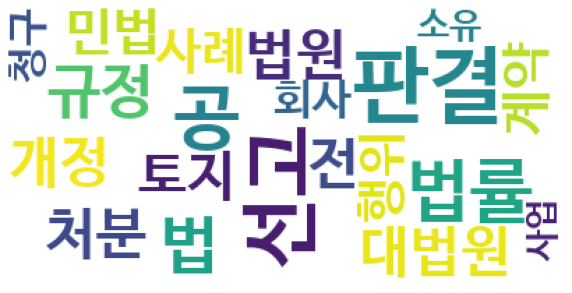

In [91]:
# World
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

In [104]:
from konlpy.tag import Okt
okt = okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )
print(oo)

TypeError: 'Mecab' object is not callable

In [103]:
# 첫번째 tokenizer
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

tokenizer_1(posts[80])


TypeError: pos() got an unexpected keyword argument 'norm'

In [102]:
# 두번째 tokenizer
def tokenizer_2(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    nouns = []
  
    for noun in tagger.nouns(raw_texts):
        if noun not in stop_words and len(noun)>1:
            nouns.append(noun)
    return nouns

tokenizer_2(posts[80])

['원고',
 '어업',
 '허가',
 '어업',
 '종사',
 '공사',
 '시행',
 '당시',
 '수산업법',
 '법률',
 '전문',
 '개정',
 '면허',
 '어업',
 '이거',
 '등록',
 '입어',
 '농촌',
 '근대',
 '화촉',
 '진법',
 '소정',
 '보상',
 '대상자',
 '사례',
 '농촌',
 '근대',
 '화촉',
 '진법',
 '수산업법',
 '법률',
 '전문',
 '개정']

# TfidfVectorizer

 TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징이란 것입니다.

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 5,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X = vectorize.fit_transform(posts)
pd.DataFrame(X.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '견지', '결과', '결론', '고려', '고용', '공동', '관계', '관련', '구체', '구토', '근거', '기관', '기점', '기준', '까닭', '나다', '나머지', '노동', '노동부', '누가', '대로', '도달', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,9719,9720,9721,9722,9723,9724,9725,9726,9727,9728
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# pd.DataFrame(X.toarray()).to_excel("TF-IDF_vectors.xlsx",index=False)

In [106]:
tfidf_df = pd.DataFrame(X.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")

In [107]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(유클리디안 거리 값)
print(euclidean_distances(X[1], X[2]))#, X)
# 2번째와 3번째 문서(코사인유사도 값)
print(cosine_similarity(X[1], X[2]))#, X)
# [[0.1837195]]

[[1.40566957]]
[[0.01204654]]


In [109]:
# info_df[info_df['ID']==target_id].index[0]

In [129]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 25초 소요
cosine_result = {}
error_reslut = {}
target_id = 216815
x = info_df[info_df['ID']==target_id].index[0]  # target_id의 Id값의 index
for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'][y]] = cosine_similarity(X[x], X[y])[0][0]
        print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"][y]] = cosine_similarity(X[x], X[y])
        print("error",x,y,cosine_similarity(X[x], X[y]))
#     print(cosine_similarity(X[x], X[y])[0][0])
# sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
# sorted_cosine_dic 

9549 0 [[0.08112858]]
9549 1 [[0.04888504]]
9549 2 [[0.02672026]]
9549 3 [[0.08874568]]
9549 4 [[0.05321062]]
9549 5 [[0.04282855]]
9549 6 [[0.0195337]]
9549 7 [[0.0548133]]
9549 8 [[0.04392692]]
9549 9 [[0.03171709]]
9549 10 [[0.0267309]]
9549 11 [[0.03188384]]
9549 12 [[0.01278449]]
9549 13 [[0.0241411]]
9549 14 [[0.03201924]]
9549 15 [[0.03598145]]
9549 16 [[0.09289288]]
9549 17 [[0.03310365]]
9549 18 [[0.01883492]]
9549 19 [[0.03286868]]
9549 20 [[0.03530226]]
9549 21 [[0.0363636]]
9549 22 [[0.04236998]]
9549 23 [[0.12471854]]
9549 24 [[0.06172275]]
9549 25 [[0.01436502]]
9549 26 [[0.03136092]]
9549 27 [[0.11827595]]
9549 28 [[0.02148314]]
9549 29 [[0.17026276]]
9549 30 [[0.02585255]]
9549 31 [[0.02469703]]
9549 32 [[0.07522912]]
9549 33 [[0.03107635]]
9549 34 [[0.01793662]]
9549 35 [[0.08829946]]
9549 36 [[0.04871743]]
9549 37 [[0.14759165]]
9549 38 [[0.01666025]]
9549 39 [[0.05669711]]
9549 40 [[0.03033099]]
9549 41 [[0.05993466]]
9549 42 [[0.0203177]]
9549 43 [[0.0175319]]
9549 

9549 436 [[0.01633323]]
9549 437 [[0.01670151]]
9549 438 [[0.01948904]]
9549 439 [[0.05289622]]
9549 440 [[0.01340052]]
9549 441 [[0.05565766]]
9549 442 [[0.00870019]]
9549 443 [[0.0300653]]
9549 444 [[0.0557289]]
9549 445 [[0.01345674]]
9549 446 [[0.00888049]]
9549 447 [[0.04344467]]
9549 448 [[0.0153288]]
9549 449 [[0.00787244]]
9549 450 [[0.01341911]]
9549 451 [[0.06213754]]
9549 452 [[0.00673831]]
9549 453 [[0.01449219]]
9549 454 [[0.01421309]]
9549 455 [[0.03385747]]
9549 456 [[0.02390143]]
9549 457 [[0.02425806]]
9549 458 [[0.04702883]]
9549 459 [[0.02014064]]
9549 460 [[0.07931563]]
9549 461 [[0.01941502]]
9549 462 [[0.00815794]]
9549 463 [[0.02223743]]
9549 464 [[0.02970019]]
9549 465 [[0.01890924]]
9549 466 [[0.03105083]]
9549 467 [[0.02232103]]
9549 468 [[0.02495058]]
9549 469 [[0.01947633]]
9549 470 [[0.]]
9549 471 [[0.00439461]]
9549 472 [[0.03924619]]
9549 473 [[0.01799826]]
9549 474 [[0.01314775]]
9549 475 [[0.02304016]]
9549 476 [[0.]]
9549 477 [[0.02814959]]
9549 478 [[

9549 793 [[0.01013551]]
9549 794 [[0.02220651]]
9549 795 [[0.03250508]]
9549 796 [[0.00545419]]
9549 797 [[0.01740675]]
9549 798 [[0.01427721]]
9549 799 [[0.04200536]]
9549 800 [[0.02697925]]
9549 801 [[0.05723558]]
9549 802 [[0.01725463]]
9549 803 [[0.01458586]]
9549 804 [[0.01778657]]
9549 805 [[0.06042262]]
9549 806 [[0.03250691]]
9549 807 [[0.03538531]]
9549 808 [[0.01252712]]
9549 809 [[0.04634273]]
9549 810 [[0.08811439]]
9549 811 [[0.0431575]]
9549 812 [[0.02367662]]
9549 813 [[0.03311951]]
9549 814 [[0.00796552]]
9549 815 [[0.03981698]]
9549 816 [[0.02089249]]
9549 817 [[0.02425872]]
9549 818 [[0.06575438]]
9549 819 [[0.05670051]]
9549 820 [[0.04067968]]
9549 821 [[0.06985525]]
9549 822 [[0.0677106]]
9549 823 [[0.04587465]]
9549 824 [[0.05143654]]
9549 825 [[0.00792569]]
9549 826 [[0.0911326]]
9549 827 [[0.18899242]]
9549 828 [[0.08605206]]
9549 829 [[0.02459199]]
9549 830 [[0.14368004]]
9549 831 [[0.04042847]]
9549 832 [[0.02809867]]
9549 833 [[0.09177708]]
9549 834 [[0.024232

9549 1199 [[0.00714667]]
9549 1200 [[0.02113908]]
9549 1201 [[0.03469354]]
9549 1202 [[0.00421901]]
9549 1203 [[0.02900207]]
9549 1204 [[0.02957472]]
9549 1205 [[0.02233081]]
9549 1206 [[0.02222768]]
9549 1207 [[0.0061957]]
9549 1208 [[0.01081915]]
9549 1209 [[0.01115886]]
9549 1210 [[0.02764439]]
9549 1211 [[0.01466232]]
9549 1212 [[0.06575816]]
9549 1213 [[0.00839665]]
9549 1214 [[0.00531288]]
9549 1215 [[0.00466928]]
9549 1216 [[0.00622687]]
9549 1217 [[0.00904419]]
9549 1218 [[0.04018125]]
9549 1219 [[0.04141507]]
9549 1220 [[0.0113107]]
9549 1221 [[0.02056802]]
9549 1222 [[0.01833714]]
9549 1223 [[0.01471472]]
9549 1224 [[0.03384788]]
9549 1225 [[0.00199041]]
9549 1226 [[0.]]
9549 1227 [[0.06089246]]
9549 1228 [[0.04777667]]
9549 1229 [[0.03701003]]
9549 1230 [[0.]]
9549 1231 [[0.00777475]]
9549 1232 [[0.04706015]]
9549 1233 [[0.03555131]]
9549 1234 [[0.0192211]]
9549 1235 [[0.05493068]]
9549 1236 [[0.0225292]]
9549 1237 [[0.0610853]]
9549 1238 [[0.00731839]]
9549 1239 [[0.0235904

9549 1599 [[0.00279114]]
9549 1600 [[0.]]
9549 1601 [[0.01098583]]
9549 1602 [[0.00798349]]
9549 1603 [[0.04314111]]
9549 1604 [[0.00621767]]
9549 1605 [[0.02027625]]
9549 1606 [[0.00966887]]
9549 1607 [[0.00758448]]
9549 1608 [[0.00705299]]
9549 1609 [[0.02212989]]
9549 1610 [[0.0442369]]
9549 1611 [[0.01048264]]
9549 1612 [[0.00535555]]
9549 1613 [[0.01193935]]
9549 1614 [[0.03468212]]
9549 1615 [[0.02231337]]
9549 1616 [[0.00721506]]
9549 1617 [[0.02073337]]
9549 1618 [[0.03313841]]
9549 1619 [[0.02535633]]
9549 1620 [[0.02040238]]
9549 1621 [[0.01693266]]
9549 1622 [[0.02888566]]
9549 1623 [[0.02320481]]
9549 1624 [[0.01651902]]
9549 1625 [[0.04397312]]
9549 1626 [[0.01192795]]
9549 1627 [[0.0331194]]
9549 1628 [[0.01943611]]
9549 1629 [[0.04864452]]
9549 1630 [[0.01702911]]
9549 1631 [[0.00675312]]
9549 1632 [[0.01017792]]
9549 1633 [[0.02247439]]
9549 1634 [[0.04068096]]
9549 1635 [[0.040579]]
9549 1636 [[0.04300512]]
9549 1637 [[0.00940219]]
9549 1638 [[0.00916649]]
9549 1639 [[

9549 2004 [[0.01817841]]
9549 2005 [[0.0244991]]
9549 2006 [[0.04127851]]
9549 2007 [[0.04796515]]
9549 2008 [[0.0389051]]
9549 2009 [[0.05106188]]
9549 2010 [[0.03758079]]
9549 2011 [[0.0144574]]
9549 2012 [[0.02427186]]
9549 2013 [[0.02701546]]
9549 2014 [[0.1069576]]
9549 2015 [[0.03102579]]
9549 2016 [[0.03616582]]
9549 2017 [[0.02634645]]
9549 2018 [[0.00870701]]
9549 2019 [[0.07297584]]
9549 2020 [[0.]]
9549 2021 [[0.0728913]]
9549 2022 [[0.0359176]]
9549 2023 [[0.04747112]]
9549 2024 [[0.05104116]]
9549 2025 [[0.04398022]]
9549 2026 [[0.03695088]]
9549 2027 [[0.02003904]]
9549 2028 [[0.02906915]]
9549 2029 [[0.06311145]]
9549 2030 [[0.01453391]]
9549 2031 [[0.00332736]]
9549 2032 [[0.00595817]]
9549 2033 [[0.03784354]]
9549 2034 [[0.01844575]]
9549 2035 [[0.02052182]]
9549 2036 [[0.02253364]]
9549 2037 [[0.02726858]]
9549 2038 [[0.07026857]]
9549 2039 [[0.02082776]]
9549 2040 [[0.05998901]]
9549 2041 [[0.0105686]]
9549 2042 [[0.05663342]]
9549 2043 [[0.06895777]]
9549 2044 [[0.0

9549 2408 [[0.02861029]]
9549 2409 [[0.01732673]]
9549 2410 [[0.02122914]]
9549 2411 [[0.02753416]]
9549 2412 [[0.0107401]]
9549 2413 [[0.02865344]]
9549 2414 [[0.07017162]]
9549 2415 [[0.04285629]]
9549 2416 [[0.01080342]]
9549 2417 [[0.03547661]]
9549 2418 [[0.01327567]]
9549 2419 [[0.02669663]]
9549 2420 [[0.06295344]]
9549 2421 [[0.06295344]]
9549 2422 [[0.01039165]]
9549 2423 [[0.0137666]]
9549 2424 [[0.009552]]
9549 2425 [[0.06333475]]
9549 2426 [[0.00970742]]
9549 2427 [[0.02762045]]
9549 2428 [[0.04686853]]
9549 2429 [[0.02568752]]
9549 2430 [[0.02739789]]
9549 2431 [[0.04846544]]
9549 2432 [[0.03929393]]
9549 2433 [[0.04504772]]
9549 2434 [[0.01726704]]
9549 2435 [[0.02323664]]
9549 2436 [[0.02217614]]
9549 2437 [[0.01531963]]
9549 2438 [[0.01442825]]
9549 2439 [[0.01962284]]
9549 2440 [[0.01297879]]
9549 2441 [[0.00356473]]
9549 2442 [[0.01557575]]
9549 2443 [[0.0165478]]
9549 2444 [[0.]]
9549 2445 [[0.]]
9549 2446 [[0.01813573]]
9549 2447 [[0.05511848]]
9549 2448 [[0.0138696

9549 2797 [[0.06517991]]
9549 2798 [[0.0330719]]
9549 2799 [[0.06228247]]
9549 2800 [[0.08946138]]
9549 2801 [[0.03097471]]
9549 2802 [[0.1063369]]
9549 2803 [[0.04786523]]
9549 2804 [[0.10837588]]
9549 2805 [[0.03057809]]
9549 2806 [[0.03481364]]
9549 2807 [[0.03531292]]
9549 2808 [[0.06209539]]
9549 2809 [[0.02285303]]
9549 2810 [[0.04143535]]
9549 2811 [[0.06168723]]
9549 2812 [[0.03946111]]
9549 2813 [[0.027867]]
9549 2814 [[0.03380374]]
9549 2815 [[0.03380374]]
9549 2816 [[0.04642002]]
9549 2817 [[0.05986446]]
9549 2818 [[0.14544359]]
9549 2819 [[0.1507032]]
9549 2820 [[0.06378898]]
9549 2821 [[0.00364017]]
9549 2822 [[0.04749897]]
9549 2823 [[0.07442022]]
9549 2824 [[0.03199071]]
9549 2825 [[0.00550175]]
9549 2826 [[0.03541355]]
9549 2827 [[0.0581867]]
9549 2828 [[0.04345959]]
9549 2829 [[0.05426119]]
9549 2830 [[0.02219689]]
9549 2831 [[0.13264375]]
9549 2832 [[0.03778049]]
9549 2833 [[0.01692733]]
9549 2834 [[0.07689322]]
9549 2835 [[0.06725303]]
9549 2836 [[0.01761859]]
9549 2

9549 3183 [[0.00904643]]
9549 3184 [[0.01469853]]
9549 3185 [[0.01098535]]
9549 3186 [[0.00414932]]
9549 3187 [[0.02148497]]
9549 3188 [[0.01042504]]
9549 3189 [[0.00452844]]
9549 3190 [[0.02909394]]
9549 3191 [[0.01737639]]
9549 3192 [[0.01048314]]
9549 3193 [[0.03500905]]
9549 3194 [[0.02032723]]
9549 3195 [[0.01896211]]
9549 3196 [[0.01653128]]
9549 3197 [[0.01847544]]
9549 3198 [[0.01608576]]
9549 3199 [[0.05494221]]
9549 3200 [[0.05252445]]
9549 3201 [[0.01826922]]
9549 3202 [[0.02199686]]
9549 3203 [[0.01508324]]
9549 3204 [[0.02660576]]
9549 3205 [[0.0292569]]
9549 3206 [[0.00648729]]
9549 3207 [[0.01126854]]
9549 3208 [[0.01450367]]
9549 3209 [[0.02114167]]
9549 3210 [[0.02804774]]
9549 3211 [[0.00240211]]
9549 3212 [[0.04184512]]
9549 3213 [[0.03280835]]
9549 3214 [[0.]]
9549 3215 [[0.01699336]]
9549 3216 [[0.0346922]]
9549 3217 [[0.02089021]]
9549 3218 [[0.00827838]]
9549 3219 [[0.02047556]]
9549 3220 [[0.00957488]]
9549 3221 [[0.00795206]]
9549 3222 [[0.00904643]]
9549 3223 

9549 3591 [[0.01993116]]
9549 3592 [[0.01947303]]
9549 3593 [[0.0255575]]
9549 3594 [[0.11822306]]
9549 3595 [[0.02781693]]
9549 3596 [[0.07209738]]
9549 3597 [[0.04928855]]
9549 3598 [[0.0194299]]
9549 3599 [[0.02411039]]
9549 3600 [[0.04464447]]
9549 3601 [[0.04964456]]
9549 3602 [[0.0870411]]
9549 3603 [[0.10560839]]
9549 3604 [[0.02739021]]
9549 3605 [[0.12114261]]
9549 3606 [[0.03217642]]
9549 3607 [[0.07334247]]
9549 3608 [[0.01866265]]
9549 3609 [[0.07954283]]
9549 3610 [[0.02128301]]
9549 3611 [[0.05742518]]
9549 3612 [[0.08149577]]
9549 3613 [[0.03671339]]
9549 3614 [[0.09738303]]
9549 3615 [[0.04138286]]
9549 3616 [[0.04969523]]
9549 3617 [[0.01985074]]
9549 3618 [[0.03354473]]
9549 3619 [[0.02475706]]
9549 3620 [[0.09031767]]
9549 3621 [[0.01656327]]
9549 3622 [[0.03231454]]
9549 3623 [[0.02809356]]
9549 3624 [[0.13878324]]
9549 3625 [[0.0951365]]
9549 3626 [[0.04436249]]
9549 3627 [[0.0313918]]
9549 3628 [[0.03903525]]
9549 3629 [[0.03495147]]
9549 3630 [[0.05565582]]
9549 

9549 3998 [[0.03396966]]
9549 3999 [[0.06122013]]
9549 4000 [[0.0397687]]
9549 4001 [[0.03015416]]
9549 4002 [[0.01644903]]
9549 4003 [[0.03454559]]
9549 4004 [[0.03056342]]
9549 4005 [[0.02128654]]
9549 4006 [[0.05636678]]
9549 4007 [[0.03149696]]
9549 4008 [[0.01979287]]
9549 4009 [[0.02239607]]
9549 4010 [[0.01011089]]
9549 4011 [[0.05773063]]
9549 4012 [[0.01563522]]
9549 4013 [[0.0421431]]
9549 4014 [[0.03003192]]
9549 4015 [[0.03436588]]
9549 4016 [[0.02374033]]
9549 4017 [[0.07320022]]
9549 4018 [[0.00619157]]
9549 4019 [[0.08427923]]
9549 4020 [[0.03001262]]
9549 4021 [[0.03221279]]
9549 4022 [[0.07212156]]
9549 4023 [[0.01941291]]
9549 4024 [[0.00944166]]
9549 4025 [[0.01775099]]
9549 4026 [[0.02224152]]
9549 4027 [[0.00956165]]
9549 4028 [[0.05502711]]
9549 4029 [[0.04868122]]
9549 4030 [[0.02123493]]
9549 4031 [[0.01213648]]
9549 4032 [[0.0391816]]
9549 4033 [[0.03437559]]
9549 4034 [[0.01923475]]
9549 4035 [[0.00112779]]
9549 4036 [[0.0185426]]
9549 4037 [[0.02370429]]
9549

9549 4412 [[0.00314755]]
9549 4413 [[0.00796283]]
9549 4414 [[0.]]
9549 4415 [[0.02006039]]
9549 4416 [[0.01926105]]
9549 4417 [[0.02761789]]
9549 4418 [[0.01579235]]
9549 4419 [[0.02105528]]
9549 4420 [[0.01654961]]
9549 4421 [[0.00846979]]
9549 4422 [[0.0608101]]
9549 4423 [[0.]]
9549 4424 [[0.07675203]]
9549 4425 [[0.04372958]]
9549 4426 [[0.03807052]]
9549 4427 [[0.00593245]]
9549 4428 [[0.00493801]]
9549 4429 [[0.00819738]]
9549 4430 [[0.045889]]
9549 4431 [[0.08985848]]
9549 4432 [[0.05667546]]
9549 4433 [[0.01697299]]
9549 4434 [[0.02250366]]
9549 4435 [[0.]]
9549 4436 [[0.02962897]]
9549 4437 [[0.06888175]]
9549 4438 [[0.02070857]]
9549 4439 [[0.02409563]]
9549 4440 [[0.02648784]]
9549 4441 [[0.03076761]]
9549 4442 [[0.01316626]]
9549 4443 [[0.01887947]]
9549 4444 [[0.01897227]]
9549 4445 [[0.01340487]]
9549 4446 [[0.]]
9549 4447 [[0.]]
9549 4448 [[0.0275985]]
9549 4449 [[0.]]
9549 4450 [[0.01710737]]
9549 4451 [[0.03201965]]
9549 4452 [[0.00784539]]
9549 4453 [[0.01151633]]
95

9549 4817 [[0.05880005]]
9549 4818 [[0.02012284]]
9549 4819 [[0.02595194]]
9549 4820 [[0.0199706]]
9549 4821 [[0.02901139]]
9549 4822 [[0.00335466]]
9549 4823 [[0.03026033]]
9549 4824 [[0.05210913]]
9549 4825 [[0.]]
9549 4826 [[0.01311386]]
9549 4827 [[0.01894509]]
9549 4828 [[0.01743825]]
9549 4829 [[0.09366237]]
9549 4830 [[0.01461125]]
9549 4831 [[0.00562634]]
9549 4832 [[0.02526004]]
9549 4833 [[0.0080276]]
9549 4834 [[0.01530371]]
9549 4835 [[0.02312836]]
9549 4836 [[0.00756915]]
9549 4837 [[0.01371026]]
9549 4838 [[0.02485203]]
9549 4839 [[0.02164464]]
9549 4840 [[0.03044325]]
9549 4841 [[0.02364358]]
9549 4842 [[0.02084756]]
9549 4843 [[0.05568633]]
9549 4844 [[0.00468454]]
9549 4845 [[0.00593147]]
9549 4846 [[0.00421251]]
9549 4847 [[0.0566954]]
9549 4848 [[0.01741336]]
9549 4849 [[0.03402065]]
9549 4850 [[0.]]
9549 4851 [[0.08484976]]
9549 4852 [[0.03070798]]
9549 4853 [[0.0086918]]
9549 4854 [[0.02882312]]
9549 4855 [[0.00371667]]
9549 4856 [[0.02268193]]
9549 4857 [[0.016073

9549 5218 [[0.0036934]]
9549 5219 [[0.0025783]]
9549 5220 [[0.01453952]]
9549 5221 [[0.]]
9549 5222 [[0.00491269]]
9549 5223 [[0.00743009]]
9549 5224 [[0.02072909]]
9549 5225 [[0.0364933]]
9549 5226 [[0.0256724]]
9549 5227 [[0.01875231]]
9549 5228 [[0.0042647]]
9549 5229 [[0.02587949]]
9549 5230 [[0.03617366]]
9549 5231 [[0.02871135]]
9549 5232 [[0.02312107]]
9549 5233 [[0.0463887]]
9549 5234 [[0.02090725]]
9549 5235 [[0.01674417]]
9549 5236 [[0.00928944]]
9549 5237 [[0.00849029]]
9549 5238 [[0.01211218]]
9549 5239 [[0.05319964]]
9549 5240 [[0.04210162]]
9549 5241 [[0.07459653]]
9549 5242 [[0.02094412]]
9549 5243 [[0.0469655]]
9549 5244 [[0.04535216]]
9549 5245 [[0.00496783]]
9549 5246 [[0.06028314]]
9549 5247 [[0.]]
9549 5248 [[0.03699592]]
9549 5249 [[0.01337516]]
9549 5250 [[0.02611988]]
9549 5251 [[0.02148308]]
9549 5252 [[0.01886476]]
9549 5253 [[0.00144742]]
9549 5254 [[0.00746682]]
9549 5255 [[0.05639145]]
9549 5256 [[0.0385637]]
9549 5257 [[0.01364934]]
9549 5258 [[0.00826722]]

9549 5623 [[0.00548306]]
9549 5624 [[0.02248036]]
9549 5625 [[0.04868427]]
9549 5626 [[0.00404354]]
9549 5627 [[0.08696593]]
9549 5628 [[0.08164395]]
9549 5629 [[0.01186732]]
9549 5630 [[0.00239362]]
9549 5631 [[0.01442305]]
9549 5632 [[0.01259586]]
9549 5633 [[0.02485976]]
9549 5634 [[0.02947042]]
9549 5635 [[0.057312]]
9549 5636 [[0.00570321]]
9549 5637 [[0.0194591]]
9549 5638 [[0.01876331]]
9549 5639 [[0.03026663]]
9549 5640 [[0.01568457]]
9549 5641 [[0.02713405]]
9549 5642 [[0.0329424]]
9549 5643 [[0.03856502]]
9549 5644 [[0.01195416]]
9549 5645 [[0.06846709]]
9549 5646 [[0.0171171]]
9549 5647 [[0.01847022]]
9549 5648 [[0.01615602]]
9549 5649 [[0.01102967]]
9549 5650 [[0.03381556]]
9549 5651 [[0.01819482]]
9549 5652 [[0.04516834]]
9549 5653 [[0.00927391]]
9549 5654 [[0.01602753]]
9549 5655 [[0.04437338]]
9549 5656 [[0.01287268]]
9549 5657 [[0.01523247]]
9549 5658 [[0.02638945]]
9549 5659 [[0.00478431]]
9549 5660 [[0.00749516]]
9549 5661 [[0.]]
9549 5662 [[0.04675788]]
9549 5663 [[0

9549 6031 [[0.00562689]]
9549 6032 [[0.02886809]]
9549 6033 [[0.0199666]]
9549 6034 [[0.00967246]]
9549 6035 [[0.03666638]]
9549 6036 [[0.04609517]]
9549 6037 [[0.00856149]]
9549 6038 [[0.05770964]]
9549 6039 [[0.01942931]]
9549 6040 [[0.00722153]]
9549 6041 [[0.00552985]]
9549 6042 [[0.00455542]]
9549 6043 [[0.0066112]]
9549 6044 [[0.]]
9549 6045 [[0.01197458]]
9549 6046 [[0.01282917]]
9549 6047 [[0.00992735]]
9549 6048 [[0.00162921]]
9549 6049 [[0.02458971]]
9549 6050 [[0.01220982]]
9549 6051 [[0.04864166]]
9549 6052 [[0.00593367]]
9549 6053 [[0.01873182]]
9549 6054 [[0.01161364]]
9549 6055 [[0.03480385]]
9549 6056 [[0.02135054]]
9549 6057 [[0.01156542]]
9549 6058 [[0.04441279]]
9549 6059 [[0.01170291]]
9549 6060 [[0.03545961]]
9549 6061 [[0.]]
9549 6062 [[0.01461237]]
9549 6063 [[0.02550568]]
9549 6064 [[0.]]
9549 6065 [[0.00760812]]
9549 6066 [[0.02056335]]
9549 6067 [[0.01812652]]
9549 6068 [[0.02629928]]
9549 6069 [[0.01697725]]
9549 6070 [[0.00597893]]
9549 6071 [[0.03531444]]
9

9549 6417 [[0.02527856]]
9549 6418 [[0.01620031]]
9549 6419 [[0.0063872]]
9549 6420 [[0.00522243]]
9549 6421 [[0.04240106]]
9549 6422 [[0.02955769]]
9549 6423 [[0.00570512]]
9549 6424 [[0.00424486]]
9549 6425 [[0.0421541]]
9549 6426 [[0.02243072]]
9549 6427 [[0.03751536]]
9549 6428 [[0.01600118]]
9549 6429 [[0.04295687]]
9549 6430 [[0.03899255]]
9549 6431 [[0.0368372]]
9549 6432 [[0.05107744]]
9549 6433 [[0.02687484]]
9549 6434 [[0.0110683]]
9549 6435 [[0.0149228]]
9549 6436 [[0.01609751]]
9549 6437 [[0.00931158]]
9549 6438 [[0.05594329]]
9549 6439 [[0.]]
9549 6440 [[0.00537129]]
9549 6441 [[0.02519246]]
9549 6442 [[0.00827515]]
9549 6443 [[0.07944433]]
9549 6444 [[0.02005033]]
9549 6445 [[0.00618524]]
9549 6446 [[0.01681235]]
9549 6447 [[0.03270223]]
9549 6448 [[0.00493583]]
9549 6449 [[0.10709805]]
9549 6450 [[0.03715999]]
9549 6451 [[0.0144522]]
9549 6452 [[0.00975577]]
9549 6453 [[0.02086398]]
9549 6454 [[0.04151848]]
9549 6455 [[0.03498648]]
9549 6456 [[0.04842916]]
9549 6457 [[0.

9549 6822 [[0.01134745]]
9549 6823 [[0.0237941]]
9549 6824 [[0.0405846]]
9549 6825 [[0.00217014]]
9549 6826 [[0.01489565]]
9549 6827 [[0.03082038]]
9549 6828 [[0.01501063]]
9549 6829 [[0.01220486]]
9549 6830 [[0.01978171]]
9549 6831 [[0.02477481]]
9549 6832 [[0.06844436]]
9549 6833 [[0.03721493]]
9549 6834 [[0.03721493]]
9549 6835 [[0.05230208]]
9549 6836 [[0.0610583]]
9549 6837 [[0.04301588]]
9549 6838 [[0.06285959]]
9549 6839 [[0.01773615]]
9549 6840 [[0.0046342]]
9549 6841 [[0.03687947]]
9549 6842 [[0.00840013]]
9549 6843 [[0.03009022]]
9549 6844 [[0.08265234]]
9549 6845 [[0.0116285]]
9549 6846 [[0.0176203]]
9549 6847 [[0.03038263]]
9549 6848 [[0.08480269]]
9549 6849 [[0.01542969]]
9549 6850 [[0.07913847]]
9549 6851 [[0.00655382]]
9549 6852 [[0.01633851]]
9549 6853 [[0.04657805]]
9549 6854 [[0.02093294]]
9549 6855 [[0.02967942]]
9549 6856 [[0.05019136]]
9549 6857 [[0.02757382]]
9549 6858 [[0.01461087]]
9549 6859 [[0.00330196]]
9549 6860 [[0.02648213]]
9549 6861 [[0.06798255]]
9549 6

9549 7208 [[0.00705565]]
9549 7209 [[0.0310945]]
9549 7210 [[0.04006489]]
9549 7211 [[0.05183255]]
9549 7212 [[0.01155538]]
9549 7213 [[0.03287813]]
9549 7214 [[0.03979404]]
9549 7215 [[0.04280961]]
9549 7216 [[0.01393527]]
9549 7217 [[0.02148264]]
9549 7218 [[0.02858582]]
9549 7219 [[0.03046267]]
9549 7220 [[0.01295366]]
9549 7221 [[0.02370294]]
9549 7222 [[0.0301855]]
9549 7223 [[0.02480345]]
9549 7224 [[0.00785566]]
9549 7225 [[0.02089742]]
9549 7226 [[0.01737432]]
9549 7227 [[0.04719673]]
9549 7228 [[0.00929204]]
9549 7229 [[0.0148944]]
9549 7230 [[0.01269093]]
9549 7231 [[0.04488882]]
9549 7232 [[0.04873953]]
9549 7233 [[0.01661009]]
9549 7234 [[0.03041125]]
9549 7235 [[0.07584517]]
9549 7236 [[0.03252585]]
9549 7237 [[0.02393648]]
9549 7238 [[0.0299452]]
9549 7239 [[0.06408493]]
9549 7240 [[0.01483159]]
9549 7241 [[0.03009006]]
9549 7242 [[0.01584968]]
9549 7243 [[0.02166356]]
9549 7244 [[0.02662851]]
9549 7245 [[0.03795814]]
9549 7246 [[0.00889004]]
9549 7247 [[0.01598027]]
9549

9549 7605 [[0.01751853]]
9549 7606 [[0.01003674]]
9549 7607 [[0.02353765]]
9549 7608 [[0.02230603]]
9549 7609 [[0.00873655]]
9549 7610 [[0.05551085]]
9549 7611 [[0.03443009]]
9549 7612 [[0.00679117]]
9549 7613 [[0.03613581]]
9549 7614 [[0.01156851]]
9549 7615 [[0.04336271]]
9549 7616 [[0.01567478]]
9549 7617 [[0.03781326]]
9549 7618 [[0.01164457]]
9549 7619 [[0.01215664]]
9549 7620 [[0.01171615]]
9549 7621 [[0.00869604]]
9549 7622 [[0.04529473]]
9549 7623 [[0.01946755]]
9549 7624 [[0.04034446]]
9549 7625 [[0.0336095]]
9549 7626 [[0.]]
9549 7627 [[0.06941943]]
9549 7628 [[0.0109706]]
9549 7629 [[0.02538924]]
9549 7630 [[0.01336809]]
9549 7631 [[0.0394396]]
9549 7632 [[0.03145578]]
9549 7633 [[0.01038375]]
9549 7634 [[0.]]
9549 7635 [[0.01590927]]
9549 7636 [[0.00809439]]
9549 7637 [[0.06456643]]
9549 7638 [[0.04633439]]
9549 7639 [[0.02995284]]
9549 7640 [[0.00892294]]
9549 7641 [[0.01685469]]
9549 7642 [[0.01970089]]
9549 7643 [[0.]]
9549 7644 [[0.0149036]]
9549 7645 [[0.00982382]]
954

9549 8006 [[0.04083206]]
9549 8007 [[0.02993872]]
9549 8008 [[0.07332376]]
9549 8009 [[0.02702803]]
9549 8010 [[0.06085432]]
9549 8011 [[0.03804175]]
9549 8012 [[0.02677113]]
9549 8013 [[0.03485616]]
9549 8014 [[0.02673324]]
9549 8015 [[0.10329315]]
9549 8016 [[0.07878596]]
9549 8017 [[0.07387883]]
9549 8018 [[0.09072288]]
9549 8019 [[0.0212606]]
9549 8020 [[0.04033407]]
9549 8021 [[0.02599882]]
9549 8022 [[0.04079718]]
9549 8023 [[0.06807176]]
9549 8024 [[0.09119497]]
9549 8025 [[0.03096959]]
9549 8026 [[0.09245562]]
9549 8027 [[0.03731714]]
9549 8028 [[0.06252671]]
9549 8029 [[0.03391404]]
9549 8030 [[0.04045859]]
9549 8031 [[0.01291042]]
9549 8032 [[0.04057221]]
9549 8033 [[0.07632953]]
9549 8034 [[0.05189855]]
9549 8035 [[0.05493649]]
9549 8036 [[0.1001533]]
9549 8037 [[0.05972472]]
9549 8038 [[0.03251924]]
9549 8039 [[0.0368221]]
9549 8040 [[0.0127573]]
9549 8041 [[0.02608252]]
9549 8042 [[0.04015287]]
9549 8043 [[0.02407248]]
9549 8044 [[0.04245956]]
9549 8045 [[0.06843701]]
9549

9549 8409 [[0.06116227]]
9549 8410 [[0.0451494]]
9549 8411 [[0.10532619]]
9549 8412 [[0.03996312]]
9549 8413 [[0.03996312]]
9549 8414 [[0.07202825]]
9549 8415 [[0.05605611]]
9549 8416 [[0.04703557]]
9549 8417 [[0.10437165]]
9549 8418 [[0.09539851]]
9549 8419 [[0.06472848]]
9549 8420 [[0.04886868]]
9549 8421 [[0.00985621]]
9549 8422 [[0.05924885]]
9549 8423 [[0.32711441]]
9549 8424 [[0.09705401]]
9549 8425 [[0.03709871]]
9549 8426 [[0.02606453]]
9549 8427 [[0.02111668]]
9549 8428 [[0.16698153]]
9549 8429 [[0.0283693]]
9549 8430 [[0.07946231]]
9549 8431 [[0.06311223]]
9549 8432 [[0.03717737]]
9549 8433 [[0.06380141]]
9549 8434 [[0.0732319]]
9549 8435 [[0.05059086]]
9549 8436 [[0.01207464]]
9549 8437 [[0.0797643]]
9549 8438 [[0.0377036]]
9549 8439 [[0.05180535]]
9549 8440 [[0.04468647]]
9549 8441 [[0.04872569]]
9549 8442 [[0.06038085]]
9549 8443 [[0.04542365]]
9549 8444 [[0.0450566]]
9549 8445 [[0.08025107]]
9549 8446 [[0.05219733]]
9549 8447 [[0.02148945]]
9549 8448 [[0.11044029]]
9549 8

9549 8815 [[0.02298245]]
9549 8816 [[0.03221819]]
9549 8817 [[0.02374861]]
9549 8818 [[0.0455587]]
9549 8819 [[0.05034973]]
9549 8820 [[0.01307056]]
9549 8821 [[0.01091015]]
9549 8822 [[0.03536025]]
9549 8823 [[0.11562463]]
9549 8824 [[0.03455822]]
9549 8825 [[0.03455822]]
9549 8826 [[0.06538368]]
9549 8827 [[0.02429712]]
9549 8828 [[0.05240476]]
9549 8829 [[0.05863931]]
9549 8830 [[0.03593849]]
9549 8831 [[0.01517443]]
9549 8832 [[0.04212609]]
9549 8833 [[0.07602589]]
9549 8834 [[0.05649675]]
9549 8835 [[0.02350338]]
9549 8836 [[0.08673455]]
9549 8837 [[0.04856245]]
9549 8838 [[0.0285974]]
9549 8839 [[0.07896043]]
9549 8840 [[0.]]
9549 8841 [[0.02356477]]
9549 8842 [[0.06727628]]
9549 8843 [[0.04301551]]
9549 8844 [[0.02220623]]
9549 8845 [[0.03376024]]
9549 8846 [[0.00669194]]
9549 8847 [[0.0362036]]
9549 8848 [[0.03432138]]
9549 8849 [[0.003173]]
9549 8850 [[0.01879421]]
9549 8851 [[0.02824592]]
9549 8852 [[0.01989741]]
9549 8853 [[0.00748958]]
9549 8854 [[0.05711307]]
9549 8855 [[0

9549 9217 [[0.03302034]]
9549 9218 [[0.02512406]]
9549 9219 [[0.03995559]]
9549 9220 [[0.0905667]]
9549 9221 [[0.03549202]]
9549 9222 [[0.06729641]]
9549 9223 [[0.05525084]]
9549 9224 [[0.02531035]]
9549 9225 [[0.02260727]]
9549 9226 [[0.03014346]]
9549 9227 [[0.02128807]]
9549 9228 [[0.01376756]]
9549 9229 [[0.0241447]]
9549 9230 [[0.04483034]]
9549 9231 [[0.00493634]]
9549 9232 [[0.01337616]]
9549 9233 [[0.05862459]]
9549 9234 [[0.00756723]]
9549 9235 [[0.01683491]]
9549 9236 [[0.03318341]]
9549 9237 [[0.00983934]]
9549 9238 [[0.035395]]
9549 9239 [[0.02509276]]
9549 9240 [[0.02060961]]
9549 9241 [[0.02510488]]
9549 9242 [[0.03011872]]
9549 9243 [[0.05389837]]
9549 9244 [[0.04028421]]
9549 9245 [[0.02060351]]
9549 9246 [[0.03553513]]
9549 9247 [[0.15038164]]
9549 9248 [[0.14900796]]
9549 9249 [[0.04102279]]
9549 9250 [[0.03673519]]
9549 9251 [[0.02372398]]
9549 9252 [[0.03496596]]
9549 9253 [[0.03655854]]
9549 9254 [[0.03524717]]
9549 9255 [[0.02112663]]
9549 9256 [[0.02546614]]
9549

9549 9623 [[0.09379297]]
9549 9624 [[0.02995968]]
9549 9625 [[0.01917292]]
9549 9626 [[0.06247962]]
9549 9627 [[0.04164329]]
9549 9628 [[0.02983569]]
9549 9629 [[0.03441325]]
9549 9630 [[0.07599525]]
9549 9631 [[0.07962352]]
9549 9632 [[0.06124012]]
9549 9633 [[0.08014774]]
9549 9634 [[0.03874925]]
9549 9635 [[0.07462577]]
9549 9636 [[0.08323187]]
9549 9637 [[0.04184566]]
9549 9638 [[0.13027587]]
9549 9639 [[0.10636744]]
9549 9640 [[0.095527]]
9549 9641 [[0.02106076]]
9549 9642 [[0.0400037]]
9549 9643 [[0.0958206]]
9549 9644 [[0.08530886]]
9549 9645 [[0.04790986]]
9549 9646 [[0.09119552]]
9549 9647 [[0.11188267]]
9549 9648 [[0.03148731]]
9549 9649 [[0.0615393]]
9549 9650 [[0.08962115]]
9549 9651 [[0.11667231]]
9549 9652 [[0.07790539]]
9549 9653 [[0.01904074]]
9549 9654 [[0.07969011]]
9549 9655 [[0.27161904]]
9549 9656 [[0.03630046]]
9549 9657 [[0.04809379]]
9549 9658 [[0.0572284]]
9549 9659 [[0.02829075]]
9549 9660 [[0.08359298]]
9549 9661 [[0.03750619]]
9549 9662 [[0.03241734]]
9549 9

9549 10029 [[0.09834574]]
9549 10030 [[0.06649229]]
9549 10031 [[0.04989276]]
9549 10032 [[0.03977926]]
9549 10033 [[0.05868049]]
9549 10034 [[0.03431677]]
9549 10035 [[0.06961474]]
9549 10036 [[0.03689196]]
9549 10037 [[0.03875961]]
9549 10038 [[0.16782541]]
9549 10039 [[0.04500814]]
9549 10040 [[0.05848057]]
9549 10041 [[0.01457749]]
9549 10042 [[0.06606416]]
9549 10043 [[0.05219803]]
9549 10044 [[0.1392467]]
9549 10045 [[0.16973318]]
9549 10046 [[0.07348571]]
9549 10047 [[0.0553202]]
9549 10048 [[0.02813081]]
9549 10049 [[0.05156474]]
9549 10050 [[0.0350507]]
9549 10051 [[0.06228786]]
9549 10052 [[0.06308524]]
9549 10053 [[0.05344764]]
9549 10054 [[0.17569975]]
9549 10055 [[0.08619186]]
9549 10056 [[0.06229193]]
9549 10057 [[0.03575506]]
9549 10058 [[0.0580126]]
9549 10059 [[0.04065405]]
9549 10060 [[0.12606019]]
9549 10061 [[0.08302645]]
9549 10062 [[0.04811422]]
9549 10063 [[0.04862096]]
9549 10064 [[0.06008264]]
9549 10065 [[0.03932585]]
9549 10066 [[0.0682364]]
9549 10067 [[0.08

9549 10435 [[0.0612989]]
9549 10436 [[0.08530051]]
9549 10437 [[0.08530051]]
9549 10438 [[0.06587021]]
9549 10439 [[0.08761092]]
9549 10440 [[0.06691918]]
9549 10441 [[0.03868077]]
9549 10442 [[0.09263526]]
9549 10443 [[0.01320264]]
9549 10444 [[0.0848374]]
9549 10445 [[0.07375662]]
9549 10446 [[0.04718689]]
9549 10447 [[0.0606912]]
9549 10448 [[0.03852888]]
9549 10449 [[0.09678204]]
9549 10450 [[0.06450983]]
9549 10451 [[0.03911437]]
9549 10452 [[0.08310419]]
9549 10453 [[0.02534564]]
9549 10454 [[0.01605942]]
9549 10455 [[0.05975458]]
9549 10456 [[0.04842358]]
9549 10457 [[0.09273638]]
9549 10458 [[0.14097988]]
9549 10459 [[0.08192385]]
9549 10460 [[0.10776649]]
9549 10461 [[0.03625536]]
9549 10462 [[0.03881167]]
9549 10463 [[0.06501446]]
9549 10464 [[0.06351592]]
9549 10465 [[0.02734483]]
9549 10466 [[0.03294131]]
9549 10467 [[0.09074465]]
9549 10468 [[0.04549076]]
9549 10469 [[0.03550344]]
9549 10470 [[0.08177697]]
9549 10471 [[0.03600775]]
9549 10472 [[0.04803654]]
9549 10473 [[0.

9549 10824 [[0.06296159]]
9549 10825 [[0.01294683]]
9549 10826 [[0.04356803]]
9549 10827 [[0.06643049]]
9549 10828 [[0.06125516]]
9549 10829 [[0.07851291]]
9549 10830 [[0.12282024]]
9549 10831 [[0.04799524]]
9549 10832 [[0.07777696]]
9549 10833 [[0.07413833]]
9549 10834 [[0.05297906]]
9549 10835 [[0.05454517]]
9549 10836 [[0.03419375]]
9549 10837 [[0.07092435]]
9549 10838 [[0.04556509]]
9549 10839 [[0.03443264]]
9549 10840 [[0.09317378]]
9549 10841 [[0.04322822]]
9549 10842 [[0.01864126]]
9549 10843 [[0.03070715]]
9549 10844 [[0.03790461]]
9549 10845 [[0.0498675]]
9549 10846 [[0.04883288]]
9549 10847 [[0.05008762]]
9549 10848 [[0.06001217]]
9549 10849 [[0.04559964]]
9549 10850 [[0.05257507]]
9549 10851 [[0.1050053]]
9549 10852 [[0.09260884]]
9549 10853 [[0.13974518]]
9549 10854 [[0.02964649]]
9549 10855 [[0.02130442]]
9549 10856 [[0.00183522]]
9549 10857 [[0.00183522]]
9549 10858 [[0.08251939]]
9549 10859 [[0.05327731]]
9549 10860 [[0.0454767]]
9549 10861 [[0.06494928]]
9549 10862 [[0.

9549 11232 [[0.03289551]]
9549 11233 [[0.09892812]]
9549 11234 [[0.04385676]]
9549 11235 [[0.03988169]]
9549 11236 [[0.05903883]]
9549 11237 [[0.1206066]]
9549 11238 [[0.02829766]]
9549 11239 [[0.12064892]]
9549 11240 [[0.0665426]]
9549 11241 [[0.07130251]]
9549 11242 [[0.01998364]]
9549 11243 [[0.0361774]]
9549 11244 [[0.07488665]]
9549 11245 [[0.04226886]]
9549 11246 [[0.17404416]]
9549 11247 [[0.04580374]]
9549 11248 [[0.05240318]]
9549 11249 [[0.04495296]]
9549 11250 [[0.05570627]]
9549 11251 [[0.05751705]]
9549 11252 [[0.09001773]]
9549 11253 [[0.03857169]]
9549 11254 [[0.04276237]]
9549 11255 [[0.10169667]]
9549 11256 [[0.03899568]]
9549 11257 [[0.04917029]]
9549 11258 [[0.08713641]]
9549 11259 [[0.09204897]]
9549 11260 [[0.04502016]]
9549 11261 [[0.01859842]]
9549 11262 [[0.03400798]]
9549 11263 [[0.05012061]]
9549 11264 [[0.05817912]]
9549 11265 [[0.0750476]]
9549 11266 [[0.07492472]]
9549 11267 [[0.1960331]]
9549 11268 [[0.04496639]]
9549 11269 [[0.06574601]]
9549 11270 [[0.06

9549 11624 [[0.05488845]]
9549 11625 [[0.11442319]]
9549 11626 [[0.00839613]]
9549 11627 [[0.04466183]]
9549 11628 [[0.05858532]]
9549 11629 [[0.0497767]]
9549 11630 [[0.04292334]]
9549 11631 [[0.07989103]]
9549 11632 [[0.0741386]]
9549 11633 [[0.05346003]]
9549 11634 [[0.14324464]]
9549 11635 [[0.02617554]]
9549 11636 [[0.10750656]]
9549 11637 [[0.06359802]]
9549 11638 [[0.05029558]]
9549 11639 [[0.08491566]]
9549 11640 [[0.11469731]]
9549 11641 [[0.01101137]]
9549 11642 [[0.01868309]]
9549 11643 [[0.08326165]]
9549 11644 [[0.02860642]]
9549 11645 [[0.02125562]]
9549 11646 [[0.06055235]]
9549 11647 [[0.03591036]]
9549 11648 [[0.06630136]]
9549 11649 [[0.12668656]]
9549 11650 [[0.07944459]]
9549 11651 [[0.09584595]]
9549 11652 [[0.04863504]]
9549 11653 [[0.04056524]]
9549 11654 [[0.10928959]]
9549 11655 [[0.05188428]]
9549 11656 [[0.02973372]]
9549 11657 [[0.0365163]]
9549 11658 [[0.08679063]]
9549 11659 [[0.02693038]]
9549 11660 [[0.05522712]]
9549 11661 [[0.09137202]]
9549 11662 [[0.

9549 12029 [[0.0787724]]
9549 12030 [[0.03523296]]
9549 12031 [[0.05755979]]
9549 12032 [[0.05537013]]
9549 12033 [[0.03314638]]
9549 12034 [[0.06443198]]
9549 12035 [[0.0468884]]
9549 12036 [[0.16156883]]
9549 12037 [[0.02824316]]
9549 12038 [[0.02977702]]
9549 12039 [[0.05889555]]
9549 12040 [[0.04038993]]
9549 12041 [[0.02089754]]
9549 12042 [[0.08533953]]
9549 12043 [[0.04224919]]
9549 12044 [[0.01908211]]
9549 12045 [[0.05078891]]
9549 12046 [[0.07654962]]
9549 12047 [[0.07521894]]
9549 12048 [[0.03700052]]
9549 12049 [[0.04663196]]
9549 12050 [[0.01250326]]
9549 12051 [[0.03712529]]
9549 12052 [[0.04687765]]
9549 12053 [[0.05604453]]
9549 12054 [[0.07740259]]
9549 12055 [[0.06720772]]
9549 12056 [[0.06294199]]
9549 12057 [[0.04128082]]
9549 12058 [[0.04544572]]
9549 12059 [[0.06906487]]
9549 12060 [[0.08051612]]
9549 12061 [[0.06386422]]
9549 12062 [[0.05811585]]
9549 12063 [[0.04604679]]
9549 12064 [[0.01257522]]
9549 12065 [[0.03162953]]
9549 12066 [[0.04433225]]
9549 12067 [[0

9549 12434 [[0.10485489]]
9549 12435 [[0.12302763]]
9549 12436 [[0.05299323]]
9549 12437 [[0.02809781]]
9549 12438 [[0.05537858]]
9549 12439 [[0.0890463]]
9549 12440 [[0.05291795]]
9549 12441 [[0.02511427]]
9549 12442 [[0.01148264]]
9549 12443 [[0.1249553]]
9549 12444 [[0.05732012]]
9549 12445 [[0.03476759]]
9549 12446 [[0.01277416]]
9549 12447 [[0.03255778]]
9549 12448 [[0.02820516]]
9549 12449 [[0.01057629]]
9549 12450 [[0.04275541]]
9549 12451 [[0.02892944]]
9549 12452 [[0.05472899]]
9549 12453 [[0.02211351]]
9549 12454 [[0.06997686]]
9549 12455 [[0.02589403]]
9549 12456 [[0.06403063]]
9549 12457 [[0.02469752]]
9549 12458 [[0.03309407]]
9549 12459 [[0.02799006]]
9549 12460 [[0.02063746]]
9549 12461 [[0.05899757]]
9549 12462 [[0.02963265]]
9549 12463 [[0.06325877]]
9549 12464 [[0.01979283]]
9549 12465 [[0.0789191]]
9549 12466 [[0.02339426]]
9549 12467 [[0.06946007]]
9549 12468 [[0.05320625]]
9549 12469 [[0.15022997]]
9549 12470 [[0.09073474]]
9549 12471 [[0.01425316]]
9549 12472 [[0.

9549 12834 [[0.0903917]]
9549 12835 [[0.02582494]]
9549 12836 [[0.02326861]]
9549 12837 [[0.0469909]]
9549 12838 [[0.04492091]]
9549 12839 [[0.01523384]]
9549 12840 [[0.05484195]]
9549 12841 [[0.03128449]]
9549 12842 [[0.03211622]]
9549 12843 [[0.150947]]
9549 12844 [[0.08773198]]
9549 12845 [[0.01084094]]
9549 12846 [[0.05416475]]
9549 12847 [[0.05549225]]
9549 12848 [[0.01896793]]
9549 12849 [[0.08056341]]
9549 12850 [[0.04007429]]
9549 12851 [[0.03415642]]
9549 12852 [[0.01310967]]
9549 12853 [[0.02842028]]
9549 12854 [[0.09394776]]
9549 12855 [[0.05317275]]
9549 12856 [[0.04796811]]
9549 12857 [[0.04719724]]
9549 12858 [[0.01167965]]
9549 12859 [[0.02766985]]
9549 12860 [[0.06219531]]
9549 12861 [[0.01013482]]
9549 12862 [[0.06892823]]
9549 12863 [[0.04249908]]
9549 12864 [[0.01563748]]
9549 12865 [[0.07502921]]
9549 12866 [[0.02127477]]
9549 12867 [[0.02512015]]
9549 12868 [[0.06773307]]
9549 12869 [[0.04169866]]
9549 12870 [[0.05957205]]
9549 12871 [[0.04794193]]
9549 12872 [[0.0

9549 13239 [[0.06382794]]
9549 13240 [[0.02248714]]
9549 13241 [[0.05014762]]
9549 13242 [[0.01215665]]
9549 13243 [[0.08158504]]
9549 13244 [[0.05407906]]
9549 13245 [[0.12733934]]
9549 13246 [[0.12942354]]
9549 13247 [[0.0329945]]
9549 13248 [[0.04327484]]
9549 13249 [[0.04401787]]
9549 13250 [[0.0475422]]
9549 13251 [[0.07364046]]
9549 13252 [[0.03072397]]
9549 13253 [[0.0247123]]
9549 13254 [[0.06210096]]
9549 13255 [[0.02956334]]
9549 13256 [[0.10345294]]
9549 13257 [[0.04470561]]
9549 13258 [[0.03523998]]
9549 13259 [[0.0535633]]
9549 13260 [[0.03787499]]
9549 13261 [[0.03729441]]
9549 13262 [[0.07568107]]
9549 13263 [[0.06233269]]
9549 13264 [[0.04673288]]
9549 13265 [[0.0356864]]
9549 13266 [[0.02157039]]
9549 13267 [[0.03617695]]
9549 13268 [[0.10973056]]
9549 13269 [[0.04134613]]
9549 13270 [[0.08060498]]
9549 13271 [[0.02234889]]
9549 13272 [[0.003556]]
9549 13273 [[0.04411183]]
9549 13274 [[0.05741988]]
9549 13275 [[0.0687758]]
9549 13276 [[0.00320086]]
9549 13277 [[0.01429

9549 13644 [[0.05250065]]
9549 13645 [[0.01468462]]
9549 13646 [[0.11450759]]
9549 13647 [[0.11212006]]
9549 13648 [[0.02600696]]
9549 13649 [[0.07829242]]
9549 13650 [[0.03869572]]
9549 13651 [[0.03466942]]
9549 13652 [[0.03580021]]
9549 13653 [[0.06377431]]
9549 13654 [[0.00863193]]
9549 13655 [[0.03416751]]
9549 13656 [[0.13665113]]
9549 13657 [[0.09329336]]
9549 13658 [[0.04482707]]
9549 13659 [[0.049047]]
9549 13660 [[0.04362897]]
9549 13661 [[0.06915888]]
9549 13662 [[0.10107271]]
9549 13663 [[0.04404327]]
9549 13664 [[0.02040652]]
9549 13665 [[0.05280731]]
9549 13666 [[0.]]
9549 13667 [[0.10730875]]
9549 13668 [[0.06676002]]
9549 13669 [[0.05786606]]
9549 13670 [[0.02281925]]
9549 13671 [[0.01836626]]
9549 13672 [[0.04811882]]
9549 13673 [[0.01128176]]
9549 13674 [[0.06507235]]
9549 13675 [[0.09116495]]
9549 13676 [[0.05212428]]
9549 13677 [[0.04034876]]
9549 13678 [[0.04327652]]
9549 13679 [[0.03883649]]
9549 13680 [[0.06921971]]
9549 13681 [[0.04232657]]
9549 13682 [[0.1193948

9549 14031 [[0.07032177]]
9549 14032 [[0.01890108]]
9549 14033 [[0.03048444]]
9549 14034 [[0.04044504]]
9549 14035 [[0.03294517]]
9549 14036 [[0.03356546]]
9549 14037 [[0.03981595]]
9549 14038 [[0.02189599]]
9549 14039 [[0.03660443]]
9549 14040 [[0.14127314]]
9549 14041 [[0.1064607]]
9549 14042 [[0.05896537]]
9549 14043 [[0.01855143]]
9549 14044 [[0.06536196]]
9549 14045 [[0.08783535]]
9549 14046 [[0.04543622]]
9549 14047 [[0.01094364]]
9549 14048 [[0.13225778]]
9549 14049 [[0.02690919]]
9549 14050 [[0.03616693]]
9549 14051 [[0.05700117]]
9549 14052 [[0.02448042]]
9549 14053 [[0.09034325]]
9549 14054 [[0.02387646]]
9549 14055 [[0.10738075]]
9549 14056 [[0.05145587]]
9549 14057 [[0.14175731]]
9549 14058 [[0.04029254]]
9549 14059 [[0.03814128]]
9549 14060 [[0.05388496]]
9549 14061 [[0.03368808]]
9549 14062 [[0.07061784]]
9549 14063 [[0.01905618]]
9549 14064 [[0.06452079]]
9549 14065 [[0.0420526]]
9549 14066 [[0.07569541]]
9549 14067 [[0.01514775]]
9549 14068 [[0.04849547]]
9549 14069 [[0

9549 14440 [[0.03217286]]
9549 14441 [[0.02927924]]
9549 14442 [[0.04361053]]
9549 14443 [[0.06258915]]
9549 14444 [[0.07091594]]
9549 14445 [[0.0284125]]
9549 14446 [[0.06977934]]
9549 14447 [[0.06095087]]
9549 14448 [[0.01291092]]
9549 14449 [[0.04792255]]
9549 14450 [[0.01304433]]
9549 14451 [[0.02043072]]
9549 14452 [[0.07820181]]
9549 14453 [[0.07215823]]
9549 14454 [[0.0432547]]
9549 14455 [[0.03940814]]
9549 14456 [[0.04484152]]
9549 14457 [[0.04083627]]
9549 14458 [[0.03268063]]
9549 14459 [[0.04666875]]
9549 14460 [[0.02678459]]
9549 14461 [[0.04028156]]
9549 14462 [[0.07675631]]
9549 14463 [[0.04590299]]
9549 14464 [[0.02328761]]
9549 14465 [[0.0525979]]
9549 14466 [[0.0329469]]
9549 14467 [[0.06099408]]
9549 14468 [[0.06726951]]
9549 14469 [[0.10368462]]
9549 14470 [[0.02393288]]
9549 14471 [[0.05632719]]
9549 14472 [[0.09872526]]
9549 14473 [[0.0535401]]
9549 14474 [[0.04437567]]
9549 14475 [[0.02323591]]
9549 14476 [[0.0304279]]
9549 14477 [[0.12009627]]
9549 14478 [[0.034

9549 14847 [[0.03704193]]
9549 14848 [[0.0320576]]
9549 14849 [[0.10725952]]
9549 14850 [[0.02932364]]
9549 14851 [[0.03256623]]
9549 14852 [[0.02562056]]
9549 14853 [[0.0263461]]
9549 14854 [[0.03907456]]
9549 14855 [[0.01648251]]
9549 14856 [[0.03419526]]
9549 14857 [[0.10125228]]
9549 14858 [[0.04578432]]
9549 14859 [[0.0291305]]
9549 14860 [[0.04256445]]
9549 14861 [[0.05293193]]
9549 14862 [[0.03392498]]
9549 14863 [[0.08273741]]
9549 14864 [[0.01193648]]
9549 14865 [[0.02907816]]
9549 14866 [[0.05727063]]
9549 14867 [[0.04366504]]
9549 14868 [[0.05360432]]
9549 14869 [[0.08067705]]
9549 14870 [[0.01135353]]
9549 14871 [[0.04259541]]
9549 14872 [[0.05355695]]
9549 14873 [[0.01714626]]
9549 14874 [[0.02514885]]
9549 14875 [[0.0543419]]
9549 14876 [[0.03648886]]
9549 14877 [[0.03878063]]
9549 14878 [[0.03855655]]
9549 14879 [[0.13434186]]
9549 14880 [[0.06857011]]
9549 14881 [[0.07002125]]
9549 14882 [[0.07757642]]
9549 14883 [[0.04516263]]
9549 14884 [[0.02967581]]
9549 14885 [[0.0

9549 15252 [[0.08482375]]
9549 15253 [[0.01967674]]
9549 15254 [[0.06463791]]
9549 15255 [[0.0218155]]
9549 15256 [[0.02289589]]
9549 15257 [[0.03592251]]
9549 15258 [[0.09009945]]
9549 15259 [[0.05134451]]
9549 15260 [[0.03486279]]
9549 15261 [[0.12859159]]
9549 15262 [[0.0314011]]
9549 15263 [[0.03022989]]
9549 15264 [[0.01412098]]
9549 15265 [[0.05776523]]
9549 15266 [[0.02297558]]
9549 15267 [[0.04510919]]
9549 15268 [[0.06277955]]
9549 15269 [[0.02923237]]
9549 15270 [[0.04629592]]
9549 15271 [[0.06004853]]
9549 15272 [[0.04172811]]
9549 15273 [[0.07357742]]
9549 15274 [[0.06644824]]
9549 15275 [[0.057016]]
9549 15276 [[0.10775831]]
9549 15277 [[0.09940473]]
9549 15278 [[0.08716691]]
9549 15279 [[0.04363448]]
9549 15280 [[0.04510299]]
9549 15281 [[0.08310093]]
9549 15282 [[0.08417898]]
9549 15283 [[0.05027714]]
9549 15284 [[0.06354912]]
9549 15285 [[0.03943465]]
9549 15286 [[0.01768037]]
9549 15287 [[0.05921114]]
9549 15288 [[0.06412166]]
9549 15289 [[0.04843798]]
9549 15290 [[0.0

9549 15655 [[0.0415553]]
9549 15656 [[0.05678576]]
9549 15657 [[0.07321613]]
9549 15658 [[0.06281212]]
9549 15659 [[0.07762221]]
9549 15660 [[0.03620953]]
9549 15661 [[0.04536236]]
9549 15662 [[0.0279429]]
9549 15663 [[0.03519097]]
9549 15664 [[0.06624144]]
9549 15665 [[0.06223291]]
9549 15666 [[0.0374351]]
9549 15667 [[0.08268523]]
9549 15668 [[0.03224377]]
9549 15669 [[0.09090899]]
9549 15670 [[0.08638813]]
9549 15671 [[0.01386471]]
9549 15672 [[0.04622206]]
9549 15673 [[0.07097257]]
9549 15674 [[0.03915427]]
9549 15675 [[0.06303131]]
9549 15676 [[0.02987463]]
9549 15677 [[0.05839646]]
9549 15678 [[0.03926543]]
9549 15679 [[0.04780706]]
9549 15680 [[0.02321414]]
9549 15681 [[0.02321414]]
9549 15682 [[0.06524057]]
9549 15683 [[0.0952894]]
9549 15684 [[0.07883635]]
9549 15685 [[0.03077449]]
9549 15686 [[0.03044379]]
9549 15687 [[0.02045927]]
9549 15688 [[0.05550285]]
9549 15689 [[0.03895324]]
9549 15690 [[0.05631488]]
9549 15691 [[0.03361773]]
9549 15692 [[0.06564567]]
9549 15693 [[0.0

KeyError: 15964

In [ ]:
# target_id 에 해당하는 판례와 유사한 판례 상위 10개 도출
for id_ in sorted_cosine_dic[0:11]:
    url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(id_[0])
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(id_[0])
    print(url)

In [ ]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df